# Final Project: U.S. Police Involved Fatalities analysis

# 1. Research Question

Since in last years, racism in U.S. has been a worldwide topic, goal of the first part of the project (Classification) is to analyze U.S. Police reports about kills where U.S. police officers where involved as killer, in order to understand firstly if there are path in words, in the way that police officers write the reports about these fatalities, to recognize the race of the killed boy/girl. Another interesting question could be if there are more common situation where a certain member of a certain race gets involved in those situations. Goal of the second part of the project is to understand if N.E.R. can actually help police stations in understanding what happened in a faster way, and to store data automatically.

# 2. Data, Preprocessing, Annotation, and Analysis

Content of the dataset are reports, made by police officers, of fatalities where basically the killer was always the police officer/officers. Other than this, we had their names, age, gender, location of the fatality, who was the agent involved, the cause of the death (that was always gunshot) and if the killed guy had symptoms of mental illness. What we're planning to look at are those reports in order to understand firstly the immediate features of these reports (most common words by race, topic modelling, word/doc2vec), and then going in deep to understand if it is possible to retrieve the race of the killed person from the words of the reports.

In [1]:
'''
Let' s import the packages that we will use during the analysis
'''

import re
import sys
import json
import nltk
import time 
import spacy
import string
import pickle
import random
import sqlite3 
import warnings
import numpy as np
import pandas as pd
import seaborn as sb
import multiprocessing
from sklearn.svm import SVC
from matplotlib import colors
from keras.models import Model
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from nltk.corpus import stopwords
nlp = spacy.load("en_core_web_sm")
from keras.models import Sequential
from keras.layers import InputLayer
from sklearn.pipeline import Pipeline
from gensim.corpora import Dictionary
from keras.utils import to_categorical
from mpl_toolkits.mplot3d import Axes3D
from sklearn.dummy import DummyClassifier
from gensim.models.phrases import Phrases
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score
from collections import Counter, defaultdict
from keras.layers.convolutional import Conv1D
from keras.layers.core import Dense, Activation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from gensim.models.doc2vec import TaggedDocument
from sklearn import model_selection, preprocessing
from keras.layers import Input, Embedding, Dropout
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.sequence import pad_sequences
from gensim.test.utils import datapath, temporary_file
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.cluster import KMeans, AgglomerativeClustering
from keras.layers import GlobalMaxPooling1D, Dropout, Bidirectional, LSTM
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Phrases, Word2Vec, Doc2Vec, LdaMulticore, TfidfModel, CoherenceModel, AuthorTopicModel
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score,plot_confusion_matrix

In [2]:
'We firstly import the dataset (found on data.com) about the U.S. Police involved fatalities.'

criminali = pd.read_csv('z_old_data.csv', engine='python')

'From this, we create criminali_refined, a dataset where we take just some of the columns.'

criminali_refined = criminali[['Race','Circumstances surrounding death','Age','State']]

'We drop the rows containing NaN values.'

criminali_refined = criminali_refined.dropna()
criminali_refined = criminali_refined.reset_index()
criminali_refined = criminali_refined.drop(['index'],axis=1)
criminali_refined = criminali_refined.drop_duplicates(subset='Circumstances surrounding death') 

'''
Here, we start dealing with ages. Problem is that there are even people less than a year old, so basically we have to transform
their age in 0, since we consider only years. Moreover, there are people with no precise age (e.g. 20-30, or 20ies), so we 
decide just to keep the rows where the value in Age column is numerical.
'''
criminali_refined['Age'] = [re.sub('s','', age) for age in criminali_refined.Age]
criminali_refined['Age'] = [re.sub('[0-90-9]* month','0', age) for age in criminali_refined.Age]
criminali_refined['Age'] = [re.sub('[0-90-9]* months','1', age) for age in criminali_refined.Age]
criminali_refined = criminali_refined[criminali_refined.Age.apply(lambda x: x.isnumeric())]
criminali_refined['Age'] = criminali_refined['Age'].apply(lambda x: int(x))

'''
Here we try to create a column where basically we indicate the REGION were the fatalities has appened. We decide so to 
cluster each state basing on the map offered by https://www.nationalgeographic.org/maps/united-states-regions/.
'''

def label_state(row):
    if row['State'] ==  'AZ' or row['State'] ==  'NM' or row['State'] ==  'OK' or row['State'] ==  'TX': 
        return 'Southwest'
    elif row['State'] ==  'WA' or row['State'] ==  'OR' or row['State'] ==  'ID' or row['State'] ==  'MT' or\
    row['State'] ==  'WY' or row['State'] ==  'CA' or row['State'] ==  'NV' or row['State'] ==  'UT' or\
    row['State'] ==  'CO':
        return 'West'
    elif row['State'] ==  'ND' or row['State'] ==  'SD' or row['State'] ==  'NE' or row['State'] ==  'KS' or\
    row['State'] ==  'MN' or row['State'] ==  'IA' or row['State'] ==  'MO' or row['State'] ==  'WI' or\
    row['State'] ==  'IL' or row['State'] ==  'MI' or row['State'] ==  'IN' or row['State'] ==  'OH':
        return 'Midwest'
    elif row['State'] ==  'AR' or row['State'] ==  'LA' or row['State'] ==  'MS' or row['State'] ==  'AL' or\
    row['State'] ==  'TN' or row['State'] ==  'KY' or row['State'] ==  'WV' or row['State'] ==  'DC' or\
    row['State'] ==  'VA' or row['State'] ==  'NC' or row['State'] ==  'SC' or row['State'] ==  'GA' or row['State'] ==  'FL':
        return 'Southeast'
    else:
        return 'Northeast'
    
criminali_refined['Region'] = criminali_refined.apply(lambda x: label_state(x), axis=1)

'''
Here, we basically do the same that we did for the States, but applied to Age. We decide to create 6 different age-ranges,
splitting by groups of 15 years, from 0-15 to 75+.
'''

def label_age(row):
    if row['Age'] >= 0 and row['Age'] <= 15:
        return '0 - 15'
    elif row['Age'] > 15 and row['Age'] <= 30:
        return '16 - 30'
    elif row['Age'] > 30 and row['Age'] <= 45:
        return '31 - 45'
    elif row['Age'] > 45 and row['Age'] <= 60:
        return '46 - 60'
    elif row['Age'] > 60 and row['Age'] <= 75:
        return '61 - 75'
    if row['Age'] > 75: 
        return '76 +'

criminali_refined['Age_Range'] = criminali_refined.apply(lambda x: label_age(x), axis=1)

In [3]:
'''
Now there's the problem that many Races that there are listed appear very few times. For this reason, we decide to consider
just the top three: African-American/Black, European-American/White and Hispanic/Latino.
'''

criminali_refined = criminali_refined[['Race','Circumstances surrounding death','Region', 'Age_Range', 'State']]
criminali_refined = criminali_refined.dropna()
criminali_refined = criminali_refined.reset_index()
criminali_refined = criminali_refined.drop(['index'],axis=1)
criminali_refined = criminali_refined[criminali_refined['Race']!='http://ak-cache.legacy.net/legacy/Images/Cobrands/DignityMemorial/Photos/f83d5605-2ac5-4605-a680-c75f9b7ef08e.jpg']
criminali_refined = criminali_refined[criminali_refined['Race']!='Middle Eastern']
criminali_refined = criminali_refined[criminali_refined['Race']!='Native American/Alaskan']
criminali_refined = criminali_refined[criminali_refined['Race']!='Asian']

In [4]:
'''
Here we correct typos that are present in the Race column, so that we are able to come up just with the three desired values.
'''

criminali_refined.Race.replace('african-American/Black', 'African-American/Black', inplace=True)
criminali_refined.Race.replace('HIspanic/Latino', 'Hispanic/Latino', inplace=True)
criminali_refined.Race.replace('European-American/white', 'European-American/White', inplace=True)
criminali_refined.Race.replace('Pakistani American', 'African-American/Black', inplace=True)
criminali_refined.Race.replace('Pacific Islander', 'African-American/Black', inplace=True)

In [5]:
'''
Here are the numbers in our dataset.
'''

print(Counter(criminali_refined['Race']))
print('---')
print(sum(Counter(criminali_refined['Race']).values()))


Counter({'European-American/White': 2913, 'African-American/Black': 2072, 'Hispanic/Latino': 1442})
---
6427


In [6]:
'''
As we can see, European-American/White is the largest class, accounting for the 45.6% of our dataset. Moreover, here we 
printed the len of the whole dataset: 6427 different reports. Here, we generate the column where we will work on to refine 
the text, in order to come up with two different columns at the end: one with the original description and one with the 
refined description. 
'''

criminali_refined['Description_Cleaned'] = criminali_refined['Circumstances surrounding death']
criminali_refined.columns = ['Race','Description_orig','Region','Age_Range','State', 'Desc']

### Refining

The refining of the text didn't take us many steps, due to the fact that the reports were written with a correct grammar and with no particular typos. Moreover, we didn't have to deal with hashtags, emoticons and redundant words. <br> <br>
Firstly, we lowered the text. Then, from NLTK we took the list of the most common stopwords in english, and stored them into a list. We removed links (probably there wasn't any, but we decided to be sure about it, deleting them). Then we dealt with punctuation, removing every special charachter present. After this, we removed excessive spaces, both in the middle of the text and at the end. Then we applied a function to clean the text: we removed excessive spaces, we applied the lemmatizazion, also removing short words, and we applied PartOfSpeech (POS) since all reports were written with a correct grammar, so we felt confident in applying it. We decided to keep only the most important ones: Nouns, Verbs, Adjectives, Adverbs and special charachters (X). We decided to avoid stemmatization, since it was very strong, and it made the report lose all its meaning. Subsequently, we removed stopwords from the already cleaned text. Moving on, we removed again excessive spaces, we stripped the Desc column and removed the NaN values, resulting from the cleaning of the text. Finally, we decided to apply collocations, in order to substitute the couple of Unigrams with the highest score (in this case, we decided to generate year_old, las_vegas, fatally_shoot and pepper_spray).

In [7]:
'Lowering the text'
criminali_refined.Desc = criminali_refined.Desc.apply(lambda x: x.lower())

'Creating stopwords list, refined'
words = nltk.corpus.stopwords.words('english')
stopwords = [' ' + x + ' ' for x in words] 

'Removing Links (if present)'
criminali_refined.Desc = [re.sub(re.compile('https?://[\w/%-.]*'),'',report) for report in criminali_refined.Desc]
    
'Removing Punctuation'
criminali_refined.Desc = [re.sub(r"[’”“ª«♀,./\➡|♂""•;‰@»�#-?!&º—$']+", ' ', report) for report in criminali_refined.Desc]

'Removing excessive spaces'
criminali_refined.Desc = [re.sub('\s\s+', ' ', report) for report in  criminali_refined.Desc]

'''
Lemmatization, POS and removing of small words.
'''

def clean(text):
     return ' '.join([token.lemma_ 
             for token in nlp(text) 
             if len(token)> 2 and token.pos_ in ('NOUN', 'VERB', 'ADJ', 'ADV', 'X')])
criminali_refined.Desc = criminali_refined.Desc.apply(clean)

'''
Removing Stopwords. I delete them after the lemmatizazion, since otherwise there were lots of words that, after lemmatizing,
became the same stopwords removed before. For this reason, before we have to deal with lemmatizazion, and then with the 
remotion of stopwards
'''

for word in stopwords:
    criminali_refined.Desc = criminali_refined.Desc.apply(lambda x: x.replace(word, ' '))
    
'Removing again excessive spaces, resulting from the remotion of STOPWORDS.'
criminali_refined.Desc = [re.sub('\s\s+', ' ', report) for report in  criminali_refined.Desc]

'Stripping'
criminali_refined.Desc = criminali_refined.Desc.apply(lambda x: x.strip())

'Removing empty rows'
criminali_refined.Desc.replace('', np.nan, inplace=True)
criminali_refined.dropna(subset=['Desc'], inplace=True)
criminali_refined = criminali_refined.reset_index()
criminali_refined = criminali_refined.drop(['index'],axis=1)

In [8]:
'''
Now I have to deal with COLLOCATIONS. What we want to do now is to substitute the BIGRAMS with the highest mi_like score,
so that every time that the two words apprear splitted, they are connected by _ sign. 
'''

'First thing I have to do is to tokenize the text, in order to pass it inside BigramCollocationFinder'
tokens_refined = [[token.text for token in nlp(report)] for report in criminali_refined['Desc']]
tok2 = [item for sublist in tokens_refined for item in sublist if item != ' ']

bgm = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tok2)

'Let s compute the score'
scored = finder.score_ngrams(bgm.mi_like)

'''
Taking a look to the scoring, I decide to take only the ones that actually makes sense to substitute, because basically we're 
not interested in substituting some of the first results.
'''

scored = scored[0:1] + scored[5:8]
scored = [i[0] for i in scored]
scored

[('year', 'old'), ('las', 'vegas'), ('fatally', 'shoot'), ('pepper', 'spray')]

In [9]:
'''
Now I apply, thanks to a function, the collocations. I'll substitute the words both when they appear together (%s%s) and when
they are spaced apart (%s %s)
'''
def apply_collocations(sentence, set_colloc):
    res = sentence.lower()
    for b1,b2 in set_colloc:
        if ("%s%s" % (b1,b2)) in res:
            res = res.replace("%s%s" % (b1, b2), "%s_%s" % (b1, b2))
        elif ("%s %s" % (b1,b2)) in res:
            res = res.replace("%s %s" % (b1, b2), "%s_%s" % (b1, b2))
    return res

criminali_refined.Desc = criminali_refined.Desc.apply(lambda x: apply_collocations(x, scored))

In [10]:
'''
To avoid doing this every time, we upload the final already-cleaned dataset.
'''

criminali_refined = pd.read_csv('new_dataset_finale2.csv')

### Statistics

In [11]:
'''
First interesting thing that can be done is to visualize how many reports in our dataset come from a precise state of U.S.
We decided to use plotly to get an interactive plot. You have to run this cell in order to visualize the result. Below 
this cell, there's an example of how it appears.
'''

import plotly
area = criminali_refined.State.unique()
ll = [i for i in area]
c_states = {}

for a in area:
    count = 0
    for i in range(len(criminali_refined)):
        if criminali_refined.loc[i, 'State'] == a:
            count += 1 
    c_states[a] = count

data = pd.DataFrame({'State': list(c_states.keys()), 'Num. of reports': list(c_states.values())})

import plotly.graph_objects as go 
fig  = go.Figure(
                data=go.Choropleth(
                locations=data['State'], # Spatial coordinates
                z = data['Num. of reports'], 
                locationmode = 'USA-states',
                colorscale = 'Reds',
                colorbar_title = "Num. of reports",),
                                  layout = go.Layout(geo=dict(bgcolor='rgba(0,0,0,0)'),
                                  title = 'Reports collected per Area',
                                  font = {"size": 9, "color":"#212121"},
                                  titlefont = {"size": 15, "color":"#212121"},
                                  geo_scope='usa',
                                  margin={"r":0,"t":40,"l":0,"b":0}))
fig.show()

![alt text](americakill.png "Title")

In [12]:
'''
Now, with a function, we create two new columns in our dataframe: one counting the length of original reports and one 
counting the lenght of refined reports.
'''
criminali_refined['count_desc_words'] = criminali_refined.apply(lambda x: len(x['Desc'].split()), axis=1)
criminali_refined['count_original_desc_words'] = criminali_refined.apply(lambda x: len(x['Description_orig'].split()), axis=1)

In [13]:
'''
Function to plot statistics. Here, we are interested in discovering the number of TOTAL WORDS, the MEAN WORDS PER REPORT,
the MAXIMUM WORDS PER REPORT and the MINIMUM WORDS PER REPORT. I'll plot these statistics for the whole dataset and for every
region I analyze
'''

def plotstatistics(df, title):
    names = ['Original data', 'Refined data']
    list1 = [np.sum(df['count_original_desc_words'], axis=0),np.sum(df['count_desc_words'], axis=0)]
    list2 = [np.mean(df['count_original_desc_words'], axis=0),np.mean(df['count_desc_words'], axis=0)]
    list3 = [np.max(df['count_original_desc_words'], axis=0), np.max(df['count_desc_words'], axis=0)]
    list4 = [np.min(df['count_original_desc_words'], axis=0), np.min(df['count_desc_words'], axis=0)]
    titles1 = ['Total words', 'Mean of words', 'Maximum words', 'Minimum words']
    
    fig, axs = plt.subplots(1, 4, figsize=(18, 4), facecolor='w', edgecolor='k')
    fig.suptitle(f'Statistics {title}')
    axs = axs.ravel()
    a = ['tab:orange']
    
    colors = ['darksalmon','orangered']
    
    ax = axs[0]
    for i in range(2):
        ax.set_title(f'{titles1[0]}')
        ax.bar(names[i],list1[i], color = colors[i])
        
    ax = axs[1]
    for i in range(2):
        ax.set_title(f'{titles1[1]}')
        ax.bar(names[i],list2[i], color = colors[i])
    ax.set_ylim([0, 55])
        
    ax = axs[2]
    for i in range(2):
        ax.set_title(f'{titles1[2]}')
        ax.bar(names[i],list3[i], color = colors[i])
    ax.set_ylim([0, 500])
        
    ax = axs[3]
    for i in range(2):
        ax.set_title(f'{titles1[3]}')
        ax.bar(names[i],list4[i], color = colors[i])
    ax.set_ylim([0, 8])

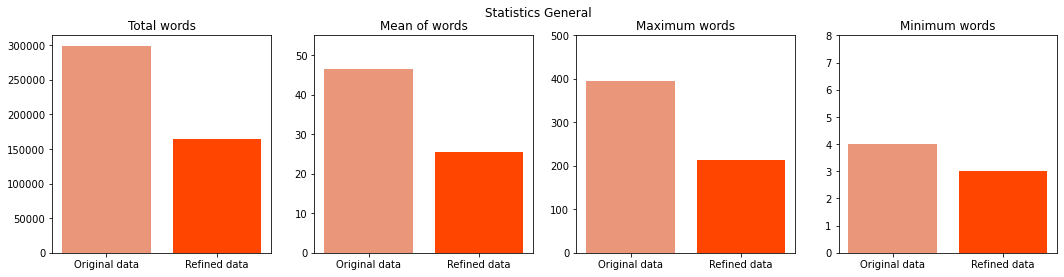

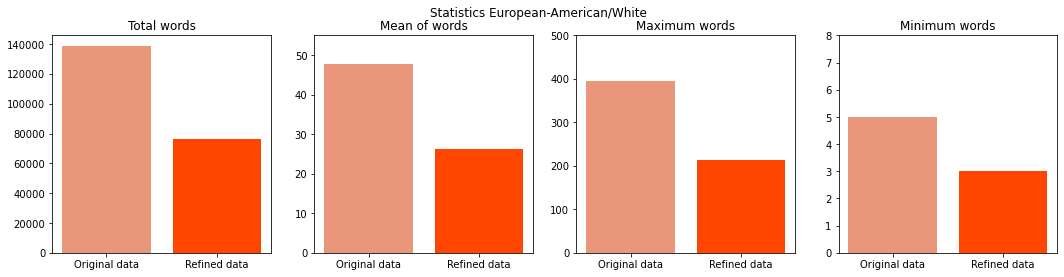

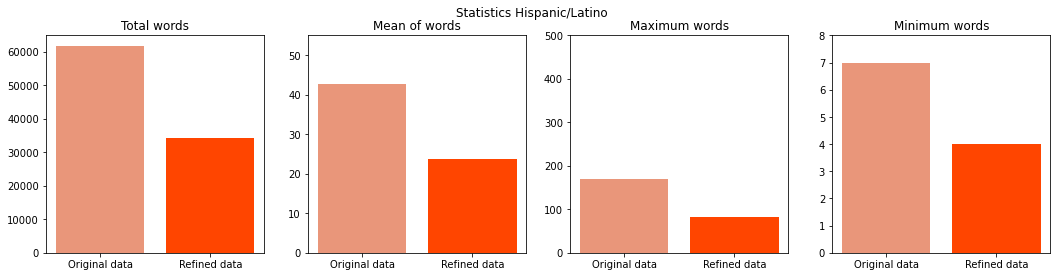

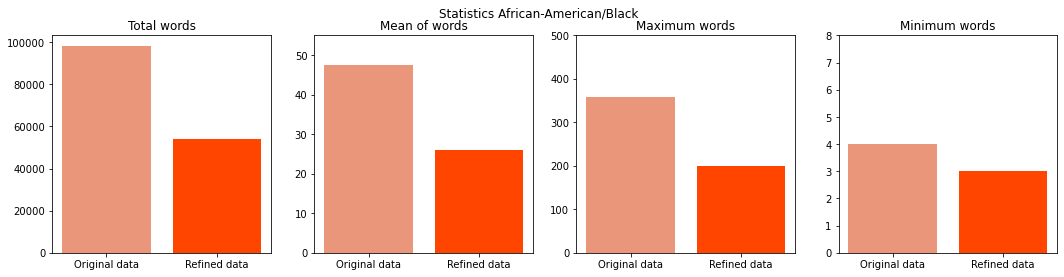

In [14]:
'Plots for general statistics'
plotstatistics(criminali_refined, 'General')

for i in range(len(list(set(criminali_refined['Race'])))):
    plotstatistics(criminali_refined[criminali_refined['Race'] == list(set(criminali_refined['Race']))[i]], list(set(criminali_refined['Race']))[i])

In [15]:
'''
From what we can immediately see, we cannot infer a particular result from this first statistic: average length of reports is
very similar across race. There is a difference in the longest report, but this can be also a randomic result. Interesting 
thing is that, after refining, mean number of words per report is more than halved.
'''

In [16]:
'''
Now we're interested in relative frequency per length of the report. In these plots, we'll show the relative frequency of a plot
with a determined length. In this way, we'll understand for which race police tends to make longer or shorter report.
'''

conto = {}

for j in list(set(criminali_refined['Race'])):
    conto[j] = {}
    a = list(criminali_refined[criminali_refined['Race'] == f'{j}']['count_desc_words'])
    
    for i in range(len(a)):
        if a[i] not in conto[j].keys():
            conto[j][a[i]] = (a.count(a[i]))
        else:
            continue

valori = [[(list(conto[j].values())[i]/np.sum(list(conto[j].values()))) for i in range(len(list(conto[j].values())))] for j in list(set(criminali_refined['Race']))]

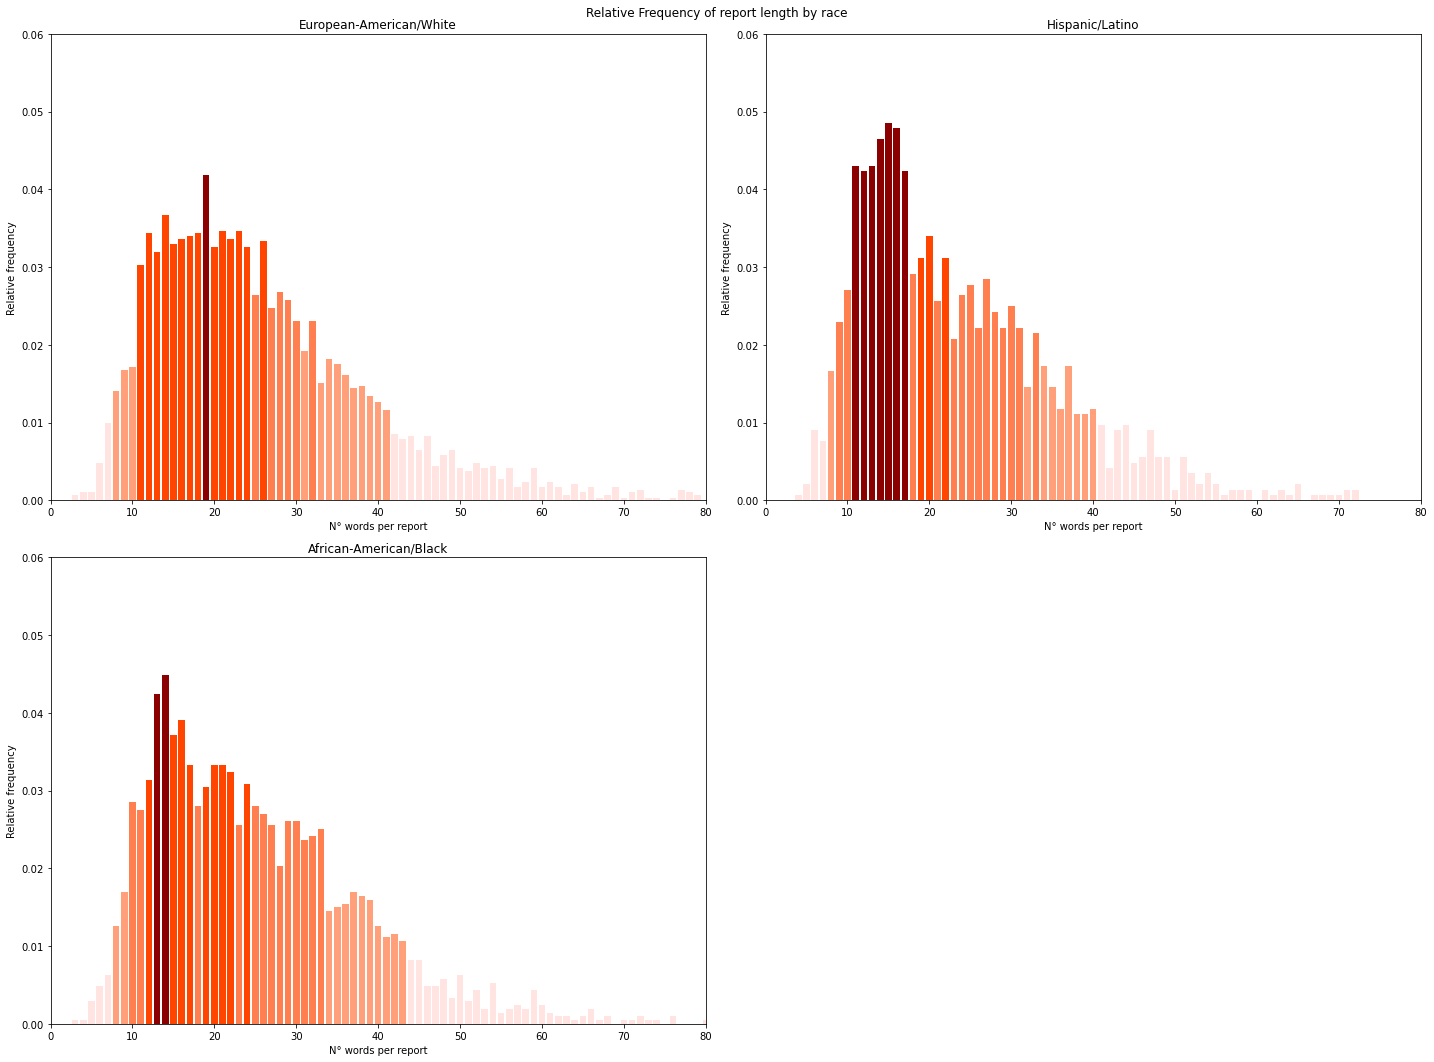

In [17]:
colors = [[] for i in range(len(valori))]

'The darker the color, the higher the relative frequency'

for j in range(len(valori)):
    for k in valori[j]:
        if k <= 0.01:
            colors[j].append('mistyrose')
        elif k > 0.01 and k <= 0.02:
            colors[j].append('lightsalmon')
        elif k > 0.02 and k <= 0.03:
            colors[j].append('coral')
        elif k > 0.03 and k <= 0.04:
            colors[j].append('orangered')
        elif k > 0.04:
            colors[j].append('darkred')
            
fig, axs = plt.subplots(2, 2, figsize=(20, 15), facecolor='w', edgecolor='k')
fig.suptitle('Relative Frequency of report length by race')
axs = axs.ravel()
a = ['tab:orange']
for j in range(len(valori)):
    axs[j].set_title(f'{list(conto.keys())[j]}')
    axs[j].bar(conto[list(conto.keys())[j]].keys(),valori[j], color = colors[j])
    axs[j].set_xlabel('N° words per report')
    axs[j].set_ylabel('Relative frequency')
    axs[j].set_ylim([0, 0.06])
    axs[j].set_xlim([0, 80])
fig.delaxes(axs[3])
fig.tight_layout(pad=1.0)

In [18]:
'''
We can see that the behaviour is pretty similar across races: after the refinement, most of the regions tend to have the
highest relative frequency between len = 10 and len = 20. Interesting is the fact that after len = 40 and below len = 8, the
trend is mostly the same.
'''

In [19]:
'''
Now we take a look at the most common UNIGRAMS and BIGRAMS, firstly taking a look at general original data and general refined
data, and then going in depth into regions, in order to understand which were the most common UNIGRAMS and BIGRAMS in each 
of the analyzed races.
'''

'UNIGRAMS'
tokens_original = [[token.text for token in nlp(report)] for report in criminali_refined['Description_orig']]
tokens_refined = [[token.text for token in nlp(report)] for report in criminali_refined['Desc']]

tokenizz1 = [item for sublist in tokens_original for item in sublist if item != ' ' and item != '' and item != '#']
tokenizz2 = [item for sublist in tokens_refined for item in sublist if item != ' ']

'BIGRAMS'
count1 = CountVectorizer(ngram_range=(2,2))
trasf = count1.fit_transform(criminali_refined['Desc'])
REFINED_BIG = dict(sorted(dict(zip(count1.get_feature_names(),trasf.toarray().sum(axis=0))).items(), key=lambda item: item[1], reverse = True))
count2 = CountVectorizer(ngram_range=(2,2))
orig = count2.fit_transform(criminali_refined['Description_orig'])
ORIG_BIG = dict(sorted(dict(zip(count2.get_feature_names(),orig.toarray().sum(axis=0))).items(), key=lambda item: item[1], reverse = True))

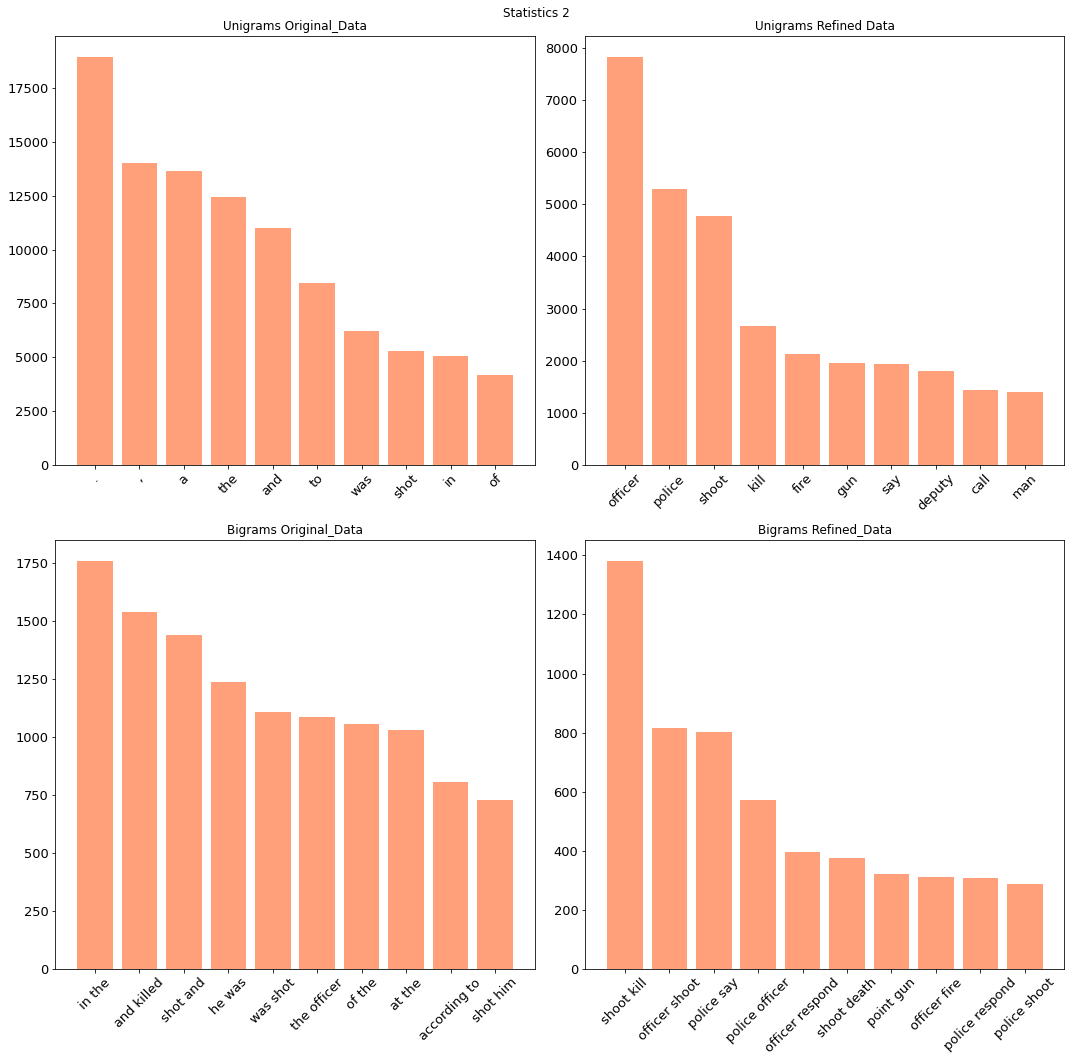

In [20]:
'''
Top 10 UNIGRAMS and BIGRAMS plots. If the color of the bar is darker, it means that the word is in common between the plot
for refined and original data
'''

fig, axs = plt.subplots(2, 2, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.suptitle('Statistics 2')
axs = axs.ravel()
a = ['tab:orange']

colors1 = []
colors2 = []

for i in range(10):
    if (Counter(tokenizz1).most_common(10)[i][0] not in [j[0] for j in Counter(tokenizz2).most_common(10)]) == True:
        colors1.append('lightsalmon')
    elif (Counter(tokenizz1).most_common(10)[i][0] in [j[0] for j in Counter(tokenizz2).most_common(10)]) == True:
        colors1.append('red')
for i in range(10):
    if (Counter(tokenizz2).most_common(10)[i][0] not in [j[0] for j in Counter(tokenizz1).most_common(10)]) == True:
        colors2.append('lightsalmon')
    elif (Counter(tokenizz2).most_common(10)[i][0] in [j[0] for j in Counter(tokenizz1).most_common(10)]) == True:
        colors2.append('red')

ax = axs[0]
for i in range(2):
    ax.set_title('Unigrams Original_Data')
    ax.bar([i[0] for i in Counter(tokenizz1).most_common(10)],[i[1] for i in Counter(tokenizz1).most_common(10)], color = colors1)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
ax = axs[1]
for i in range(2):
    ax.set_title('Unigrams Refined Data')
    ax.bar([i[0] for i in Counter(tokenizz2).most_common(10)],[i[1] for i in Counter(tokenizz2).most_common(10)], color = colors2)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
ax = axs[2]
for i in range(10):
    ax.set_title('Bigrams Original_Data')
    ax.bar(list(ORIG_BIG.items())[i][0],list(ORIG_BIG.items())[i][1], color = colors1[0])
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
ax = axs[3]
for i in range(10):
    ax.set_title('Bigrams Refined_Data')
    ax.bar(list(REFINED_BIG.items())[i][0],list(REFINED_BIG.items())[i][1], color = colors2[0])
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
fig.tight_layout()

In [21]:
'''
From what we can immediately see, there are no common tokens between unigrams and bigrams pre and post refining. The only
similar words in the UNIGRAM part are SHOOT and SHOT, but we were expecting something like this: all the reports talk about
a gunshot, as we said before. Very interesting is the fact that the 5th most common bigram after refining is 'officer respond':
this means that the fact that police officers have to respond fire of the killed guy is very common in reports of fatalities.
'''

In [22]:
'''
Now we're taking a look at the absolute frequency of unigrams for each race. If the color of a bar is clear, it means that the
word is in the top 10 of most used words even for another race. This means that the interesting columns are the darker ones.
'''

A = {}
B = {}

for i in range(len(list(set(criminali_refined['Race'])))):
    cv = [[] for i in range(len(list(set(criminali_refined['Race']))))]
    cv_fit = [[] for i in range(len(list(set(criminali_refined['Race']))))]
    cv[i].append(CountVectorizer())   
    cv_fit[i].append(cv[i][0].fit_transform(criminali_refined[criminali_refined['Race'] == list(set(criminali_refined['Race']))[i]]['Desc'][:]))
    A[list(set(criminali_refined['Race']))[i]] = dict(sorted(dict(zip(cv[i][0].get_feature_names(),cv_fit[i][0].toarray().sum(axis=0))).items(), key=lambda x: x[1], reverse=True))

for i in A.keys():
    B[i] = dict(zip(list(A[i].keys())[:10],list(A[i].values())[:10]))

In [23]:
'Let s create a list of common keys'

common_keys = []
for j in B.keys():
    for k in B[j].keys():
        common_keys.append(k)
        
d = [(i,common_keys.count(i)) for i in common_keys]

COMUNI = [list(set(d))[i][0] for i in range(len(list(set(d)))) if list(set(d))[i][1] > 1]

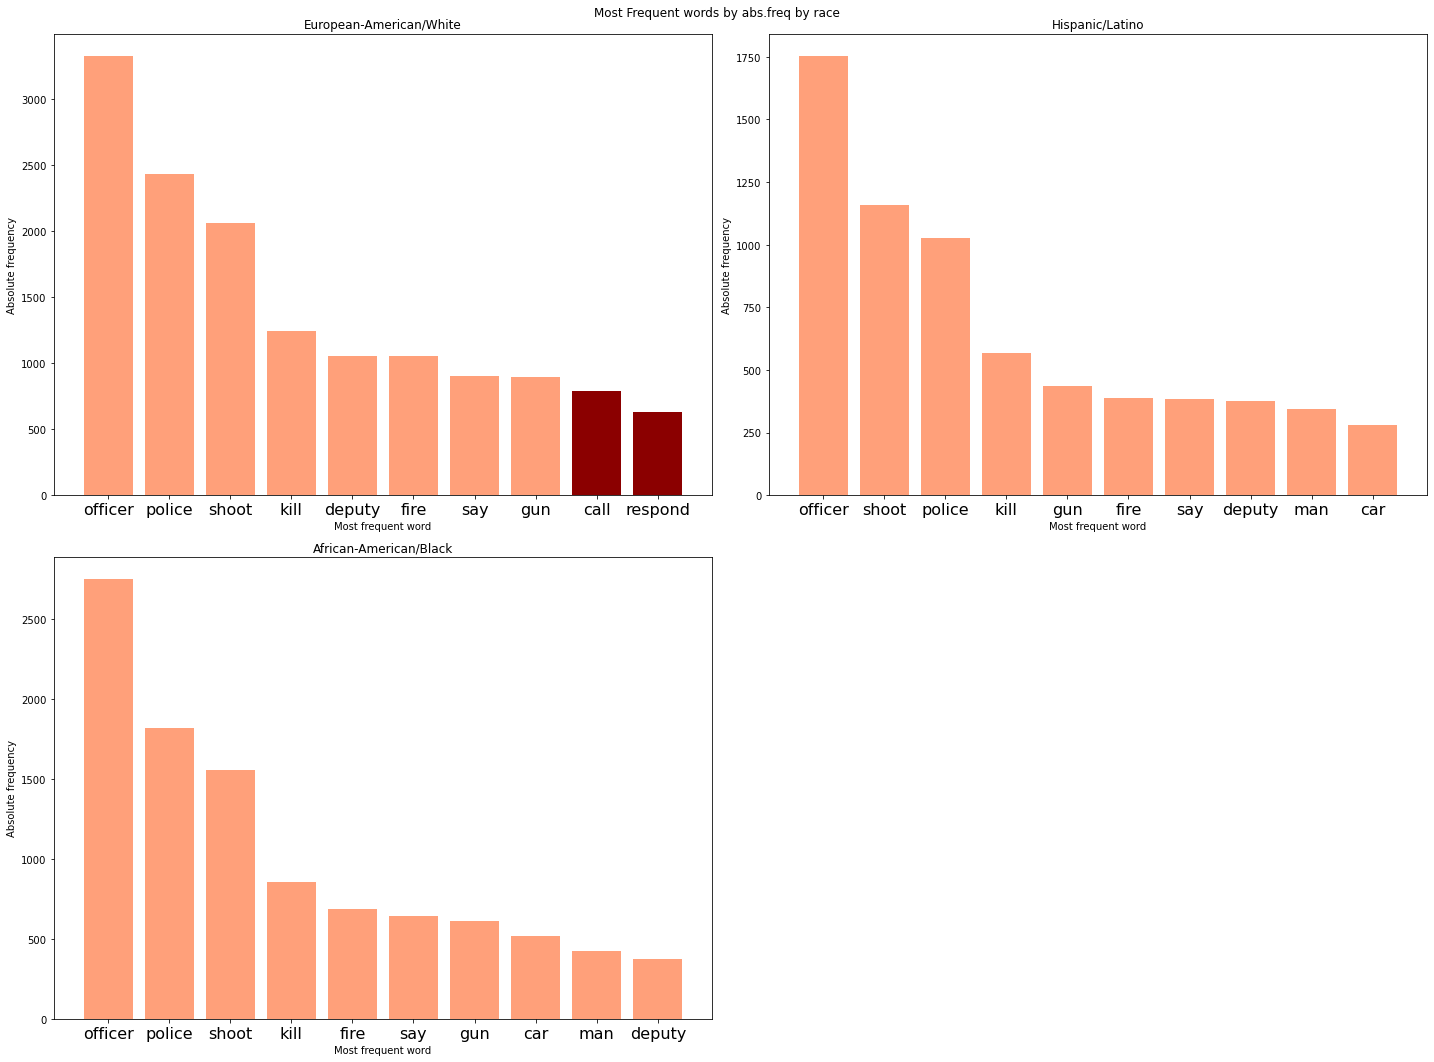

In [24]:
'''
Plot for absolute frequency of most common unigrams for each race. If the color of a bar is clearer, than it means that
that word appears just in the top 10 of that race, and in none of the others.
'''

colors1 = [[] for i in range(len(valori))]

for j in range(len(list(B.keys()))):
    for k in B[list(B.keys())[j]].keys():
        if k in COMUNI:
            colors1[j].append('lightsalmon')
        else:
            colors1[j].append('darkred')

fig, axs = plt.subplots(2, 2, figsize=(20, 15), facecolor='w', edgecolor='k')
fig.suptitle('Most Frequent words by abs.freq by race')
axs = axs.ravel()
a = ['tab:orange']
for j in range(len(valori)):
    axs[j].set_title(f'{list(B.keys())[j]}')
    axs[j].bar(B[list(B.keys())[j]].keys(),B[list(B.keys())[j]].values(), color = colors1[j])
    axs[j].set_xlabel('Most frequent word',fontsize=10)
    axs[j].set_ylabel('Absolute frequency',fontsize=10)
    axs[j].tick_params(axis='x', labelsize=16)
fig.delaxes(axs[3])
fig.tight_layout(pad=1.0)

In [25]:
'''
Again, we don't have very interesting results, since top 10 most common words basically repeat across races. Only two peculiar
results are 'call' and 'respond' for European-American/White. First 4 in the ranking are the same across each race, showing
that there is no difference in the basic approach to reports across races: probably these indicates that to discover a path
to understand the race of the killed guy we will have to take a look at words that appear less time, but that are specific
of the race.
'''

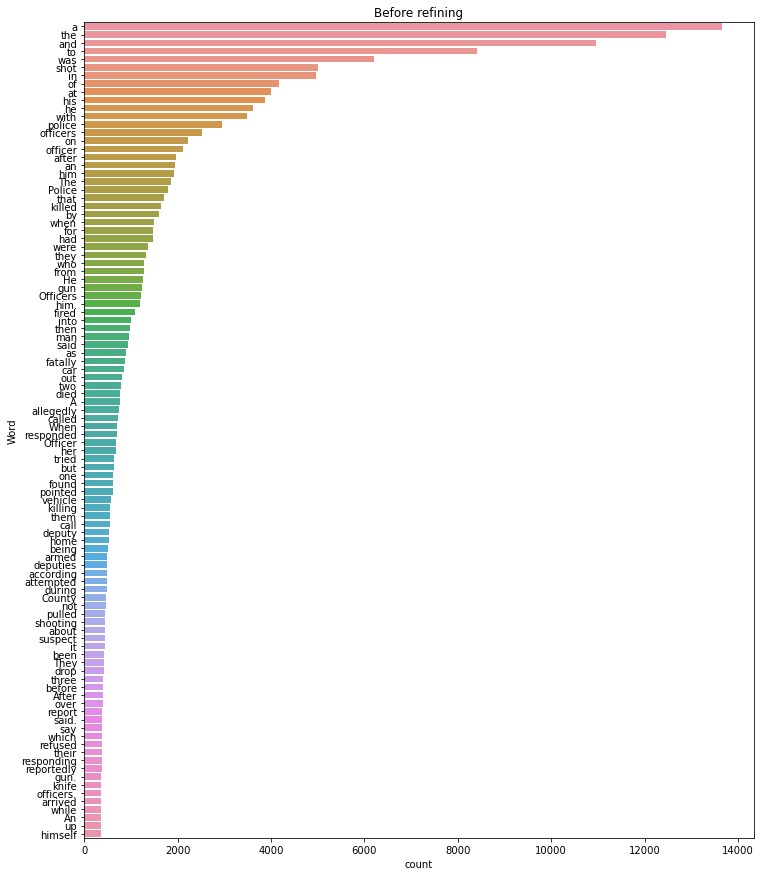

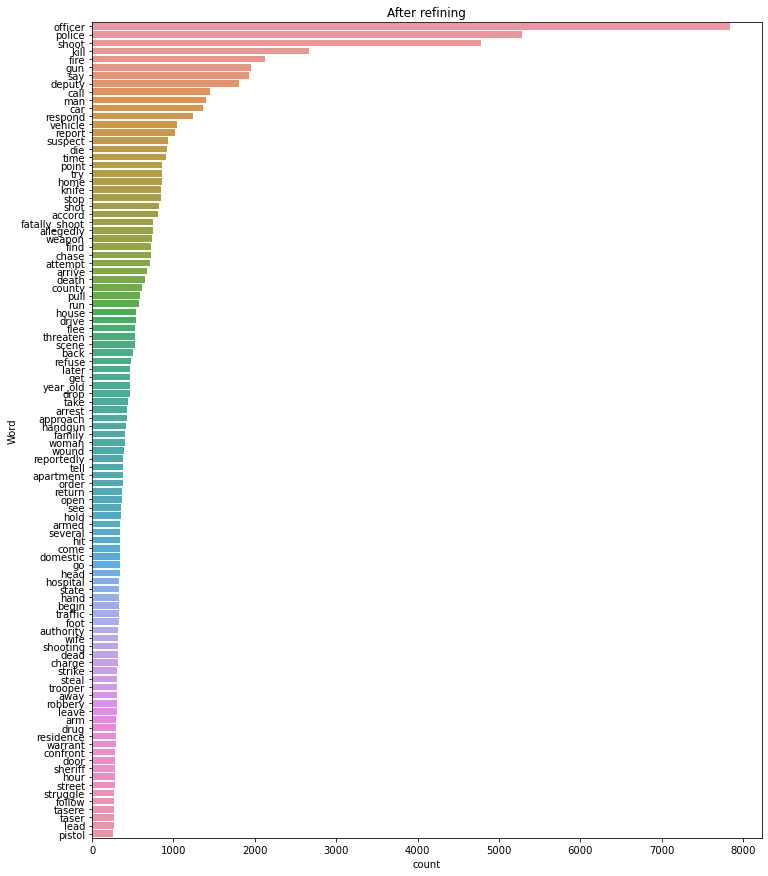

In [26]:
'''
Here, we plot the continuation of the precedent graph. We show first 100 words both pre and post refining, showing that
in our corpus Zipf law is respected.
'''

import seaborn as sb

def freq_words(title, x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    d = words_df.nlargest(columns="count", n = terms) 

    plt.figure(figsize=(12,15)) 
    ax = sb.barplot(data=d, x= "count", y = "word") 
    ax.set_title(f'{title}')
    ax.set(ylabel = 'Word') 
    plt.show()

freq_words('Before refining', criminali_refined['Description_orig'], 100)
freq_words('After refining', criminali_refined['Desc'], 100)

In [27]:
'''
This shows a pretty interesting result: we can see many words related to weapons in the plot for refined reports that 
actually do not appear in the plot for the original reports.
'''

### Topic Model

In [28]:
'''
Here, we build a topic model, in order to understand if there are different topics there are more/less discussed for the 
different races. We decided to remove most common words, in order to get more peculiar results.
'''
instances = criminali_refined['Desc'].apply(str.split).tolist()
instances = [[w for w in sentence if w not in 'police shoot kill say man deputy trooper authority'.split()] for sentence in instances]
print("creating dictionary", flush=True)

phrases = Phrases(instances, min_count=5, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)

dictionary.filter_extremes(no_below=80, no_above=0.3)
print(dictionary, flush=True)

creating dictionary
Dictionary(218 unique tokens: ['chase', 'armed', 'city', 'claim', 'shot']...)


In [29]:
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]

print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)

model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [30]:
'''
Here we built a class for the topic model, in order to ease our work.
'''

class Topic_choice:
    
    def __init__(self, data, target_category = ''):        
        self.coherence_values = []
        self.descriptors = []
        self.dictionary = None
        self.lda_corpus = None
        self.topic_corpus = None
        self.target_category = target_category
        self.author_model_list = []
        self.model_name = ''
        self.author2doc = None
        self.author_corpus = None
        self.data = data

    def LDA_topic_num_score(self, lda_corpus, min_num, max_num, instances, dictionary, limit=None):
        """
        Print coherence score of LDA for each number of topics
        Parameters:
            - model_corpus
            - minimun number of topics
            - maximum number of topics
            - instances
            - dictionary
        """
        if limit is None:
            limit = len(instances)//10
        self.lda_corpus = lda_corpus
        self.dictionary = dictionary
        self.coherence_values = []
        self.model_name = 'LdaMulticore'
        for num_topics in range(min_num, max_num+1):

            model = LdaMulticore(corpus=lda_corpus[:limit], 
                         id2word=dictionary, 
                         num_topics=num_topics, 
                         random_state=42)

            coherencemodel_umass = CoherenceModel(model=model, 
                                                  texts=instances[:limit], 
                                                  dictionary=dictionary, 
                                                  coherence='u_mass')

            coherencemodel_cv = CoherenceModel(model=model, 
                                               texts=instances[:limit], 
                                               dictionary=dictionary, 
                                               coherence='c_v')

            umass_score = coherencemodel_umass.get_coherence()
            cv_score = coherencemodel_cv.get_coherence()

            print(num_topics, umass_score, cv_score)
            self.coherence_values.append((num_topics, umass_score, cv_score))
    
    def Author_topic_num_score(self, author_corpus, min_num, max_num, instances, dictionary, limit=None):
        """
        Print coherence score of Author Topic Model for each number of topics
        Parameters:
            - author_corpus
            - minimun number of topics
            - maximum number of topics
            - instances
            - dictionary
            - limit (default to len(author_corpus))
        """
        self.author_corpus = author_corpus
        self.dictionary = dictionary
        self.coherence_values = []
        self.model_name =  'AuthorTopicModel'
        
        if limit is None:
            limit = len(instances)//10
        
        author2doc = defaultdict(list) 
        for i, group in enumerate(self.data[self.target_category][:limit]):
            author2doc[group].append(i)
            
        dev_author2doc = {key: [idx for idx in value if idx < limit] for key, value in author2doc.items()}
        
        for num_topics in range(min_num, max_num+1):
            
            author_model = AuthorTopicModel(corpus=author_corpus[:limit], 
                                            author2doc=dev_author2doc, 
                                            id2word=dictionary,
                                            alpha=0.5,
                                            num_topics=num_topics,
                                            random_state=23
                                           )

            coherencemodel_umass = CoherenceModel(model=author_model, 
                                                  texts=instances[:limit], 
                                                  dictionary=dictionary, 
                                                  coherence='u_mass')

            coherencemodel_cv = CoherenceModel(model=author_model, 
                                               texts=instances[:limit], 
                                               dictionary=dictionary, 
                                               coherence='c_v')

            umass_score = coherencemodel_umass.get_coherence()
            cv_score = coherencemodel_cv.get_coherence()

            print(num_topics, umass_score, cv_score)
            self.coherence_values.append((num_topics, umass_score, cv_score))

    def plot_coherence(self, coherence_values=None):
        """
        Plot coherence score for each number of topics. 
        Parameters: coherence_values. 
        """
        if coherence_values is None:
            coherence_values = self.coherence_values
            
        scores = pd.DataFrame(self.coherence_values, columns=['num_topics', 'UMass', 'CV'])
        sb.set_context('poster')
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
        scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=np.array(scores.num_topics))
        scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=np.array(scores.num_topics))
        sb.reset_orig()

In [31]:
class Topic_model(Topic_choice):

    def __init__(self, data, groups):
        super().__init__(data)
        self.groups = groups 
        self.topic_num = 6 
        self.model = None
        self.author_descriptors = []     
        self.author_vecs = []
 
    def fit_LDA(self, lda_corpus=None, num_topics=None, dictionary=None, **kwargs):     
        """
        Fit LDA to a given corpus.
        Parameters:
            - model_corpus
            - num_topics 
            - dictionary
        """      
        if lda_corpus is None:
            lda_corpus = self.lda_corpus
        else:
            self.lda_corpus = lda_corpus
        if num_topics is None:
            num_topics = self.topic_num
        else:
            self.topic_num = num_topics
        if dictionary is None:
            dictionary = self.dictionary
        else:
            self.dictionary = dictionary
        if self.target_category == '':
            self.target_category = kwargs['target_category']
            
        num_passes = 10
        chunk_size = len(lda_corpus) * num_passes/200
        
        self.model = LdaMulticore(num_topics=num_topics, 
                             corpus=lda_corpus, 
                             id2word=dictionary, 
                             workers=min(10, multiprocessing.cpu_count()-1),
                             passes=num_passes, 
                             chunksize=chunk_size,
                             alpha=0.5,
                             random_state=23
                            )
        self.topic_corpus = self.model[lda_corpus]
        self.model_name = 'LDA'
        
    def fit_AuthorTopicModel(self, author_corpus=None, num_topics=None, dictionary=None, **kwargs):    
        """
        Fit AuthorTopicModel to a given corpus.
        Parameters:
            - author_corpus
            - num_topics 
            - dictionary
        Optional:
            - target_category (if not defined in topic choice step)
        """        
        if author_corpus is None:
            author_corpus = self.author_corpus
        else: 
            self.author_corpus = author_corpus
        if num_topics is None:
            num_topics = self.topic_num
        else:
            self.topic_num = num_topics
        if dictionary is None:
            dictionary = self.dictionary
        else:
            self.dictionary = dictionary
        if self.target_category == '':
            self.target_category = kwargs['target_category']
        if self.author2doc is None:
            author2doc = defaultdict(list) 
            for i, group in enumerate(self.data[self.target_category]):
                author2doc[group].append(i)
        else:
            author2doc = self.author2doc

        num_passes = 10
        chunk_size = len(author_corpus) * num_passes/200

        self.model = AuthorTopicModel(corpus=author_corpus, 
                                        author2doc=author2doc, 
                                        id2word=dictionary, 
                                        num_topics=num_topics,
                                        passes=num_passes,
                                        chunksize=chunk_size,
                                        alpha=0.5,
                                        random_state=23
        )
        self.model_name = 'ATM'
        
    def topic_description(self):
        
        """
        Print most infomartive words for each topic
        """
        
        topic_sep = re.compile("0\.[0-9]{3}\*")
        model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                        for topic_no, model_topic in
                        self.model.print_topics(num_topics=self.topic_num, num_words=10)]
        self.descriptors = []
        for i, m in sorted(model_topics):
            print(i+1, ", ".join(m[:10]))
            self.descriptors.append(", ".join(m[:3]).replace('"', '')) # this is different 

    def plot_topics_distribution(self, groups=None, limit=None, topic_corpus=None):
        
        if groups is None:
            groups = self.groups
        if self.model_name == 'LDA':
            if limit is None:
                limit = len(self.topic_corpus)
            if topic_corpus is None:
                topic_corpus = self.topic_corpus            
            scores = [[t[1] for t in self.topic_corpus[entry]] for entry in range(limit)]
            topic_distros = pd.DataFrame(data=scores, columns=self.descriptors)
            topic_distros['category'] = self.data[self.target_category][:limit]

            aggregate_by_category = topic_distros[topic_distros.category.isin(groups)]
            aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()
            
            sb.set_context('poster')

            fig, ax = plt.subplots(figsize=(20,10))
            aggregate_by_category[self.descriptors].plot.bar(ax=ax, alpha=0.9)
            
            plt.title(self.model_name + ' topic destribution', size=16)
            plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=16)
            plt.xticks(rotation=45, size = 16)
            plt.yticks(size = 16)
        
            sb.reset_orig()
        
        if self.model_name == 'ATM':
            author_vecs = {author: {self.descriptors[t]: 0.0
                                     for t in range(self.model.num_topics)}
                          for author in self.model.id2author.values()
                          }
            for author in self.model.id2author.values():
                for (t, v) in self.model.get_author_topics(author):
                    author_vecs[author][self.descriptors[t]] = v
            self.author_vecs = author_vecs
            author_df = pd.DataFrame.from_dict(author_vecs)
            sb.set_context('poster')
            fig, ax = plt.subplots(figsize=(20,10))
            author_df[groups].T.plot.bar(ax=ax, alpha=0.9)
            plt.title('Topic destribution with author topic modeling', size=20)
            plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=16);
            plt.xticks(rotation=45, size = 14)
            plt.yticks(size = 14)            
            sb.reset_orig()

In [32]:
'''
Let's see best number of topics
'''
cp = Topic_choice(criminali_refined)
cp.LDA_topic_num_score(lda_corpus=model_corpus, min_num=3, max_num=14, instances=instances, 
                       dictionary=dictionary, limit=len(instances))

3 -2.389944235138259 0.32018074906199545
4 -2.34276735285745 0.31415507096585366
5 -2.435467925901128 0.3351198800959672
6 -2.3601805244744996 0.3040915747308766
7 -2.3882754730077345 0.3354263360380096
8 -2.3117475050351377 0.3108395047644904
9 -2.2714426256165687 0.34826141470042543
10 -2.315531052512617 0.33291468376174105
11 -2.2955979456359863 0.3356317738431742
12 -2.2987451122492986 0.32631576990529904
13 -2.269712188198827 0.32232251852415933
14 -2.316487088367281 0.32785072640747115


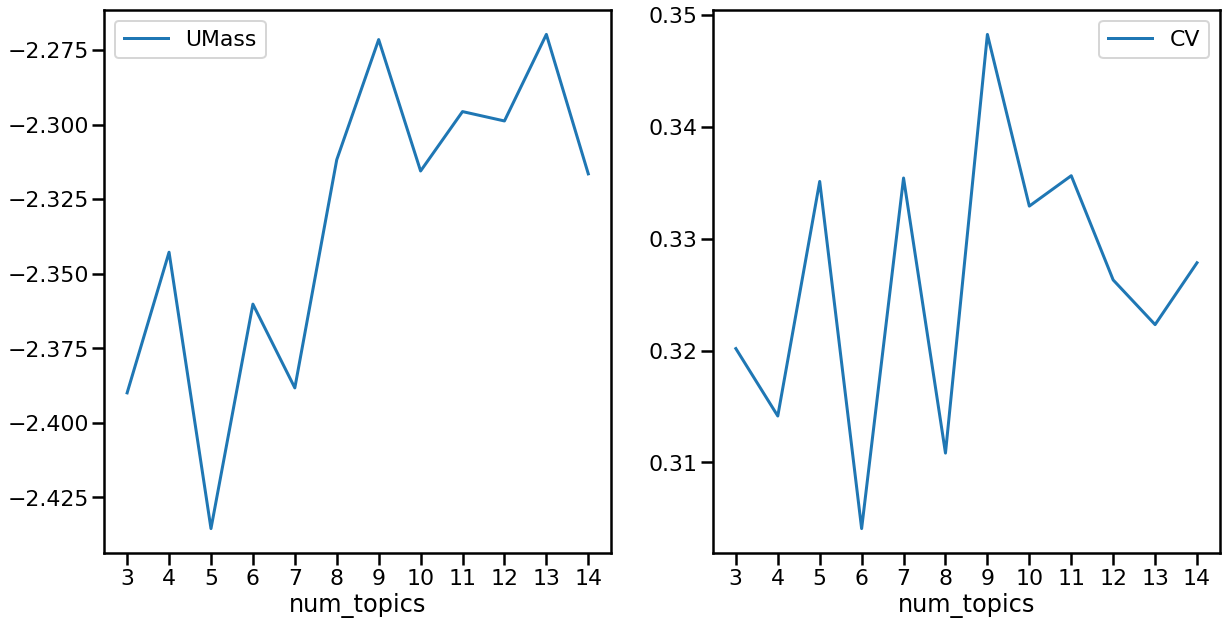

In [33]:
'''
Plot of UMass and CV, for the topic model
'''

cp.plot_coherence()

In [34]:
'''
We decide to go for a value that is a good compromise between UMass and CV score. We decide to go with 4 TOPICS.
'''
tm = Topic_model(data=criminali_refined, groups = 'African-American/Black European-American/White Hispanic/Latino'.split())
tm.fit_LDA(lda_corpus = ldacorpus, num_topics=4, dictionary=dictionary, target_category = 'Race')
tm.topic_description()

1 "die", "accord", "time", "county", "sheriff", "hospital", "arrest", "shooting", "report", "drug"
2 "gun", "respond", "call", "point", "weapon", "find", "report", "drop", "arrive", "refuse"
3 "fire", "knife", "home", "call", "threaten", "shot", "house", "apartment", "woman", "charge"
4 "car", "vehicle", "suspect", "fire", "stop", "chase", "pull", "run", "flee", "drive"


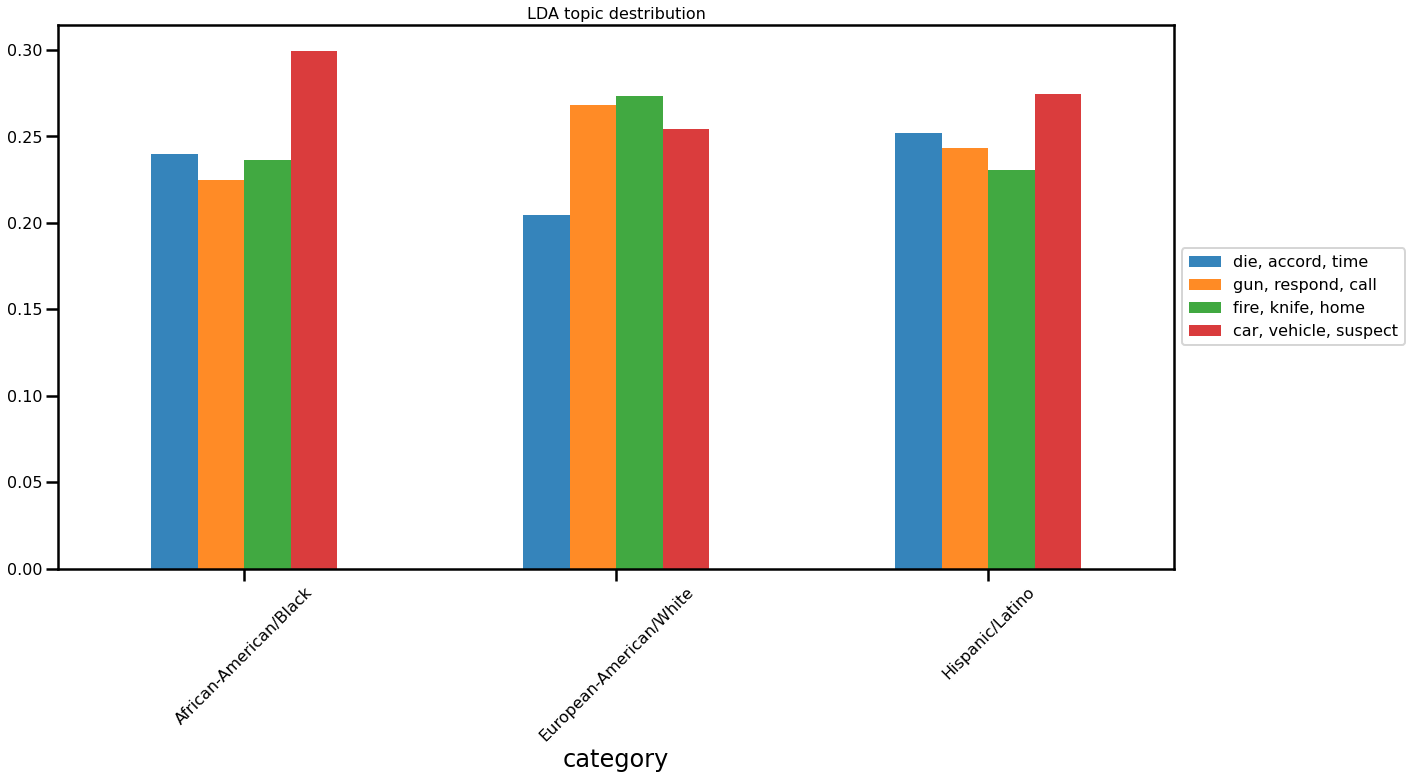

In [35]:
tm.plot_topics_distribution()

In [36]:
'''
As we can see from the Topic Model, results are not particularly good. There is not a dominant topic for each of the race, apart
for the "car, police, vehicle" in the African-American/Black race. For this reason, we decide to go also for an Author Topic
Model.
'''

In [37]:
cp1 = Topic_choice(criminali_refined, target_category = 'Race')
cp1.Author_topic_num_score(author_corpus=ldacorpus, min_num=3, max_num=14, instances=instances, 
                           dictionary=dictionary, limit=len(instances))

3 -2.119619732981158 0.3864897550452137
4 -2.22005064511419 0.3603200284371706
5 -2.2020018482310775 0.37076739182212093
6 -2.251980675404127 0.3925263928308311
7 -2.2613864573716587 0.3945154395773191
8 -2.272918216011999 0.3898815835855637
9 -2.281723603611315 0.39584352833913333
10 -2.2947904195549307 0.38969392509232026
11 -2.2772169956851225 0.39292464496953644
12 -2.312159021947681 0.39679760294316374
13 -2.3355979498492685 0.39687641802772394
14 -2.355048686758587 0.3932237925484085


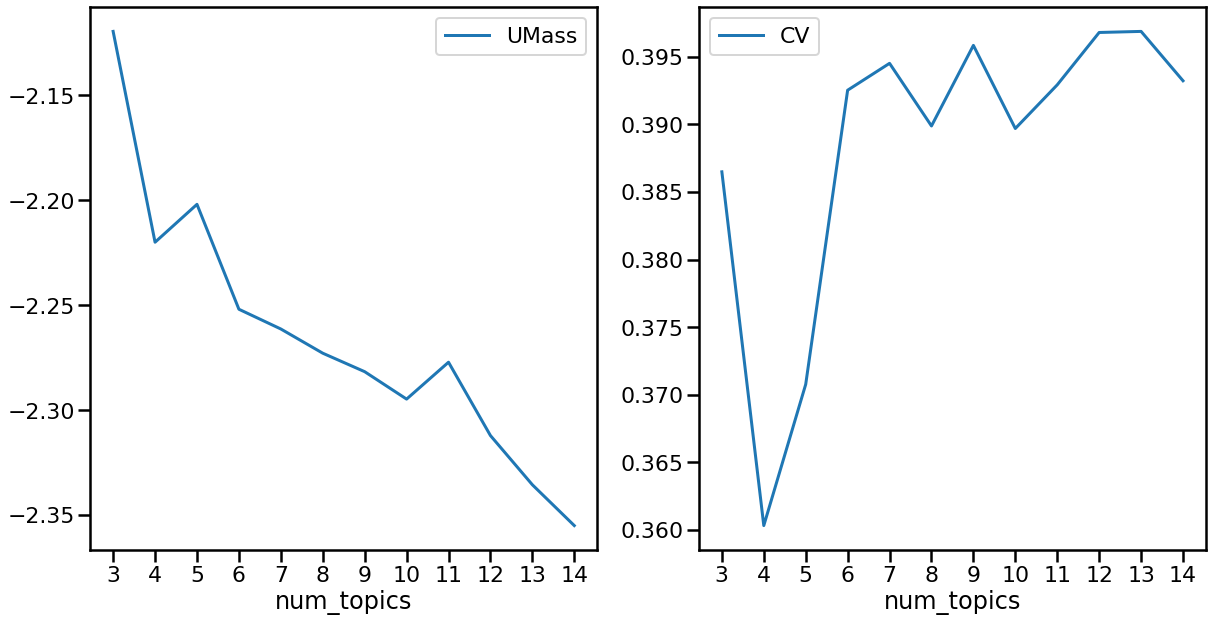

In [38]:
'''
Plot of UMass and CV, for the author topic model
'''

cp1.plot_coherence()

In [39]:
tm1 = Topic_model(data=criminali_refined, groups = 'African-American/Black European-American/White Hispanic/Latino'.split())
%time tm1.fit_AuthorTopicModel(author_corpus=ldacorpus, num_topics=5, dictionary=dictionary, target_category = 'Race')

tm1.topic_description()

Wall time: 1min 3s
1 "die", "accord", "time", "county", "hospital", "tasere", "report", "unarmed", "handcuff", "william"
2 "respond", "gun", "call", "drop", "order", "refuse", "residence", "knife", "fight", "allegedly"
3 "warrant", "home", "arm", "report", "several", "taser", "subject", "arrive", "make", "knife"
4 "car", "vehicle", "suspect", "stop", "drive", "chase", "attempt", "pull", "try", "foot"
5 "fire", "gun", "call", "fatally_shoot", "point", "shot", "house", "threaten", "weapon", "respond"


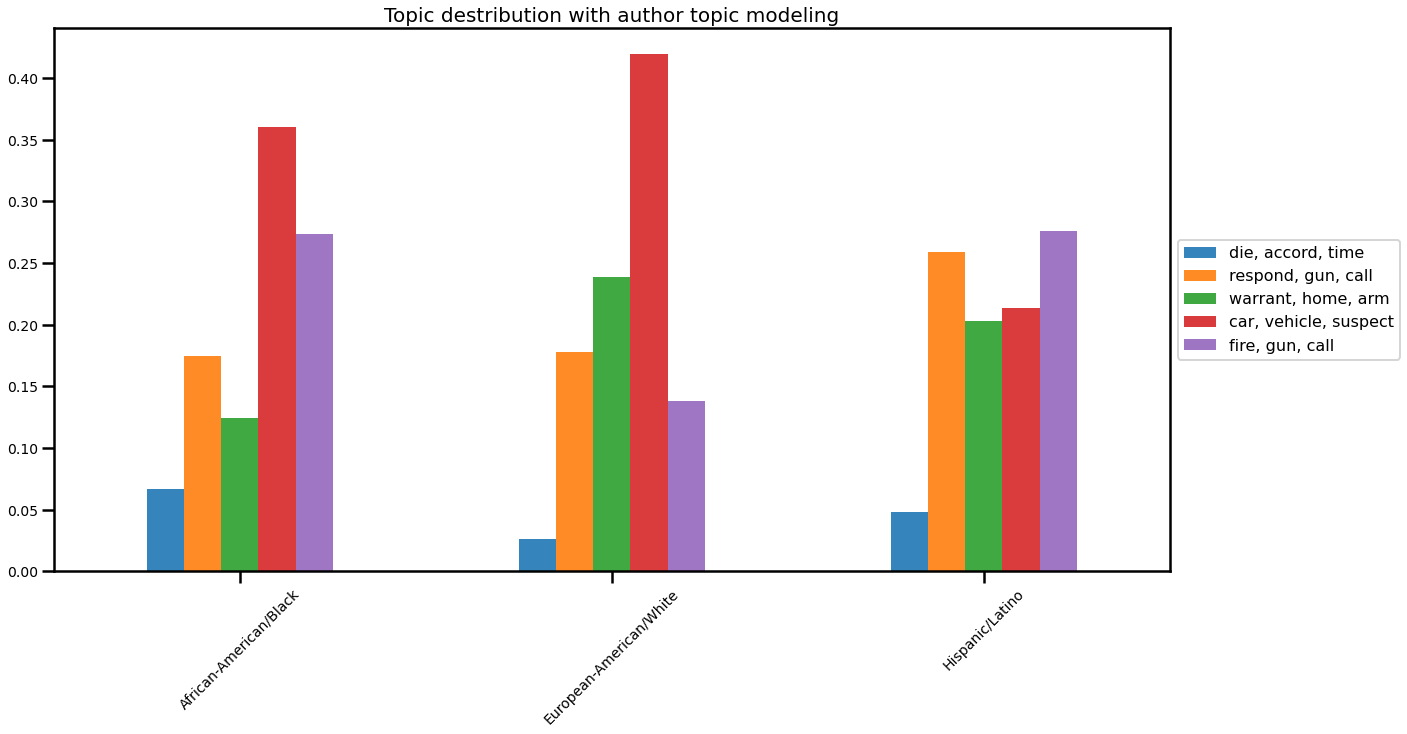

In [40]:
tm1.plot_topics_distribution()

In [41]:
'''
Here we have way more reliable and precise result: the topic "call, respond, home" appears to be dominant in the 
Hispanic/Latino race which means that these cases were often related to domestic violence. Instead, cases involving 
African-American/Black race are mostly connected to car chases and accidents. Drugs are more present in cases with 
European-American/White suspects. 
'''

In [42]:
'''
For each sentence in the corpus we find the topic with the highest probability based on the keywords of each topic
'''
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=tm.model, corpus=ldacorpus, texts=instances)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.6912,"car, vehicle, suspect, fire, stop, chase, pull...","[john, edward, pittman, officer, david, driske..."
1,1,2.0,0.4465,"fire, knife, home, call, threaten, shot, house...","[army, veteran, west, chester, university, stu..."
2,2,1.0,0.5228,"gun, respond, call, point, weapon, find, repor...","[want, murder, describe, member, aryan, brothe..."
3,3,2.0,0.4500,"fire, knife, home, call, threaten, shot, house...","[officer, year_old, miguel, peralta, torre, sh..."
4,4,3.0,0.7835,"car, vehicle, suspect, fire, stop, chase, pull...","[chp, officer, jose, daniel, gonzalez, alleged..."
5,5,0.0,0.4037,"die, accord, time, county, sheriff, hospital, ...","[chase, reno, lopez, apparently, intentionally..."
6,6,2.0,0.6117,"fire, knife, home, call, threaten, shot, house...","[mentally, ill, queen, slash, mother, apartmen..."
7,7,0.0,0.4999,"die, accord, time, county, sheriff, hospital, ...","[hedge, eat, almost, ounce, cocaine, stomach, ..."
8,8,0.0,0.5000,"die, accord, time, county, sheriff, hospital, ...","[officer, marcell, patterson, william, pappa, ..."
9,9,0.0,0.4070,"die, accord, time, county, sheriff, hospital, ...","[steal, van, ride, crash, chase, jersey, city,..."


In [43]:
'''
Here is the table of the most relevant words for each topic
'''
df_dominant_topic[['Dominant_Topic', 'Keywords']].drop_duplicates().sort_values('Dominant_Topic')

,Dominant_Topic,Keywords
5,0.0,"die, accord, time, county, sheriff, hospital, ..."
2,1.0,"gun, respond, call, point, weapon, find, repor..."
1,2.0,"fire, knife, home, call, threaten, shot, house..."
0,3.0,"car, vehicle, suspect, fire, stop, chase, pull..."


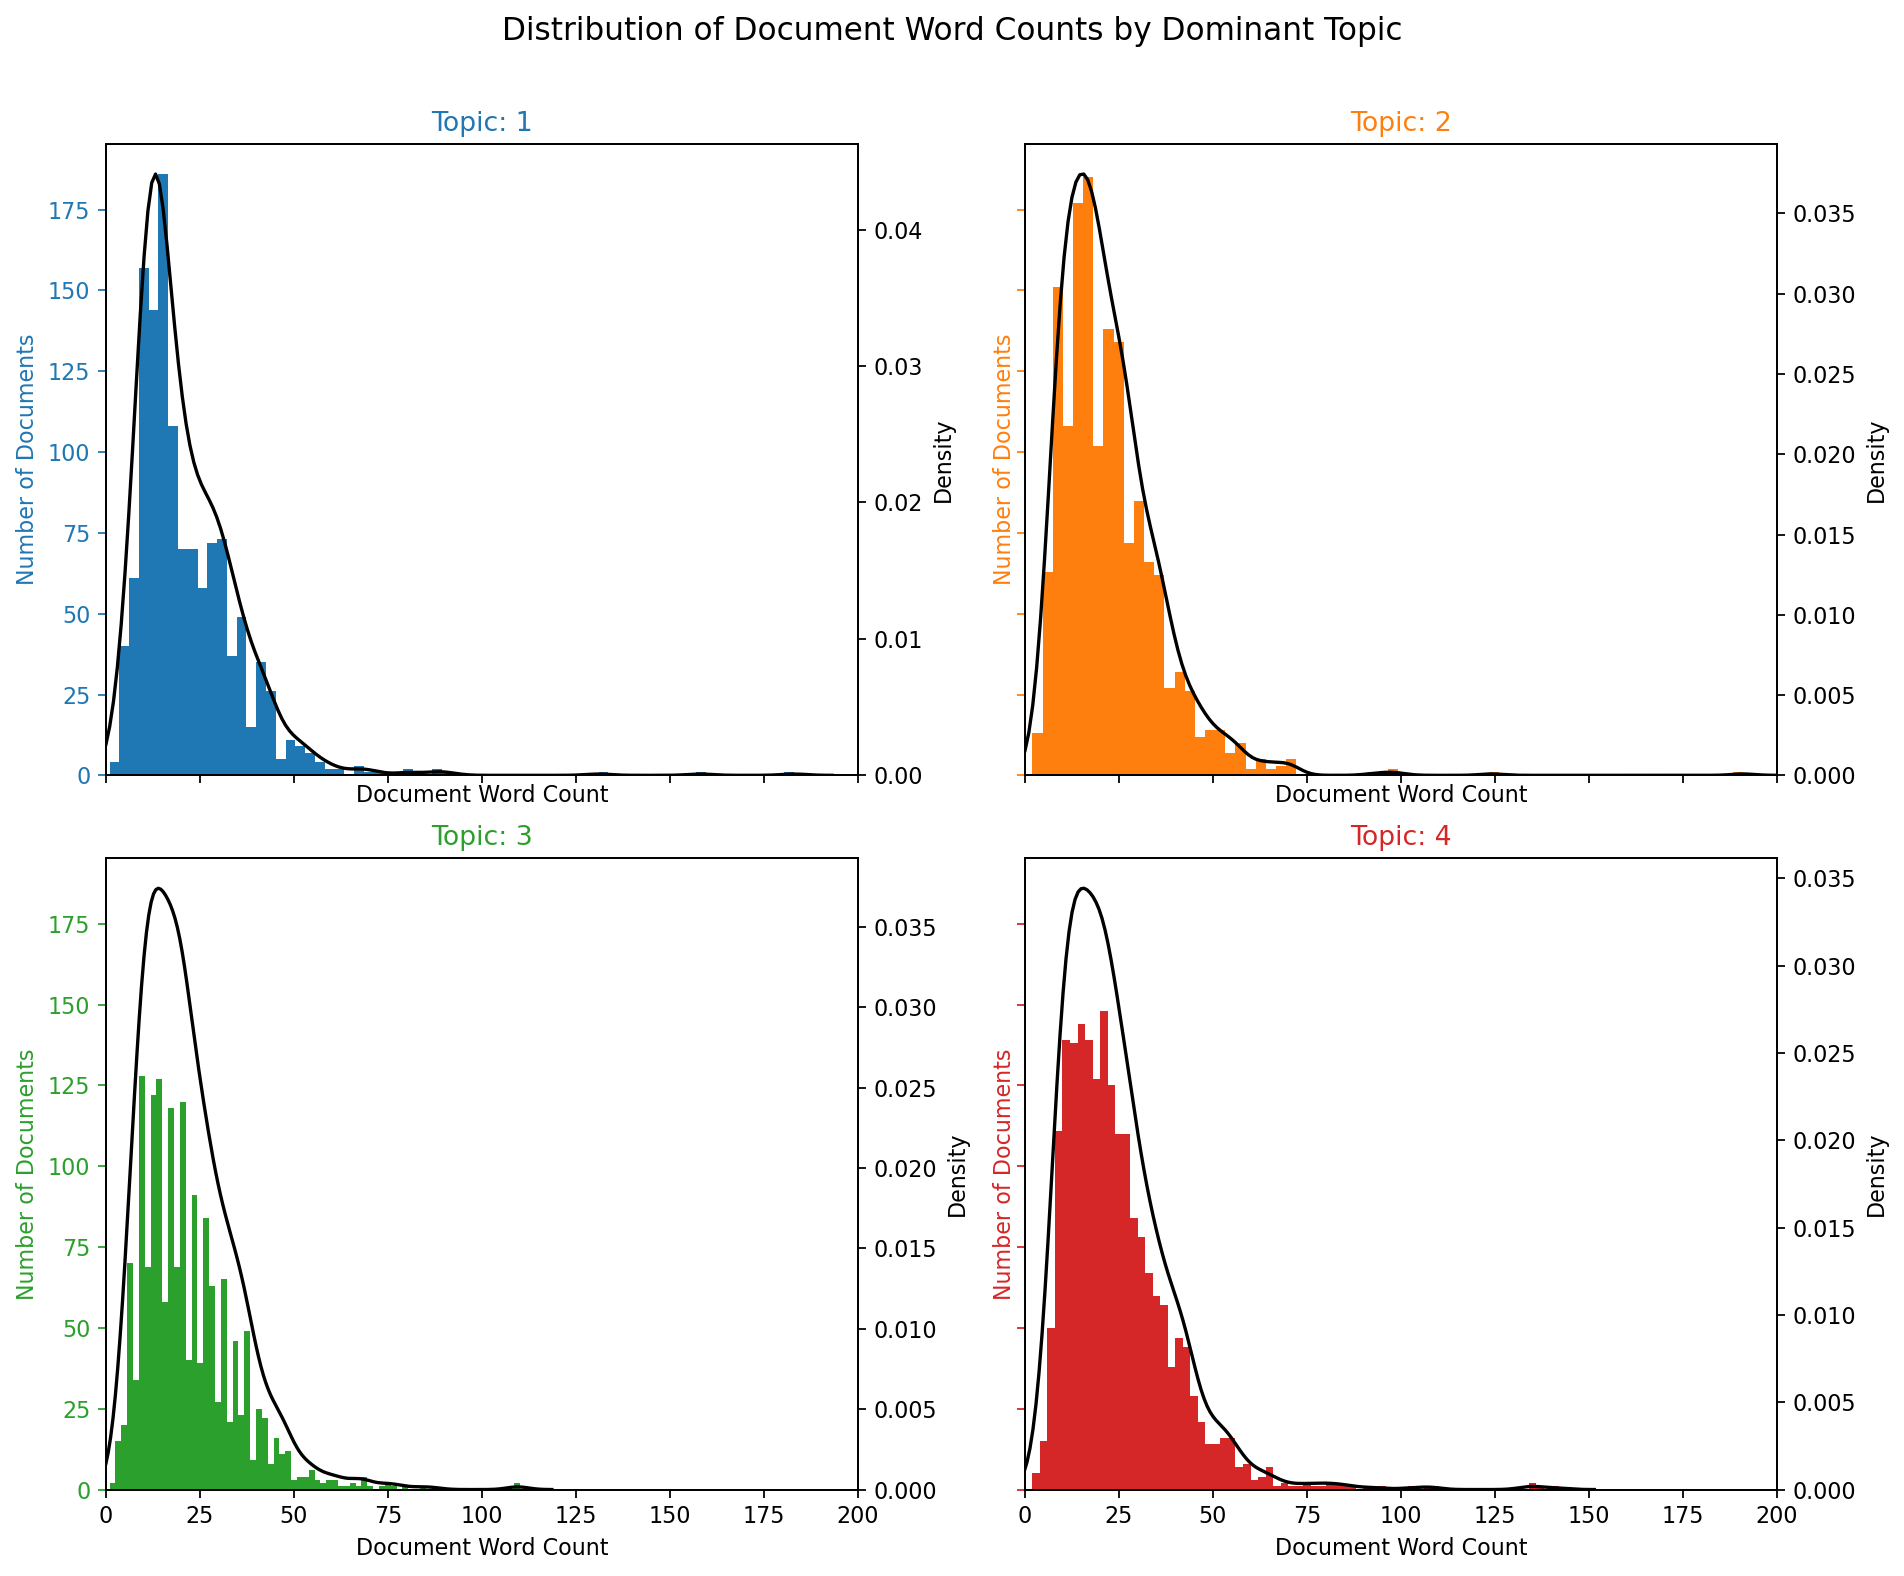

In [44]:
'''
We are also interested in how big are the topics in our corpus both in terms of document frequency and the length of the 
relevant documents. Here we see that documents have similar length across topics and that the most popular topic is the 
first one.  
'''
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(12,10), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 70, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sb.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 200), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i+1), fontdict=dict(size=12, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,200,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=14)
plt.show()

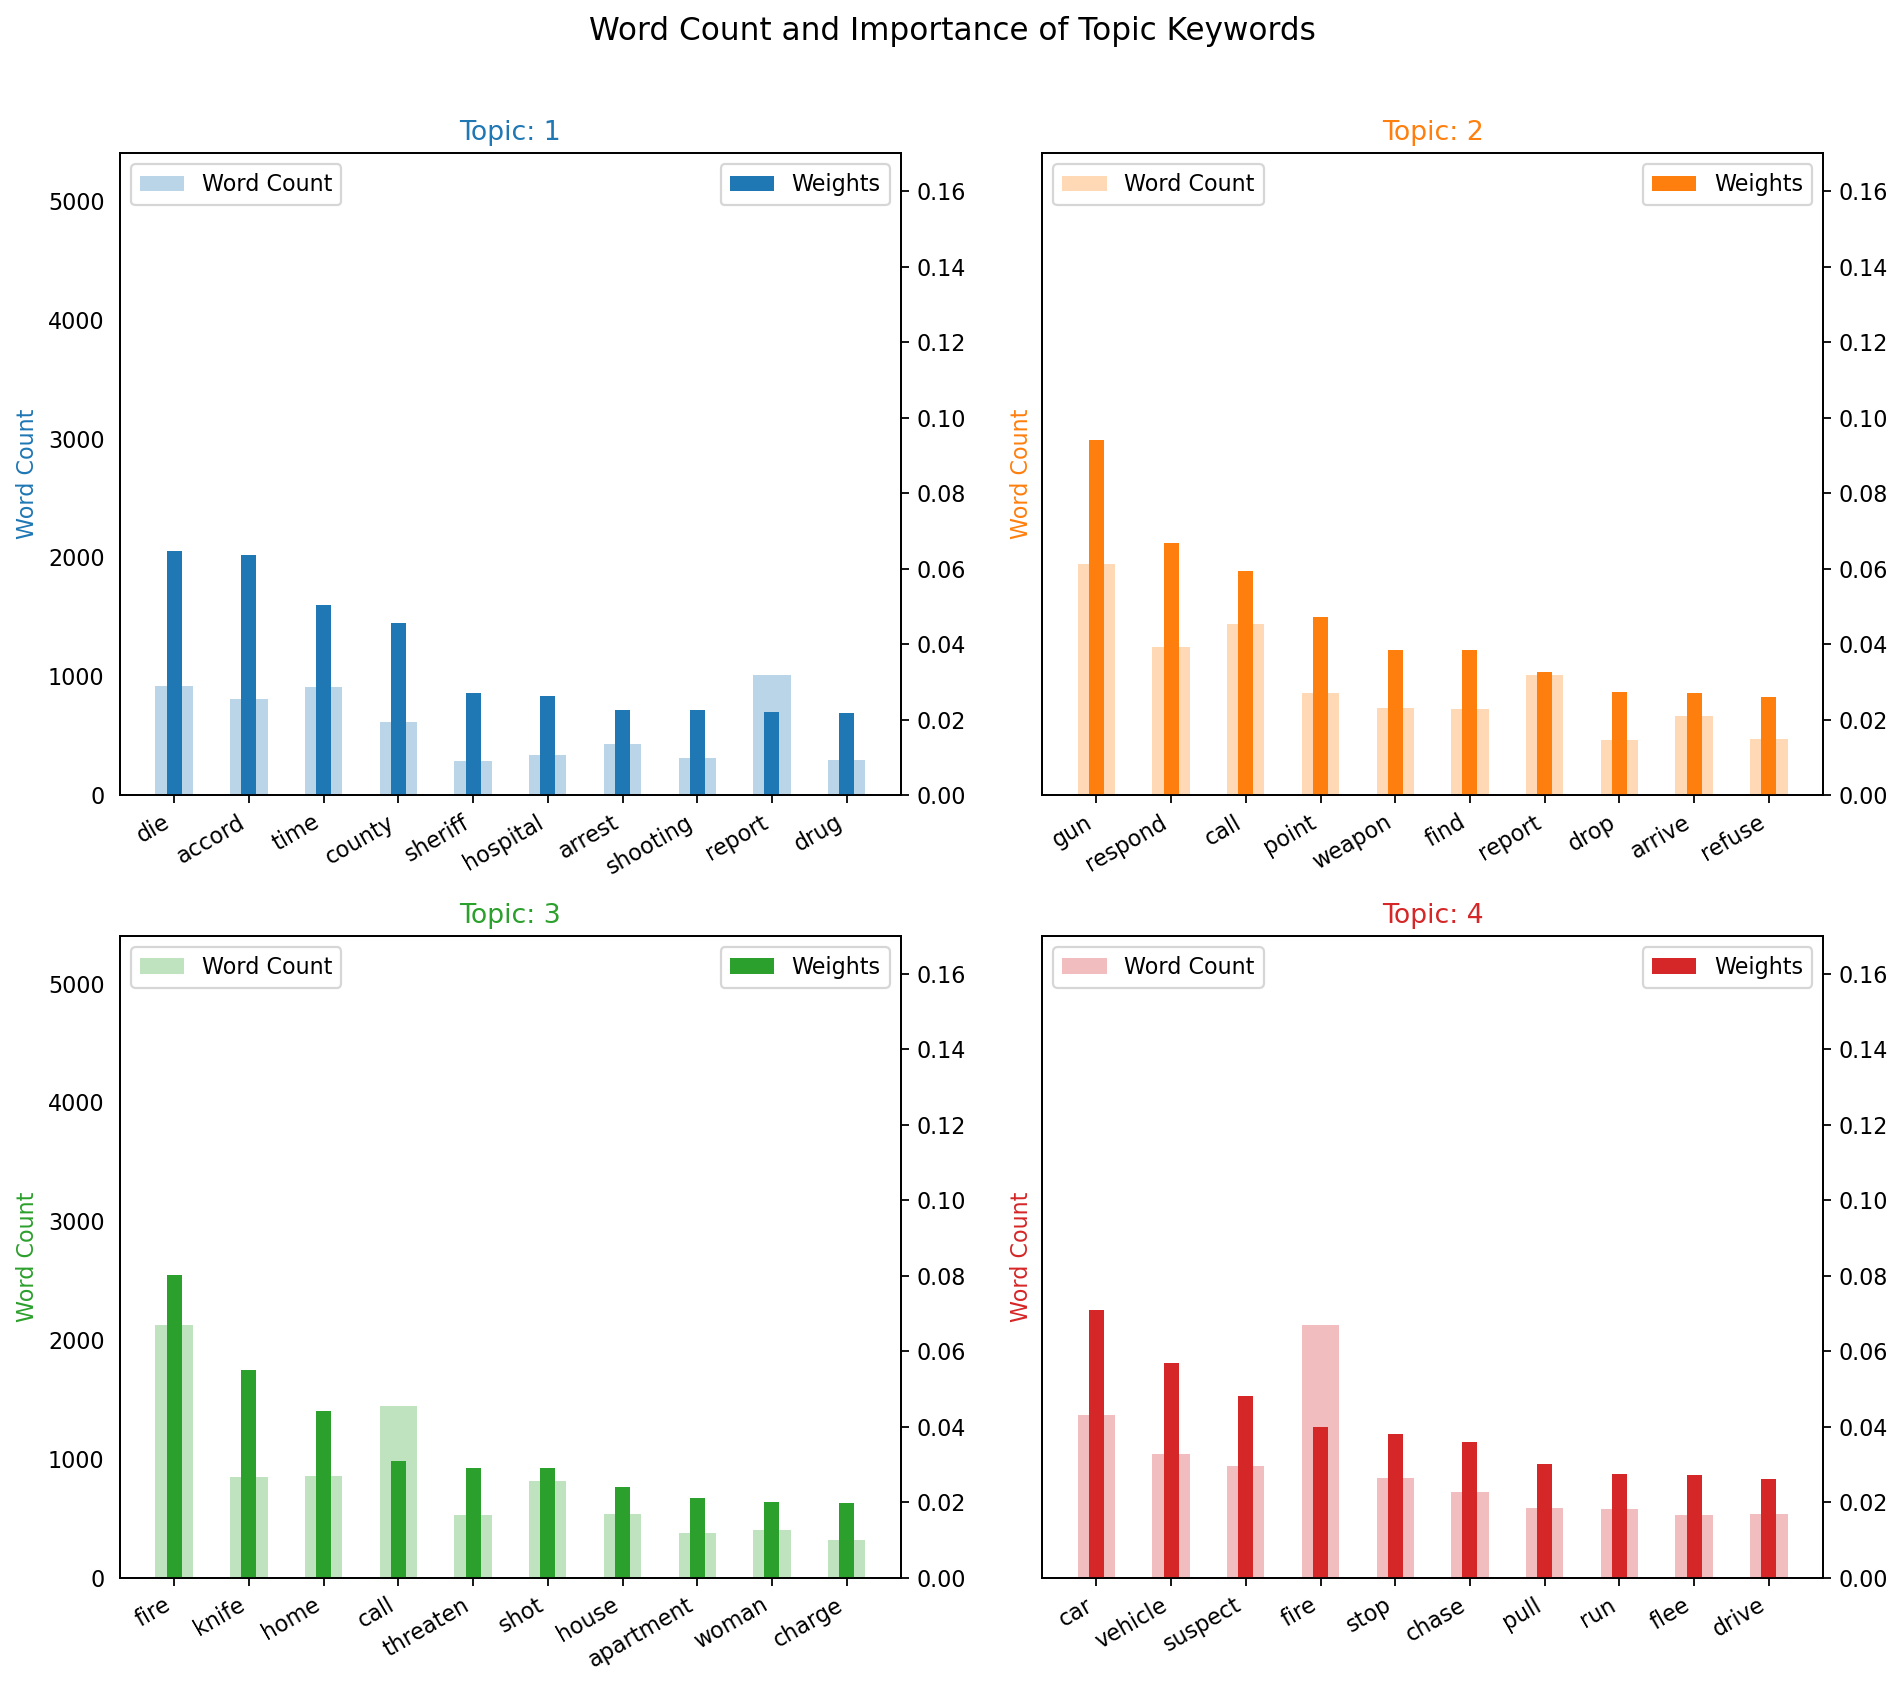

In [45]:
'''
Now we look at the most relevant words for each topic (assigned the highest probability) and the count of each word in the 
corpus. For example, the word 'fire' has the highest probabilty of appearing in topic 3 whereas 'car' and 'vehicle' are most 
relevant for topic 2. 
'''
topics = tm.model.show_topics(formatted=False)
data_flat = [w for w_list in instances for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(12,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.170); ax.set_ylim(0, 5400)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=12)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=14, y=1.05)    
plt.show()

### Word2Vec

In [46]:
'''
Word2Vec analysis. We firstly average 5 word2vec model, changing every time the seed. Moreover, for each Word2Vec model
i'll change the window and the negative value. Since the average length of the refined reports is around 22, I set a starting 
value for the window of 9, in order to go from a window value of 9 to a window value of 13. Since we're considering all the 
dataset, I can keep a min_count value quite high. The averaging will be important in order to get results that are similar each
time we run the code. Consequently, we'll plot a 'network' version of the top 10 most similar words for some pre-chosen words
that we believe are very important for our analysis.
'''
corpus = [i.lower().split() for i in criminali_refined['Desc']]

list_of_models = []

for i in range(5):
    w2v_model = Word2Vec(size=300, # vector size
                     window=9 + i, # window for sampling
                     sample=0.00001, # subsampling rate
                     iter=300, # iterations
                     negative=5 - i, # negative samples
                     min_count=80, # minimum threshold
                     workers=-1, # parallelize to all cores
                     hs=0, # no hierarchical softmax
                     seed = i+5
                    )
    
    # build the vocabulary
    w2v_model.build_vocab(corpus)
    
    # train the model
    w2v_model.train(corpus, 
                total_examples=w2v_model.corpus_count, 
                epochs=w2v_model.epochs)
    
    list_of_models.append(w2v_model)

listone = []

for i in range(len(list_of_models[0].wv.syn0)):
    listone.append(list(np.sum(list_of_models[j].wv.syn0[i] for j in range(len(list_of_models)))/len(list_of_models)))
    
listone = np.array(listone)

for i in range(len(list_of_models[4].wv.syn0)):
    list_of_models[4].wv.syn0[i] = listone[i]
    
w2v_model = list_of_models[4]

Visualizations written to ..\Downloads


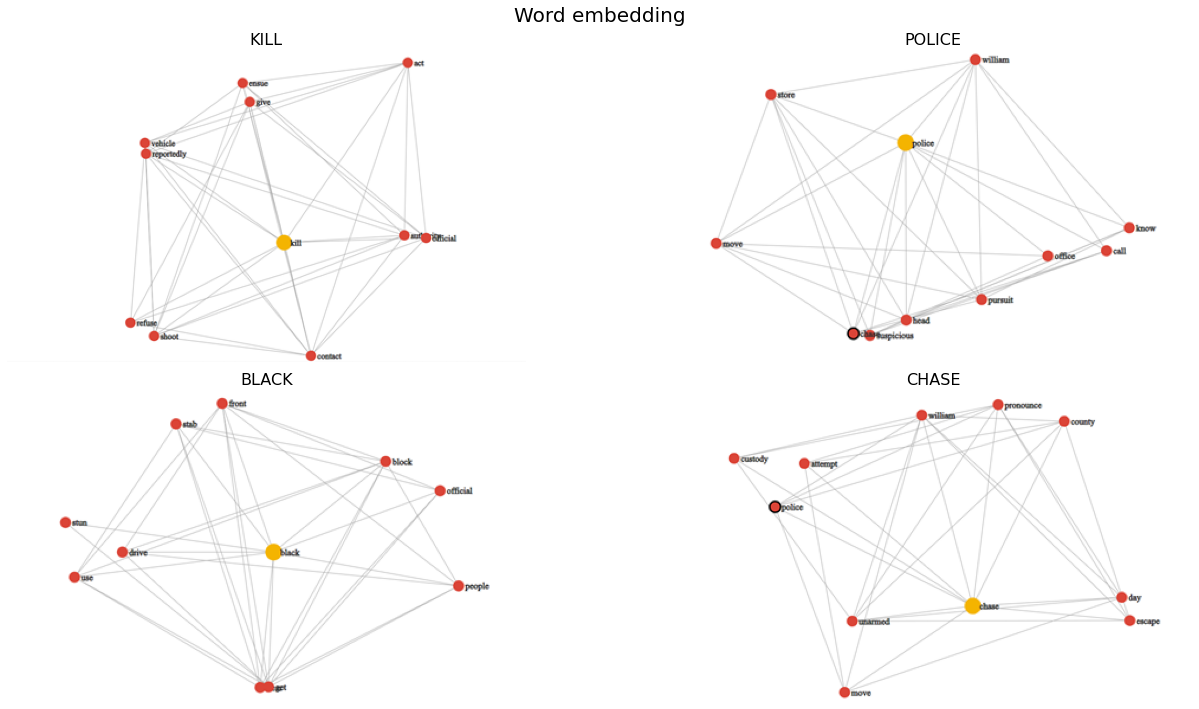

In [47]:
from vec2graph import visualize

visualize('..\Downloads', w2v_model.wv, ['kill', 'police', 'black', 'chase'], depth=0, topn=10, threshold=0,
          edge=1, sep=False, library="web")

import matplotlib.image as mpimg

fig = plt.figure(figsize=(20, 10))
fig.suptitle('Word embedding', fontsize=20)

ax1 = fig.add_subplot(2,2,1)
ax1.axis('off'), ax1.imshow(mpimg.imread('kill.png')), ax1.set_title('KILL', size=16)

ax2 = fig.add_subplot(2,2,2)
ax2.axis('off'), ax2.imshow(mpimg.imread('police.png')), ax2.set_title('POLICE', size=16)

ax3 = fig.add_subplot(2,2,3)
ax3.axis('off'), ax3.imshow(mpimg.imread('black.png')), ax3.set_title('BLACK', size=16)

ax4 = fig.add_subplot(2,2,4)
ax4.axis('off'), ax4.imshow(mpimg.imread('chase.png')), ax4.set_title('CHASE', size=16)

fig.tight_layout()

### Doc2Vec

In [48]:
'''
Doc2Vec analysis. We build, with a function, a Doc2Vec model for every race, where the TAG of each document is the 
AGE-RANGE of the victim. We will plot, via PCA, the resulting top 10 most similar words to each category in order to understand
if it is possible to see some clusters within each race of the most similar words to each age-range. We set a window of 12, 
since the average len of tweets is 22, and we decided to keep the min_count to 60.
'''

def d2vmodelfunc(race):
    corpus = []
    
    for row in criminali_refined[criminali_refined['Race'] == race].iterrows():
        label = row[1].Age_Range
        text = row[1].Desc
        corpus.append(TaggedDocument(words=text.split(), 
                                     tags=[str(label)]))
    
    d2v_model = Doc2Vec(vector_size=300, 
                        window=12,
                        hs=0,
                        sample=0.00001,
                        negative=5,
                        min_count=60,
                        workers=-1,
                        epochs=500,
                        dm=0, 
                        dbow_words=1)
    
    d2v_model.build_vocab(corpus)
    
    d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
    
    return d2v_model

dizio = {}
for i in list(set(criminali_refined['Race'])):
    dizio[i] = d2vmodelfunc(i).most_similar(positive=[d2vmodelfunc(i).docvecs['31 - 45']], topn=10)

In [49]:
'''
Here, via PCA, we plot the resulting values of the Doc2Vec for each race. Let's see if we can identify some clusters thanks to
the plots.
'''

from pylab import * # Importing this just to put the rectangle around the figure

def PCA_scatterplot2(tag, num_similar, model):
    vocab = list(model.wv.vocab.keys())
    vocab_len = len(vocab)
    dim0 = model.wv[vocab[0]].shape[0]
    arr = np.empty((0, dim0), dtype='f')
    w_labels = [tag]
    nearby = model.most_similar(positive=[model.docvecs[tag]], topn=num_similar)
    for n in nearby:
        w_vec = model.wv.__getitem__(n[0])
        w_labels.append(n[0])
        arr = np.append(arr, np.array([w_vec]), axis=0)
  
    pca = PCA(n_components=2, whiten = True, svd_solver = 'randomized', random_state = 42)
    np.set_printoptions(suppress=True)
    Y = pca.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    return w_labels, x_coords , y_coords

def plot_funct2(lista, title):
    sb.set_context('poster')
    fig = plt.figure(figsize=(20,10))
    fig.suptitle('Race : {}'.format(title), fontsize=28)
    ax = plt.subplot(111)
    ax.axis('off')
    color2 = ['blue','lime','darksalmon','gold','dimgray','orchid']
    area = [(10*i**2.5) for i in reversed(range(1,9))]
    for i in range(len(lista)):
        ax.scatter(lista[i][1], lista[i][2], s=area, marker="o", color=color2[i], label = f'{lista[i][0][0]}', edgecolors='black')
        for label, x, y in zip(lista[i][0][1:], lista[i][1], lista[i][2]):
            ax.annotate(label.upper(), xy=(x-0.05, y+0.05), xytext=(0, 15), textcoords='offset points', size=12)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2, prop={'size': 25})  
    ax.axis('off')
    ax.grid(True)
    autoAxis = ax.axis()
    rec = Rectangle((autoAxis[0]-0.05,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+0.2,(autoAxis[3]-autoAxis[2])+0.4,fill=False,lw=2)
    rec = ax.add_patch(rec)
    rec.set_clip_on(False)
    sb.reset_orig()

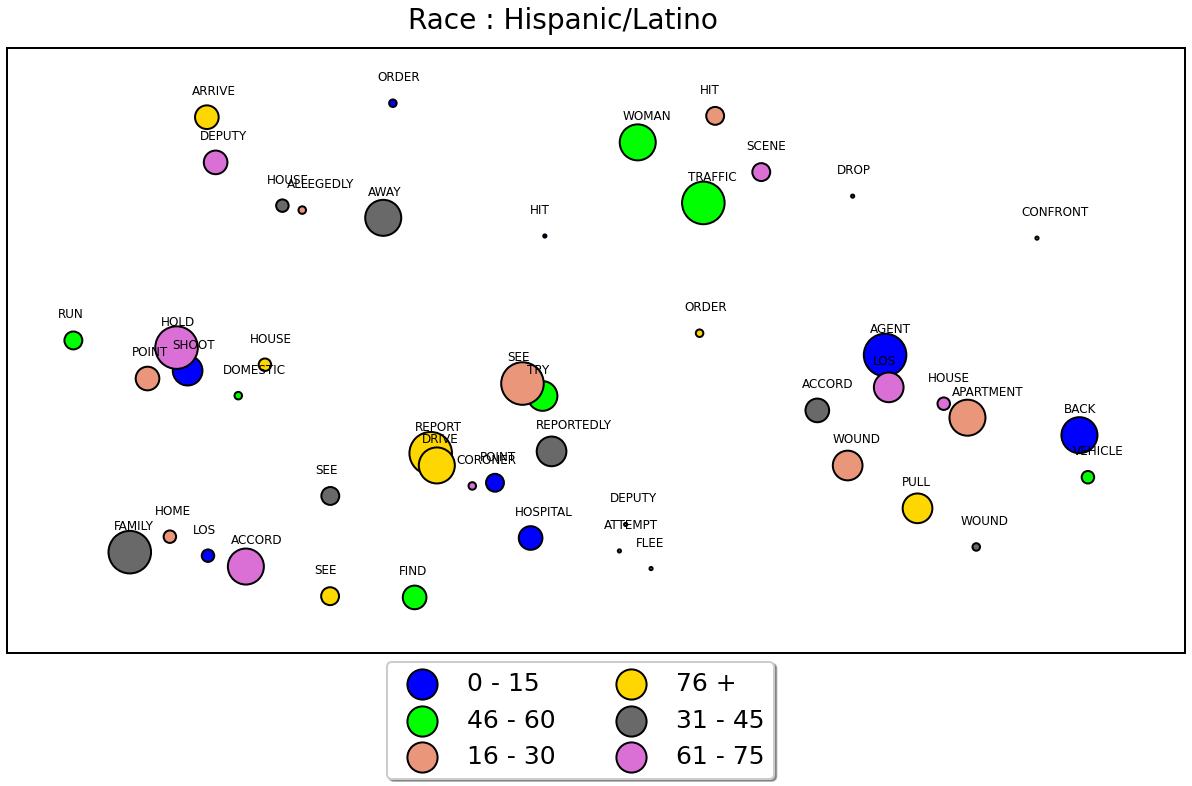

In [50]:
'''
Functions to plot the results.
'''

listaisp = [PCA_scatterplot2(k, 8, d2vmodelfunc('Hispanic/Latino')) for k in list(set(criminali_refined['Age_Range']))]
listablack = [PCA_scatterplot2(k, 8, d2vmodelfunc('African-American/Black')) for k in list(set(criminali_refined['Age_Range']))]
listawhite = [PCA_scatterplot2(k, 8, d2vmodelfunc('European-American/White')) for k in list(set(criminali_refined['Age_Range']))]

plot_funct2(listaisp,'Hispanic/Latino')

In [51]:
'''
From the plot of Hispanic, it's interesting to see that there's a little bit of clustering between top words of 0 - 15 and 
16 - 30. Moreover, another interesting things is that the two most similar words to the 46 - 60 age-range are women and traffic.
Finally, opposed to our prior, the most similar word to people between 31 - 45 is family.
'''

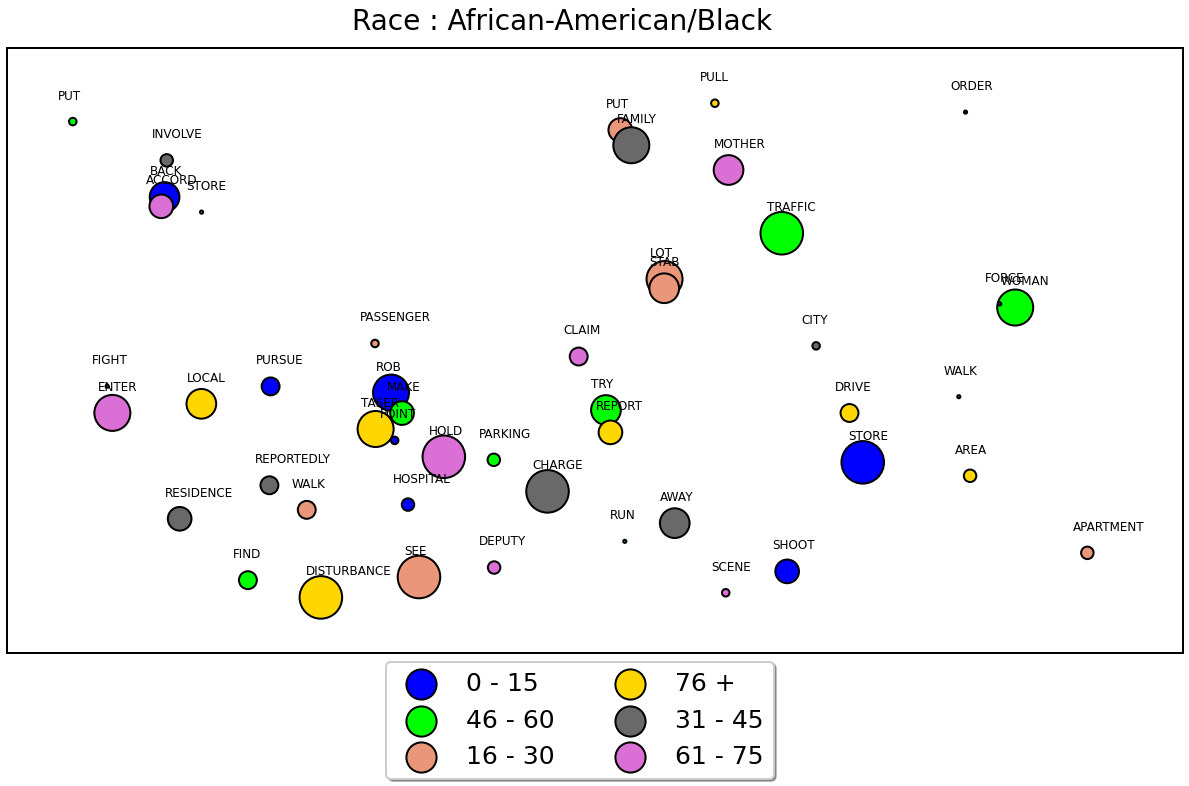

In [52]:
plot_funct2(listablack, 'African-American/Black')

In [53]:
'''
For the African-American/Black, there is not such a particular clustering for this race. What is interesting to see is that
most similar words to 16 - 30, 31 - 45 and 76+ are really close. However, since there is a lot of mixing between words,
probably it's difficult to cluster by age-range for this race.
'''

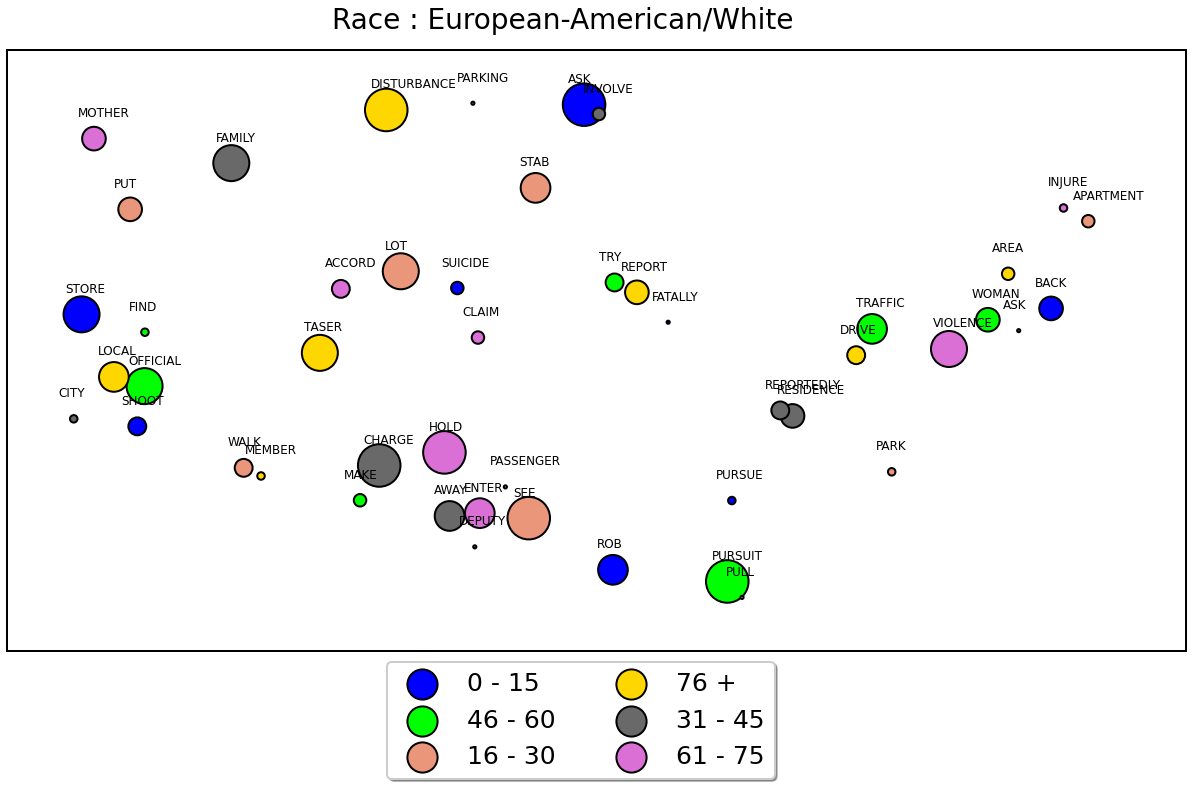

In [54]:
plot_funct2(listawhite, 'European-American/White')

In [55]:
'''
Here, for European-American/White, we can see a different behaviour with respect to the African-American/Black. We immediately
see that the most similar words are mor far from each other (apart for 31 - 45 and 61 - 75). Another interesting thing is that
for people 75+ the most similar word is disturbance. Probably, again, this suggests some behaviours from people belonging to
this race.
'''

In [56]:
'''
If we want to make a more general clustering, without considering just top 10 words, we can exploit KMEANS
'''
import gensim

LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in criminali_refined['Desc'].values:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print('Number of texts processed: ', j)
d2v_model = Doc2Vec(all_content_train, 
                    vector_size=300, 
                    window=12,
                    hs=0,
                    sample=0.00001,
                    negative=5,
                    min_count=60,
                    workers=-1,
                    epochs=500,
                    dm=0, 
                    dbow_words=1)

d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

Number of texts processed:  6427


2 0.0031071631
3 0.0028070041
4 0.0026982818
5 0.002710783
6 0.0027138032
7 0.0026582559
8 0.0027781602
9 0.0027346897


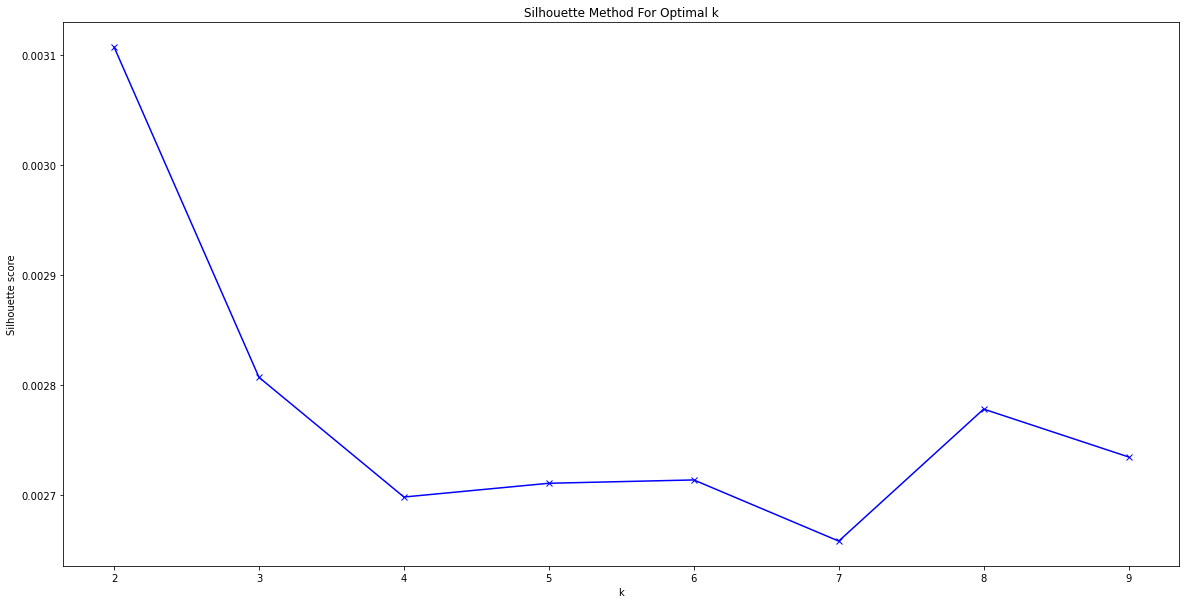

In [57]:
'''
Here, we compute the silouhette score, in order to understand the optimal number of cluster given the text that we have.
'''
silhouettes = []

sample = np.random.choice(len(d2v_model.docvecs.doctag_syn0), replace=False, size=5000)

K = range(2, 10)

for c in K:    
    kmeans_model = KMeans(n_clusters=c, init='k-means++', max_iter=100) 
    clusters = kmeans_model.fit_predict(d2v_model.docvecs.doctag_syn0[sample])
    labels=kmeans_model.labels_.tolist()    
    score = silhouette_score(d2v_model.docvecs.doctag_syn0[sample], clusters)
    silhouettes.append(score)
    print(c, score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

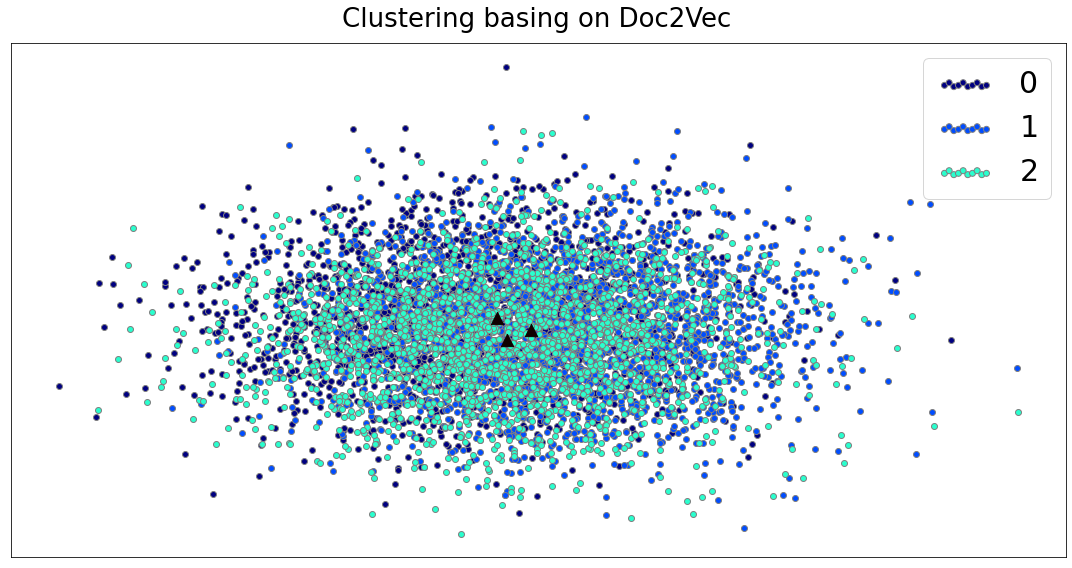

In [58]:
'''
Given the silouhette score, we decide to go with 3 clusters
'''

kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.docvecs.doctag_syn0)
labels=kmeans_model.labels_.tolist()

l = kmeans_model.fit_predict(d2v_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_model.docvecs.doctag_syn0)
datapoint = pca.transform(d2v_model.docvecs.doctag_syn0)

df = pd.DataFrame({'x':[i[0] for i in datapoint], 'y':[i[1] for i in datapoint], 'cluster':labels})

fig, ax = plt.subplots(figsize=(15,8))
fig.suptitle('Clustering basing on Doc2Vec', fontsize=26)
cmap = plt.cm.get_cmap('jet')
for i, cluster in df.groupby('cluster'):
    _ = ax.scatter(cluster['x'], cluster['y'], color=cmap(i/5), label=i, edgecolor = 'grey')
ax.legend(fontsize=30, scatterpoints=10)
ax.set_xticks(())
ax.set_yticks(())

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#100000')
fig.tight_layout()

In [59]:
'''
After having visualized the clusters, that appear to be pretty well split, we want to analyze them.
'''

'\nAfter having visualized the clusters, that appear to be pretty well split, we want to analyze them.\n'

In [60]:
criminali_refined['cluster'] = kmeans_model.labels_.tolist()
data_cluster = criminali_refined.groupby(['cluster','Race']).aggregate({'Race':'count'})
data_cluster.columns = ['num']
data_cluster = data_cluster.reset_index()
data_cluster['perc'] = data_cluster['num'].apply(lambda x: x/sum(data_cluster['num']))

In [61]:
'''
Here, we want to take a look at the participation of each Race inside each of the cluster.
'''

DA = data_cluster.groupby(['cluster','Race']).aggregate({'perc':'sum'}).reset_index()
print('Cluster 0 percentage division:')
print('African-American/Black: {}'.format(round(DA[DA['cluster'] == 0]['perc'].apply(lambda x: x/sum(DA[DA['cluster'] == 0]['perc']))[0],2)))
print('European-American/White: {}'.format(round(DA[DA['cluster'] == 0]['perc'].apply(lambda x: x/sum(DA[DA['cluster'] == 0]['perc']))[1],2))) 
print('Hispanic/Latino: {}'.format(round(DA[DA['cluster'] == 0]['perc'].apply(lambda x: x/sum(DA[DA['cluster'] == 0]['perc']))[2],2)))
print(' ')
print('Cluster 1 percentage division:')
print('African-American/Black: {}'.format(round(DA[DA['cluster'] == 1]['perc'].apply(lambda x: x/sum(DA[DA['cluster'] == 1]['perc']))[3],2)))
print('European-American/White: {}'.format(round(DA[DA['cluster'] == 1]['perc'].apply(lambda x: x/sum(DA[DA['cluster'] == 1]['perc']))[4],2)))      
print('Hispanic/Latino: {}'.format(round(DA[DA['cluster'] == 1]['perc'].apply(lambda x: x/sum(DA[DA['cluster'] == 1]['perc']))[5],2)))
print(' ')
print('Cluster 2 percentage division:')
print('African-American/Black: {}'.format(round(DA[DA['cluster'] == 2]['perc'].apply(lambda x: x/sum(DA[DA['cluster'] == 2]['perc']))[6],2)))
print('European-American/White: {}'.format(round(DA[DA['cluster'] == 2]['perc'].apply(lambda x: x/sum(DA[DA['cluster'] == 2]['perc']))[7],2)))   
print('Hispanic/Latino: {}'.format(round(DA[DA['cluster'] == 2]['perc'].apply(lambda x: x/sum(DA[DA['cluster'] == 2]['perc']))[8],2)))

Cluster 0 percentage division:
African-American/Black: 0.31
European-American/White: 0.47
Hispanic/Latino: 0.22
 
Cluster 1 percentage division:
African-American/Black: 0.32
European-American/White: 0.45
Hispanic/Latino: 0.23
 
Cluster 2 percentage division:
African-American/Black: 0.33
European-American/White: 0.44
Hispanic/Latino: 0.22


In [62]:
'''
In all clusters, the predominant race is always White. Moreover, the ranking is the same in cluster 0, 1 and 2.
'''

In [63]:
'''
Here we want to take a look at how each race is divided in clusters, and in which they are more participating.
'''

DA1 = data_cluster.groupby(['Race','cluster']).aggregate({'perc':'sum'}).reset_index()
print('African-American/Black percentage division:')
print('Cluster 0: {}'.format(round(DA1[DA1['Race'] == 'African-American/Black']['perc'].apply(lambda x: x/sum(DA1[DA1['Race'] == 'African-American/Black']['perc']))[0],2)))
print('Cluster 1: {}'.format(round(DA1[DA1['Race'] == 'African-American/Black']['perc'].apply(lambda x: x/sum(DA1[DA1['Race'] == 'African-American/Black']['perc']))[1],2))) 
print('Cluster 2: {}'.format(round(DA1[DA1['Race'] == 'African-American/Black']['perc'].apply(lambda x: x/sum(DA1[DA1['Race'] == 'African-American/Black']['perc']))[2],2)))
print(' ')
print('European-American/White percentage division:')
print('Cluster 0: {}'.format(round(DA1[DA1['Race'] == 'European-American/White']['perc'].apply(lambda x: x/sum(DA1[DA1['Race'] == 'European-American/White']['perc']))[3],2)))
print('Cluster 1: {}'.format(round(DA1[DA1['Race'] == 'European-American/White']['perc'].apply(lambda x: x/sum(DA1[DA1['Race'] == 'European-American/White']['perc']))[4],2)))      
print('Cluster 2: {}'.format(round(DA1[DA1['Race'] == 'European-American/White']['perc'].apply(lambda x: x/sum(DA1[DA1['Race'] == 'European-American/White']['perc']))[5],2)))
print(' ')
print('Hispanic/Latino percentage division:')
print('Cluster 0: {}'.format(round(DA1[DA1['Race'] == 'Hispanic/Latino']['perc'].apply(lambda x: x/sum(DA1[DA1['Race'] == 'Hispanic/Latino']['perc']))[6],2)))
print('Cluster 1: {}'.format(round(DA1[DA1['Race'] == 'Hispanic/Latino']['perc'].apply(lambda x: x/sum(DA1[DA1['Race'] == 'Hispanic/Latino']['perc']))[7],2)))   
print('Cluster 2: {}'.format(round(DA1[DA1['Race'] == 'Hispanic/Latino']['perc'].apply(lambda x: x/sum(DA1[DA1['Race'] == 'Hispanic/Latino']['perc']))[8],2)))

African-American/Black percentage division:
Cluster 0: 0.3
Cluster 1: 0.34
Cluster 2: 0.36
 
European-American/White percentage division:
Cluster 0: 0.32
Cluster 1: 0.33
Cluster 2: 0.34
 
Hispanic/Latino percentage division:
Cluster 0: 0.3
Cluster 1: 0.35
Cluster 2: 0.35


In [64]:
'''
As we can see, each of the race is partecipating the most in the cluster 2.
'''

In [65]:
'''
With this function, we return the word with the highest tfidf value given the list that we pass.
'''

def funzionetfidf(lista):
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.75, 
                                   ngram_range=(1,2),
                                   stop_words=None, 
                                   sublinear_tf=True)
    X = tfidf_vectorizer.fit_transform(lista)
    vectorizer = CountVectorizer(analyzer='word', 
                             min_df=0.001, 
                             max_df=0.75,
                             ngram_range=(1,2),
                             stop_words=None)
    X2 = vectorizer.fit_transform(lista)
    df_Confronto = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                   }).sort_values(['tfidf', 'tf', 'idf'], ascending = False)
    df_Confronto = df_Confronto.reset_index()
    df_Confronto = df_Confronto.drop(['index'],axis=1)
    return df_Confronto.iloc[0,0], df_Confronto.iloc[0,3]

In [66]:
'''
We take report text related to each single cluster.
'''

cluster_0 = [i for i in criminali_refined[criminali_refined['cluster'] == 0]['Desc']]
cluster_1 = [i for i in criminali_refined[criminali_refined['cluster'] == 1]['Desc']]
cluster_2 = [i for i in criminali_refined[criminali_refined['cluster'] == 2]['Desc']]

data_cluster = data_cluster.groupby('cluster').aggregate({'perc':'sum'})
data_cluster['highest_tfidf'] = [funzionetfidf(cluster_0)[0],funzionetfidf(cluster_1)[0],funzionetfidf(cluster_2)[0]]
data_cluster['value_tfidf'] = [funzionetfidf(cluster_0)[1],funzionetfidf(cluster_1)[1],funzionetfidf(cluster_2)[1]]

In [67]:
data_cluster

,perc,highest_tfidf,value_tfidf
cluster,,,
0,0.309787,officer,91.862907
1,0.339816,officer,112.827135
2,0.350397,officer,115.676977


In [68]:
'''
Analyzing the result, clusters are split pretty well, since the word with highest TFIDF value has in each of the cluster a 
pretty high value. Problem is that the word is always the same, so probably the topics inside each of the cluster are always
the same.
'''

# 3. Visualizations, 4. Prediction

## 4.1 Classification

In [69]:
'''
Here, we start with the classification. First step is to turn our string values for African-American/Black, 
European-American/White and Hispanic/Latino into numbers. For all the algorithms, we will try to tune the hyperparameters 
with a GRIDSEARCHCV, and then to understand if, thanks to the tuning, our performances improved or not. Moreover, for the
best algorithm, we'll try with some pipelines to understand if it is possible to make feature selection and dimensionality 
reduction without losing the performance.
'''

factor = pd.factorize(criminali_refined['Race'])
criminali_refined['Race_numb'] = factor[0]
definitions = factor[1]

In [70]:
'''
Here, we split our dataset into train, dev and test.
'''

N = len(criminali_refined)
train_size = int(N*0.6)
dev_size = int(N*0.2)
test_size = int(N*0.2)

# split the data into training, develpment and test set:
train = criminali_refined[:train_size]
dev = criminali_refined[train_size: train_size+dev_size]
test = criminali_refined[train_size+dev_size:]
print(len(train), len(dev), len(test))

3856 1285 1286


In [71]:
target = 'Race_numb'

y_train = train[target]
y_dev = dev[target]
y_test = test[target]

# African-American/Black = 0
# European-American/White = 1
# Hispanic/Latino = 2

### 1) Baseline

In [72]:
'''
First step is to build a baseline. Here, by exploiting a DummyClassifier, we predict for all the reports the most frequent 
class (i.e. European-American/Black), in order to see if our next models are improving the predicting performance with respect
to the baseline
'''

In [73]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.95, 
                             analyzer='word',
                             sublinear_tf=True
                            )

X_train = vectorizer.fit_transform(train['Desc'])
X_dev = vectorizer.transform(dev['Desc'])
X_test = vectorizer.transform(test['Desc'])

MOST FREQUENT (Baseline)
 
Confusion Matrix
 


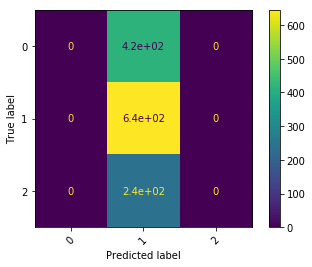

 
Classification Report
 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       416
           1       0.50      1.00      0.66       645
           2       0.00      0.00      0.00       240

    accuracy                           0.50      1301
   macro avg       0.17      0.33      0.22      1301
weighted avg       0.25      0.50      0.33      1301

 
Accuracy Score
 
0.4957724827056111


In [74]:
'''
Now that we have the vectors, we predict.
'''

most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_train, y_train)

dumb_predictions = most_frequent.predict(X_dev)
print('MOST FREQUENT (Baseline)')
print(' ')
print('Confusion Matrix')
print(' ')
plot_confusion_matrix(most_frequent, X_dev, y_dev)  
plt.tick_params(axis='x', labelsize=10, rotation = 45)
plt.tick_params(axis='y', labelsize=10)
plt.show()
print(' ')
print('Classification Report')
print(' ')
print(classification_report(y_dev,dumb_predictions))
print(' ')
print('Accuracy Score')
print(' ')
print(accuracy_score(y_dev, dumb_predictions))

In [75]:
'''
As we can see, we start from an accuracy of 0.496, so nearly 50%.
'''

### 2) LogisticRegression with default parameters and 2-6 gram character TFIDF features

In [76]:
'''
Now we build the second baseline. A Logistic Regression with default parameters, but changing the ngram range of the TFIDF 
vectorizer: from (1,2) we move to (2,6). We decide also to move from analyzer = 'word' to analyzer = 'char'.
'''

In [77]:
vectorizer1 = TfidfVectorizer(ngram_range=(2,6), 
                             min_df=0.001, 
                             max_df=0.95, 
                             analyzer='char',
                             sublinear_tf=True
                             )

X_train_Log = vectorizer1.fit_transform(train['Desc'])
X_dev_Log = vectorizer1.transform(dev['Desc'])
X_test_Log = vectorizer1.transform(test['Desc'])

Wall time: 13.6 s
LOGISTIC CLASSIFIER
 
Confusion Matrix
 


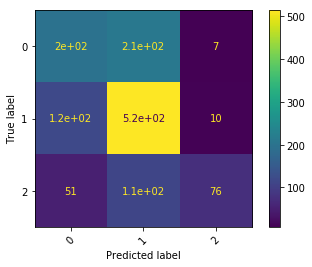

 
Classification Report
 
              precision    recall  f1-score   support

           0       0.54      0.48      0.50       416
           1       0.61      0.80      0.69       645
           2       0.82      0.32      0.46       240

    accuracy                           0.61      1301
   macro avg       0.66      0.53      0.55      1301
weighted avg       0.63      0.61      0.59      1301

 
Accuracy Score
 
0.606456571867794


In [78]:
'''
Prediction
'''

LogClass = LogisticRegression()
%time LogClass.fit(X_train_Log, y_train)

predictions = LogClass.predict(X_dev_Log)
print('LOGISTIC CLASSIFIER')
print(' ')
print('Confusion Matrix')
print(' ')
plot_confusion_matrix(LogClass, X_dev_Log, y_dev)  
plt.tick_params(axis='x', labelsize=10, rotation = 45)
plt.tick_params(axis='y', labelsize=10)
plt.show()
print(' ')
print('Classification Report')
print(' ')
print(classification_report(y_dev,predictions))
print(' ')
print('Accuracy Score')
print(' ')
print(accuracy_score(y_dev, predictions))

In [79]:
'''
The performance, since this is just a baseline, it's way better than before. We noticed that by keeping analyzer = 'word', the
prediction would not have been that high, but similar to the one done with the dummy classifier. So our final 'best' baseline
accuracy is 0.606.
'''

### 3) Logistic Regression tuned

In [80]:
'''
We start with the improving algorithms by a Logistic Regression, the same as the one used for the baseline, but now we tune 
the hyperparameters with a GridSearchCV.
'''

In [81]:
'''
GridSearch
'''
lr_cv = LogisticRegression(n_jobs = -1)

param_grid5 = {'penalty': ['l1', 'l2', 'elasticnet'],
               'C':[0.001,.009,0.01,.09,1,2,3,4,5,10,25],
               'solver' : ['newton-cg', 'lbfgs', 'sag', 'saga']
              }

CV_lr = GridSearchCV(estimator=lr_cv, param_grid=param_grid5, cv= 5)
CV_lr.fit(X_train_Log, y_train)
CV_lr.best_params_

{'C': 5, 'penalty': 'l1', 'solver': 'saga'}

In [82]:
'''
We put as parameters of the model the ones chosen by the GridSearch
'''

lgcreg1 = LogisticRegression(C = 5, penalty = 'l1', solver = 'saga')

lgcreg1.fit(X_train_Log,y_train)

y_pred10 = lgcreg1.predict(X_dev_Log)

TUNED LOGISTIC REGRESSION
 
Confusion Matrix
 


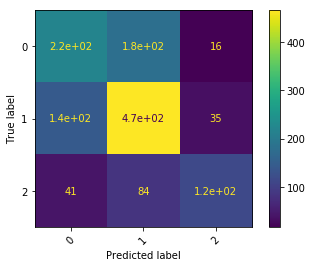

 
Classification Report
 
              precision    recall  f1-score   support

           0       0.54      0.53      0.54       416
           1       0.64      0.72      0.68       645
           2       0.69      0.48      0.57       240

    accuracy                           0.62      1301
   macro avg       0.63      0.58      0.59      1301
weighted avg       0.62      0.62      0.61      1301

 
Accuracy Score
 
0.6164488854727133


In [83]:
print('TUNED LOGISTIC REGRESSION')
print(' ')
print('Confusion Matrix')
print(' ')
plot_confusion_matrix(lgcreg1, X_dev_Log, y_dev)  
plt.tick_params(axis='x', labelsize=10, rotation = 45)
plt.tick_params(axis='y', labelsize=10)
plt.show()
print(' ')
print('Classification Report')
print(' ')
print(classification_report(y_dev,y_pred10))
print(' ')
print('Accuracy Score')
print(' ')
print(accuracy_score(y_dev, y_pred10))

In [84]:
'''
As we can see, the prediction accuracy improved of nearly 1%. This means that the tuning has improved the performance, but
not by what we were expecting.
'''

In [85]:
'''
Let's try to change thresholds. As we know, in the algorithms there is always the possibility to predict probability via
predict_proba, so for this reason we try to change the threshold of the prediction for one of the class, and see if we can 
get a better accuracy.
'''

pred_for_log_proba = lgcreg1.predict_proba(X_dev_Log)

def funzione_accuracy(proba, a = 0, b = 0, c = 0):
    accurac0 = []
    lista_threshold = np.arange(0.05,0.95,0.01)
    v = np.zeros((len(y_dev),1))
    for k in lista_threshold:
        for i in range(len(proba)):
            if proba[i][a] >= k:
                v[i] = a
            else:
                if np.argmax(np.hstack([proba[i][b],proba[i][c]])) == 0:
                    v[i] = b
                elif np.argmax(np.hstack([proba[i][b],proba[i][c]])) == 1:
                    v[i] = c
        accurac0.append([k, accuracy_score(y_dev, v)])
    
    acc0_th = [i[0] for i in accurac0]
    acc0_ac = [i[1] for i in accurac0]
    
    return (acc0_th[np.argmax(acc0_ac)],acc0_ac[np.argmax(acc0_ac)])

In [86]:
print('With threshold = {0} for African-American, we get accuracy = {1}, with a difference of {2} with the starting accuracy'.format(round(funzione_accuracy(pred_for_log_proba, 0, 1, 2)[0],2), funzione_accuracy(pred_for_log_proba, 0, 1, 2)[1], (funzione_accuracy(pred_for_log_proba, 0, 1, 2)[1] - accuracy_score(y_dev, y_pred10))))
print(' ')
print('With threshold = {0} for White-American, we get accuracy = {1}, with a difference of {2} with the starting accuracy'.format(round(funzione_accuracy(pred_for_log_proba, 1, 0, 2)[0],2), funzione_accuracy(pred_for_log_proba, 1, 0, 2)[1], (funzione_accuracy(pred_for_log_proba, 1, 0, 2)[1] - accuracy_score(y_dev, y_pred10))))
print(' ')
print('With threshold = {0} for Hispanic, we get accuracy = {1}, with a difference of {2} with the starting accuracy'.format(round(funzione_accuracy(pred_for_log_proba, 2, 0, 1)[0],2), funzione_accuracy(pred_for_log_proba, 2, 0, 1)[1], (funzione_accuracy(pred_for_log_proba, 2, 0, 1)[1] - accuracy_score(y_dev, y_pred10))))

With threshold = 0.56 for African-American, we get accuracy = 0.6195234435049961, with a difference of 0.003074558032282848 with the starting accuracy
 
With threshold = 0.43 for White-American, we get accuracy = 0.6195234435049961, with a difference of 0.003074558032282848 with the starting accuracy
 
With threshold = 0.45 for Hispanic, we get accuracy = 0.6225980015372791, with a difference of 0.006149116064565807 with the starting accuracy


In [87]:
'''
As we can see, we obtain the best result by lowering the threshold for Hispanic, raising accuracy of 0.006
'''

### 4) K-Nearest-Neighbour

In [88]:
vectorizerknn = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.95, 
                             analyzer='word',
                             sublinear_tf=True
                            )

X_train_KNN = vectorizerknn.fit_transform(train['Desc'])
X_dev_KNN = vectorizerknn.transform(dev['Desc'])
X_test_KNN = vectorizerknn.transform(test['Desc'])

In [89]:
'''
Here, we move to another simple algorithm, in order to understand if we can get a good prediction basing on the neighbours of
each data point.
'''
classknn = KNeighborsClassifier(n_jobs = -1)

param_grid100 = {'n_neighbors': [i for i in range(5,20)], 
              'weights': ['uniform','distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
             }

CV_knn = GridSearchCV(estimator=classknn, param_grid=param_grid100, cv= 5)
CV_knn.fit(X_train_KNN, y_train)

In [90]:
CV_knn.best_params_

{'algorithm': 'auto', 'n_neighbors': 19, 'weights': 'distance'}

In [91]:
'''
Now that we tuned the parameters, let's predict.
'''

from sklearn.neighbors import KNeighborsClassifier

classifierknn = KNeighborsClassifier(algorithm = 'auto', weights = 'distance', n_neighbors=19)

classifierknn.fit(X_train_KNN, y_train)

y_pred_KNN = classifierknn.predict(X_dev_KNN)

K NEAREST NEIGHBOUR CLASSIFIER
 
Confusion Matrix
 


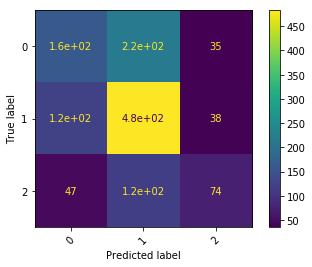

 
Classification Report
 
              precision    recall  f1-score   support

           0       0.49      0.39      0.43       416
           1       0.59      0.75      0.66       645
           2       0.50      0.31      0.38       240

    accuracy                           0.55      1301
   macro avg       0.53      0.48      0.49      1301
weighted avg       0.54      0.55      0.54      1301

 
Accuracy Score
 
0.5526518063028439


In [92]:
print('K NEAREST NEIGHBOUR CLASSIFIER')
print(' ')
print('Confusion Matrix')
print(' ')
plot_confusion_matrix(classifierknn, X_dev_KNN, y_dev)  
plt.tick_params(axis='x', labelsize=10, rotation = 45)
plt.tick_params(axis='y', labelsize=10)
plt.show()
print(' ')
print('Classification Report')
print(' ')
print(classification_report(y_dev,y_pred_KNN))
print(' ')
print('Accuracy Score')
print(' ')
print(accuracy_score(y_dev, y_pred_KNN))

In [93]:
'''
We can see that the accuracy, with KNearestNeighbours classifier, has dropped of nearly 5%.
'''

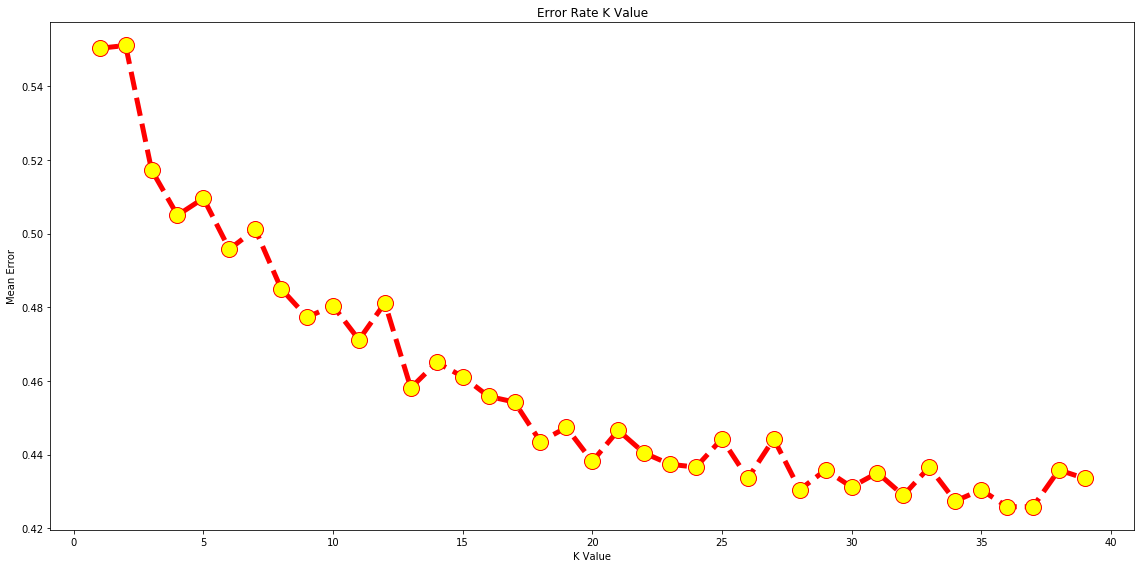

In [94]:
'''
Let's compare variance of results if we put a different number of neighbours
'''

error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(weights = 'distance',algorithm = 'auto',n_neighbors=i)
    knn.fit(X_train_KNN, y_train)
    pred_i = knn.predict(X_dev_KNN)
    error.append(np.mean(pred_i != y_dev))

plt.figure(figsize=(16, 8))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', linewidth = 5, marker='o',
         markerfacecolor='yellow', markersize=16)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.tight_layout()

In [95]:
'''
Apparently, best number of neighbours to reduce the error, but without making the process that complex is 19.
'''

### 5) Random Forest

In [96]:
vectorizer2 = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.95, 
                             analyzer='word',
                             sublinear_tf=True
                            )

X_train_RF = vectorizer2.fit_transform(train['Desc'])
X_dev_RF = vectorizer2.transform(dev['Desc'])
X_test_RF = vectorizer2.transform(test['Desc'])

In [97]:
'''
Here, we make things a bit more complex, with a Random Forest Classifier. We first try to tune it, and then we see the results
'''
rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [100,200,300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy'],
    'bootstrap' : [True, False],
    'oob_score' : [True, False], 
    'n_jobs' : [-1],
    
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_RF, y_train)

In [98]:
CV_rfc.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False}

In [99]:
'''
After tuning the hyperparameters with a GridSearch, let's predict the result.
'''

rfc1 = RandomForestClassifier(bootstrap = False,
                              criterion = 'entropy',
                              max_features = 'sqrt',
                              n_estimators = 300,
                              n_jobs = -1,
                              oob_score = False)

rfc1.fit(X_train_RF,y_train)

y_pred2 = rfc1.predict(X_dev_RF)

RANDOM FOREST
 
Confusion Matrix
 


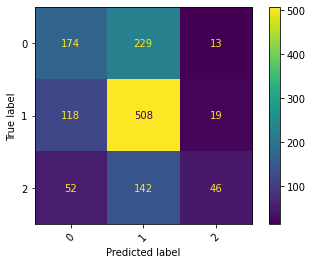

 
Classification Report
 
              precision    recall  f1-score   support

           0       0.51      0.42      0.46       416
           1       0.58      0.79      0.67       645
           2       0.59      0.19      0.29       240

    accuracy                           0.56      1301
   macro avg       0.56      0.47      0.47      1301
weighted avg       0.56      0.56      0.53      1301

 
Accuracy Score
 
0.5595695618754803


In [100]:
print('RANDOM FOREST')
print(' ')
print('Confusion Matrix')
print(' ')
plot_confusion_matrix(rfc1, X_dev_RF, y_dev)  
plt.tick_params(axis='x', labelsize=10, rotation = 45)
plt.tick_params(axis='y', labelsize=10)
plt.show()
print(' ')
print('Classification Report')
print(' ')
print(classification_report(y_dev,y_pred2))
print(' ')
print('Accuracy Score')
print(' ')
print(accuracy_score(y_dev, y_pred2))

In [101]:
'''
As we can see, clearly accuracy didn't go up. Performances of random forest classifier are very similar to the ones of 
KNearestNeighbours, but didn't overcome the ones of Logistic Regression and Tuned Logistic Regression 
'''

In [102]:
'''
Let's try to change the thresholds.
'''

pred2proba = rfc1.predict_proba(X_dev_RF)

print('With threshold = {0} for African-American, we get accuracy = {1}, with a difference of {2} with the starting accuracy'.format(round(funzione_accuracy(pred2proba, 0, 1, 2)[0],2), funzione_accuracy(pred2proba, 0, 1, 2)[1], (funzione_accuracy(pred2proba, 0, 1, 2)[1] - accuracy_score(y_dev, y_pred2))))
print(' ')
print('With threshold = {0} for White-American, we get accuracy = {1}, with a difference of {2} with the starting accuracy'.format(round(funzione_accuracy(pred2proba, 1, 0, 2)[0],2), funzione_accuracy(pred2proba, 1, 0, 2)[1], (funzione_accuracy(pred2proba, 1, 0, 2)[1]- accuracy_score(y_dev, y_pred2))))
print(' ')
print('With threshold = {0} for Hispanic, we get accuracy = {1}, with a difference of {2} with the starting accuracy'.format(round(funzione_accuracy(pred2proba, 2, 0, 1)[0],2), funzione_accuracy(pred2proba, 2, 0, 1)[1], (funzione_accuracy(pred2proba, 2, 0, 1)[1] - accuracy_score(y_dev, y_pred2))))

With threshold = 0.43 for African-American, we get accuracy = 0.5649500384319754, with a difference of 0.00384319754035356 with the starting accuracy
 
With threshold = 0.38 for White-American, we get accuracy = 0.5603382013835511, with a difference of -0.000768639508070823 with the starting accuracy
 
With threshold = 0.35 for Hispanic, we get accuracy = 0.5626441199077633, with a difference of 0.001537279016141424 with the starting accuracy


In [103]:
'''
As we can see, by changing the threshold we manage to get a better result, but the improvements are not high.
'''

### 6) Support Vector Machine

In [104]:
vectorizer3 = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.95, 
                             analyzer='word',
                             sublinear_tf=True
                            )

X_train_SVC = vectorizer3.fit_transform(train['Desc'])
X_dev_SVC = vectorizer3.transform(dev['Desc'])
X_test_SVC = vectorizer3.transform(test['Desc'])

In [105]:
'''
Here, we try with another complex algorithm, that is Support Vector Machine. Basically here we want to tune the parameter
in order to understand if with the kernel is making the difference in the prediction, because this could imply the fact that
data are mixed or not in the space. 
'''
subclf = SVC()

param_grid1 = {'C': [0.1, 0,5, 1, 10, 100], 
              'gamma': [1,0.1,0.01,0.001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree' : [2,3,4],
              'gamma' : ['scale','auto'],
              'shrinking' : [True,False],
              'decision_function_shape' : ['ovo']
             }

CV_svc = GridSearchCV(estimator=subclf, param_grid=param_grid1, cv= 5)
CV_svc.fit(X_train_SVC, y_train)

In [106]:
CV_svc.best_params_

{'C': 1,
 'decision_function_shape': 'ovo',
 'degree': 2,
 'gamma': 'scale',
 'kernel': 'sigmoid',
 'shrinking': True}

In [107]:
'''
After the tuning, let's see the result in prediction
'''

subclf = SVC(kernel = 'sigmoid', shrinking = True, gamma = 'scale', degree = 2, C = 1, decision_function_shape = 'ovo')

subclf.fit(X_train_SVC,y_train)

y_pred3 = subclf.predict(X_dev_SVC)

SUPPORT VECTOR MACHINE
 
Confusion Matrix
 


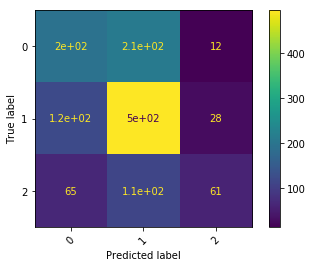

 
Classification Report
 
              precision    recall  f1-score   support

           0       0.51      0.47      0.49       416
           1       0.61      0.77      0.68       645
           2       0.60      0.25      0.36       240

    accuracy                           0.58      1301
   macro avg       0.57      0.50      0.51      1301
weighted avg       0.58      0.58      0.56      1301

 
Accuracy Score
 
0.5780169100691775


In [108]:
print('SUPPORT VECTOR MACHINE')
print(' ')
print('Confusion Matrix')
print(' ')
plot_confusion_matrix(subclf, X_dev_SVC, y_dev)  
plt.tick_params(axis='x', labelsize=10, rotation = 45)
plt.tick_params(axis='y', labelsize=10)
plt.show()
print(' ')
print('Classification Report')
print(' ')
print(classification_report(y_dev,y_pred3))
print(' ')
print('Accuracy Score')
print(' ')
print(accuracy_score(y_dev, y_pred3))

In [109]:
'''
The accuracy is pretty good (nearly 58%), so better than both KNN and RF, but always lower than Logistic/Tuned Logistic.
'''

In [110]:
'''
Let's try to make a little bit of analysis on SVC. We'll try to plot the datapoints in order to understand how they're located
in a 2D space, but before we need to reduce the number of components.
'''

pipe = Pipeline([
    ('reduction', 'passthrough'),
    ('classifier', subclf)
])

# specify selection range
param_grid = [
    {
        'reduction': [TruncatedSVD()],
        'reduction__n_components': [2]
    },
]

# fit the model to different feature sets
grid = GridSearchCV(pipe, 
                    param_grid=param_grid, 
                    cv=5, 
                    scoring='accuracy',
                    n_jobs=-1,
                   )
grid.fit(X_train_SVC, y_train)
print(grid.best_score_, grid.best_params_['reduction'])

# save the best selector
reductor = grid.best_params_['reduction'].fit(X_train_SVC, y_train)
X_train_sel5 = reductor.transform(X_train_SVC)
X_dev_sel5 = reductor.transform(X_dev_SVC)
X_test_sel5 = reductor.transform(X_test_SVC)

0.3588568239272464 TruncatedSVD()


In [111]:
'''
As we can see, by reducing the number of components to 2 we are not able to get a good accuracy. For this reason, we don't
expect clear clusters from the plot
'''

svc2 = SVC(kernel = 'sigmoid', shrinking = True, gamma = 'scale', degree = 2, C = 1, decision_function_shape = 'ovo')

svc2.fit(X_train_sel5, y_train)

SVC(C=1, decision_function_shape='ovo', degree=2, kernel='sigmoid')

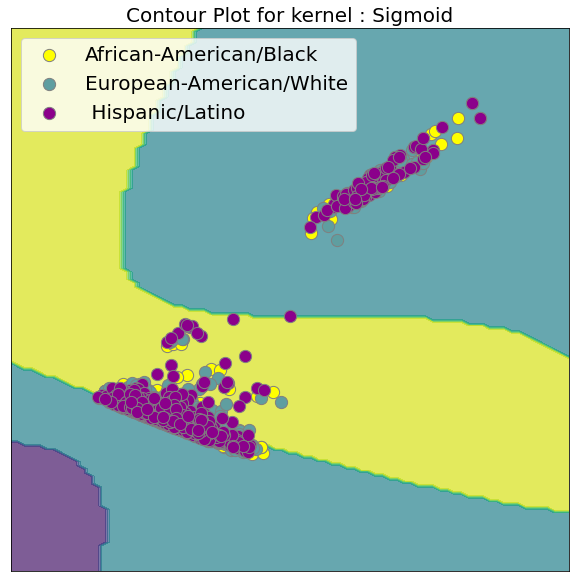

In [112]:
h = .01
#create the mesh
x_min, x_max = X_train_sel5.min() - 0.01, X_train_sel5.max() + 0.01
y_min, y_max = y_train.min() - 0.5, y_train.max() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

plt.figure(figsize=(10,10))
plt.title('Contour Plot for kernel : Sigmoid', fontsize=20)
Z = svc2.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.7)

aa = []
bb = []
for j in X_train_sel5:
    aa.append(j[0])

for j in X_train_sel5:
    bb.append(j[1])
    
v = pd.DataFrame({'label':y_train,'1':aa, '2':bb})

lo = plt.scatter(v[v['label'] == 0]['1'], v[v['label'] == 0]['2'], marker='o', s=150, edgecolor = 'grey', c = 'yellow')
ll = plt.scatter(v[v['label'] == 1]['1'], v[v['label'] == 1]['2'], marker='o', s=150, edgecolor = 'grey', c = 'cadetblue')
l  = plt.scatter(v[v['label'] == 2]['1'], v[v['label'] == 2]['2'], marker='o', s=150, edgecolor = 'grey', c = 'darkmagenta')
plt.xlim(xx.min()+0.1, xx.max()-0.1)
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.legend((lo, ll, l), ('African-American/Black', 'European-American/White', ' Hispanic/Latino'), scatterpoints=1, loc='upper left', fontsize=20)

plt.show()

In [113]:
'''
As we can clearly see, in a 2D space the results are absolutely not good. Basically, just a few data are in the correct
location. But we were expecting this, since by reducing the number of components to 2 we were getting an accuracy of the
0.358, so way lower even compared to the dummy baseline.
'''

### 7) Naive Bayes Classifier

In [114]:
vectorizer8 = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.95, 
                             analyzer='word',
                             sublinear_tf=True
                            )

X_train_NBC = vectorizer8.fit_transform(train['Desc'])
X_dev_NBC = vectorizer8.transform(dev['Desc'])
X_test_NBC = vectorizer8.transform(test['Desc'])

X_train_NBC = X_train_NBC.toarray()
X_dev_NBC = X_dev_NBC.toarray()

In [115]:
'''
Here, we try with the Naive Bayes Classifier. Basically, here there were no parameters to tune, and we decided not to input
a prior probability.
'''

nbc = GaussianNB()

nbc.fit(X_train_NBC,y_train)

y_pred8 = nbc.predict(X_dev_NBC)

NAIVE BAYES CLASSIFIER
 
Confusion Matrix
 


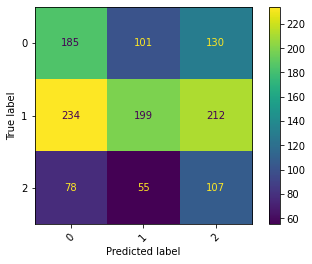

 
Classification Report
 
              precision    recall  f1-score   support

           0       0.37      0.44      0.41       416
           1       0.56      0.31      0.40       645
           2       0.24      0.45      0.31       240

    accuracy                           0.38      1301
   macro avg       0.39      0.40      0.37      1301
weighted avg       0.44      0.38      0.38      1301

 
Accuracy Score
 
0.377401998462721


In [116]:
print('NAIVE BAYES CLASSIFIER')
print(' ')
print('Confusion Matrix')
print(' ')
plot_confusion_matrix(nbc, X_dev_NBC, y_dev)  
plt.tick_params(axis='x', labelsize=10, rotation = 45)
plt.tick_params(axis='y', labelsize=10)
plt.show()
print(' ')
print('Classification Report')
print(' ')
print(classification_report(y_dev,y_pred8))
print(' ')
print('Accuracy Score')
print(' ')
print(accuracy_score(y_dev, y_pred8))

In [117]:
''' 
Here, results are particularly not good, even worse than the dummy baseline. Probably Naive Bayes is not particularly
suitable for our data.
'''

In [118]:
pred2nbc = nbc.predict_proba(X_dev_NBC)

print('With threshold = {0} for African-American, we get accuracy = {1}, with a difference of {2} with the starting accuracy'.format(round(funzione_accuracy(pred2nbc, 0, 1, 2)[0],2), funzione_accuracy(pred2nbc, 0, 1, 2)[1], (funzione_accuracy(pred2nbc, 0, 1, 2)[1] - accuracy_score(y_dev, y_pred8))))
print(' ')
print('With threshold = {0} for White-American, we get accuracy = {1}, with a difference of {2} with the starting accuracy'.format(round(funzione_accuracy(pred2nbc, 1, 0, 2)[0],2), funzione_accuracy(pred2nbc, 1, 0, 2)[1], (funzione_accuracy(pred2nbc, 1, 0, 2)[1]- accuracy_score(y_dev, y_pred8))))
print(' ')
print('With threshold = {0} for Hispanic, we get accuracy = {1}, with a difference of {2} with the starting accuracy'.format(round(funzione_accuracy(pred2nbc, 2, 0, 1)[0],2), funzione_accuracy(pred2nbc, 2, 0, 1)[1], (funzione_accuracy(pred2nbc, 2, 0, 1)[1] - accuracy_score(y_dev, y_pred8))))

With threshold = 0.74 for African-American, we get accuracy = 0.3781706379707917, with a difference of 0.000768639508070712 with the starting accuracy
 
With threshold = 0.05 for White-American, we get accuracy = 0.3781706379707917, with a difference of 0.000768639508070712 with the starting accuracy
 
With threshold = 0.05 for Hispanic, we get accuracy = 0.377401998462721, with a difference of 0.0 with the starting accuracy


In [119]:
'''
Even if we change the thresholds, we can see that the improvements are really poor.
'''

### 8) XGBoost Classifier

In [120]:
vectorizer4 = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.95, 
                             analyzer='word',
                             sublinear_tf=True
                            )

X_train_XGB = vectorizer4.fit_transform(train['Desc'])
X_dev_XGB = vectorizer4.transform(dev['Desc'])
X_test_XGB = vectorizer4.transform(test['Desc'])

In [121]:
parameters ={
            'learning_rate': [0.05, 0.1],
            'n_estimators': [100, 150],
            'gamma': [0, 0.1],
            'min_child_weight': [0.5, 1],
            'max_delta_step': [0],
            'colsample_bytree': [0.6, 0.8, 1]
            }

xgb_model = XGBClassifier(silent = True,
                          random_state = 42)

gcvcl = GridSearchCV(xgb_model, parameters, scoring = 'accuracy', n_jobs = -1, cv = 5)

gcvcl.fit(X_train_XGB, y_train)

In [122]:
gcvcl.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'min_child_weight': 0.5,
 'n_estimators': 150}

In [123]:
'''
Here we try another complex algorithm, basing on Boosting. The algorithm here is XGBoost, and again after having tuned
its hyperparameters we try to make the prediction.
'''

xgb = XGBClassifier(objective = 'multi:softprob',
                    eval_metric = 'mlogloss',
                    colsample_bytree = 0.8,
                    gamma = 0.1,
                    learning_rate = 0.1,
                    max_delta_step = 0,
                    min_child_weight = 0.5,
                    n_estimators = 150)

xgb.fit(X_train_XGB,y_train)

y_pred4 = xgb.predict(X_dev_XGB)

XGBOOST CLASSIFIER
 
Confusion Matrix
 


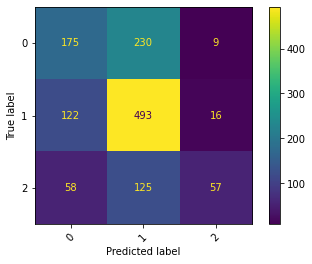

 
Classification Report
 
              precision    recall  f1-score   support

           0       0.49      0.42      0.46       414
           1       0.58      0.78      0.67       631
           2       0.70      0.24      0.35       240

    accuracy                           0.56      1285
   macro avg       0.59      0.48      0.49      1285
weighted avg       0.57      0.56      0.54      1285

 
Accuracy Score
 
0.5642023346303502


In [124]:
print('XGBOOST CLASSIFIER')
print(' ')
print('Confusion Matrix')
print(' ')
plot_confusion_matrix(xgb, X_dev_XGB, y_dev)  
plt.tick_params(axis='x', labelsize=10, rotation = 45)
plt.tick_params(axis='y', labelsize=10)
plt.show()
print(' ')
print('Classification Report')
print(' ')
print(classification_report(y_dev,y_pred4))
print(' ')
print('Accuracy Score')
print(' ')
print(accuracy_score(y_dev, y_pred4))

In [125]:
'''
Results are pretty good, but again we are not able to overcome the accuracy of the two Logistic Regressions.
'''

In [126]:
xgbproba = xgb.predict_proba(X_dev)

print('With threshold = {0} for African-American, we get accuracy = {1}, with a difference of {2} with the starting accuracy'.format(round(funzione_accuracy(xgbproba, 0, 1, 2)[0],2), funzione_accuracy(xgbproba, 0, 1, 2)[1], (funzione_accuracy(xgbproba, 0, 1, 2)[1] - accuracy_score(y_dev, y_pred4))))
print(' ')
print('With threshold = {0} for White-American, we get accuracy = {1}, with a difference of {2} with the starting accuracy'.format(round(funzione_accuracy(xgbproba, 1, 0, 2)[0],2), funzione_accuracy(xgbproba, 1, 0, 2)[1], (funzione_accuracy(xgbproba, 1, 0, 2)[1]  - accuracy_score(y_dev, y_pred4))))
print(' ')
print('With threshold = {0} for Hispanic, we get accuracy = {1}, with a difference of {2} with the starting accuracy'.format(round(funzione_accuracy(xgbproba, 2, 0, 1)[0],2), funzione_accuracy(xgbproba, 2, 0, 1)[1], (funzione_accuracy(xgbproba, 2, 0, 1)[1] - accuracy_score(y_dev, y_pred4))))

With threshold = 0.4 for African-American, we get accuracy = 0.5757109915449654, with a difference of 0.00384319754035356 with the starting accuracy
 
With threshold = 0.43 for White-American, we get accuracy = 0.5695618754803997, with a difference of -0.002305918524212136 with the starting accuracy
 
With threshold = 0.36 for Hispanic, we get accuracy = 0.5734050730207533, with a difference of 0.001537279016141424 with the starting accuracy


In [127]:
'''
By changing the thresholds, we can see that the main increase comes from the change of African-American/Black people, with
an increase of 0.003 of the accuracy.
'''

### 9) Perceptron

In [128]:
'''
Here, we introduce the Perceptron in the classification. As we know, perceptron is a binary classifier, so for this reason
we decided to go with an approach of ONEvsALL in order to get a multilabel classifier. Moreover, we decided to change even here
the threshold for the activation function, in order to 'tune' even this algorithm.
'''

In [129]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.where(x > 0, x, 0)


class Perceptron:
    def __init__(self, num_inputs, param, funzione):
        self.w1 = np.random.random(num_inputs) * 0.01
        self.b1 = 1
        self.param = param
        self.funzione = funzione

    def predict(self, X):
        activation = np.dot(X, self.w1) + self.b1
        fX = self.funzione(activation)
        y = np.where(fX >= self.param, 1, -1)
        return y
    
    def predict_proba(self, X):
        activation = np.dot(X, self.w1) + self.b1
        fX = self.funzione(activation)
        y = fX, 1-fX
        
        d = []
        
        for i in range(len(y[0])):
            d.append([y[0][i], y[1][i]])
        return d

    def fit(self, train_data, train_labels, num_epochs=50):
        for epoch in range(1, num_epochs+1):
            for (X, y) in zip(train_data, train_labels):
                pred_label = self.predict(X)

                if pred_label != y:
                    self.w1 = self.w1 + (X * y)
                    self.b1 = self.b1 + y
        
        return None

In [130]:
'''
Now that we have the class ready, we start with the approach
'''
tfidf = TfidfVectorizer(ngram_range=(1,2), 
                        min_df=0.01, 
                        max_df=0.95, 
                        sublinear_tf=True, 
                        stop_words='english')

selector = SelectKBest(k=400, score_func=chi2)

train = criminali_refined.iloc[:3904, :]
dev = criminali_refined.iloc[3904:3904+1301, :]

# select dev data
z = dev.Race.map({'African-American/Black':1 , 'Hispanic/Latino':2, 'European-American/White':3}).values

acc = [[] for i in range(2)]
j = np.arange(0.1,0.9,0.01)
lista_funz = [sigmoid,relu]

for ind in range(len(lista_funz)):
    for i in j:
        print('Starting with {}'.format(round(i,2)))
        # BLACK VS ALL
  
        X = tfidf.fit_transform(train['Desc'])
        y = train.Race.map({'African-American/Black':-1, 'European-American/White':1, 'Hispanic/Latino':1}).values
        X = selector.fit_transform(X, y).todense().A
        
        Z = selector.transform(tfidf.transform(dev['Desc'])).todense().A
        
        p = Perceptron(num_inputs=400,param=i, funzione = lista_funz[ind])
        p.fit(X, y)
        predictions_BvsR = p.predict(Z)
        predictions_BvsR_proba = p.predict_proba(Z)
        
        # WHITE VS ALL

        X = tfidf.fit_transform(train['Desc'])
        y = train.Race.map({'African-American/Black':1, 'European-American/White':-1, 'Hispanic/Latino':1}).values
        X = selector.fit_transform(X, y).todense().A
        
        p = Perceptron(num_inputs=400,param=i, funzione = lista_funz[ind])
        p.fit(X, y)
        predictions_WvsR = p.predict(Z)
        predictions_WvsR_proba = p.predict_proba(Z)
        
        # HISPANIC VS ALL
 
        X = tfidf.fit_transform(train['Desc'])
        y = train.Race.map({'African-American/Black':1, 'European-American/White':1, 'Hispanic/Latino':-1}).values
        X = selector.fit_transform(X, y).todense().A
        
        p = Perceptron(num_inputs=400,param=i, funzione = lista_funz[ind])
        p.fit(X, y)
        predictions_ISPvsR = p.predict(Z)
        predictions_ISPvsR_proba = p.predict_proba(Z)
        
        ISP_PR = [predictions_ISPvsR_proba[i][1] for i in range(len(predictions_ISPvsR_proba))]
        B_PR = [predictions_BvsR_proba[i][1] for i in range(len(predictions_BvsR_proba))]
        W_PR = [predictions_WvsR_proba[i][1] for i in range(len(predictions_WvsR_proba))]
        
        propro = np.array([B_PR, ISP_PR, W_PR]).T 
        
        a = np.array([predictions_BvsR, predictions_ISPvsR, predictions_WvsR]).T
    
        b = np.zeros((1301,1),dtype=int)
        
        for k in range(len(a)):
            if a[k][0] == -1 and a[k][1] == 1 and a[k][2] == 1:
                b[k] = 1
            elif a[k][0] == 1 and a[k][1] == -1 and a[k][2] == 1:
                b[k] = 2
            elif a[k][0] == 1 and a[k][1] == 1 and a[k][2] == -1:
                b[k] = 3
            else:
                b[k] = np.argmax(propro[k])+1
            
        acc[ind].append([round(i,2),accuracy_score(z, b)])

Starting with 0.1
Starting with 0.11
Starting with 0.12
Starting with 0.13
Starting with 0.14
Starting with 0.15
Starting with 0.16
Starting with 0.17
Starting with 0.18
Starting with 0.19
Starting with 0.2
Starting with 0.21
Starting with 0.22
Starting with 0.23
Starting with 0.24
Starting with 0.25
Starting with 0.26
Starting with 0.27
Starting with 0.28
Starting with 0.29
Starting with 0.3
Starting with 0.31
Starting with 0.32
Starting with 0.33
Starting with 0.34
Starting with 0.35
Starting with 0.36
Starting with 0.37
Starting with 0.38
Starting with 0.39
Starting with 0.4
Starting with 0.41
Starting with 0.42
Starting with 0.43
Starting with 0.44
Starting with 0.45
Starting with 0.46
Starting with 0.47
Starting with 0.48
Starting with 0.49
Starting with 0.5
Starting with 0.51
Starting with 0.52
Starting with 0.53
Starting with 0.54
Starting with 0.55
Starting with 0.56
Starting with 0.57
Starting with 0.58
Starting with 0.59
Starting with 0.6
Starting with 0.61
Starting with 0.62

In [131]:
list_accuracy_sigmoid = [i[1] for i in acc[0]]
list_threshold_sigmoid = [round(i[0],2) for i in acc[0]]

print('Optimal threshold for SIGMOID function is : {}'.format(list_threshold_sigmoid[np.argmax(list_accuracy_sigmoid)]))
print('Given that optimal threshold, best accuracy for SIGMOID FUNCTION is: {}'.format(list_accuracy_sigmoid[np.argmax(list_accuracy_sigmoid)]))

print(' ')

list_accuracy_relu = [i[1] for i in acc[1]]
list_threshold_relu = [round(i[0],2) for i in acc[1]]

print('Optimal threshold for RELU function is : {}'.format(list_threshold_relu[np.argmax(list_accuracy_relu)]))
print('Given that optimal threshold, best accuracy for RELU FUNCTION is: {}'.format(list_accuracy_relu[np.argmax(list_accuracy_relu)]))

Optimal threshold for SIGMOID function is : 0.16
Given that optimal threshold, best accuracy for SIGMOID FUNCTION is: 0.48424289008455035
 
Optimal threshold for RELU function is : 0.37
Given that optimal threshold, best accuracy for RELU FUNCTION is: 0.49500384319754037


In [132]:
'''
As we can see, both the activation function don't result in a very good predictive performance (it's very similar to the one
of the baseline), but we can see that the RELU function performs a bit better than the SIGMOID function.
'''

### 10) LSTM Model

In [133]:
'''
Here we introduce the LSTM neural network for the classification, in order to understand if this Neural Net can overcome
the two logistic regression.
'''

In [134]:
target = 'Race'
input_column = 'Desc'

'''
We use as test_data the development set, and as dev and train a subset of training set
'''

train_data = train[0:3084,:]
dev_data = train[3084:,:]
test_data = dev

train_instances = train_data[input_column].apply(str).apply(str.split)
train_labels = train_data[target]

wordset, labelset = set(), set()

labelset.update(set(criminali_refined[target]))

for words in train_instances:
    wordset.update(set(words))

PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  
word2int[UNK] = 1  
 
label2int = {label: i for i, label in enumerate(sorted(labelset))}

int2label = {i:label for label, i in label2int.items()}


def convert2ints(instances):
    result = []
    for words in instances:
        word_ints = [word2int.get(word, 1) for word in words]
        result.append(word_ints)
    return result
                          
train_instances_int = convert2ints(train_instances)
train_labels_int = [label2int[label] for label in train_labels]

In [135]:
'''
Now we go for the conversion of data.
'''
test_instances = test_data[input_column].apply(str).apply(str.split)
test_labels = test_data[target]

test_instances_int = convert2ints(test_instances)
test_labels_int = [label2int[label] for label in test_labels]

dev_instances = dev_data[input_column].apply(str).apply(str.split)
dev_labels = dev_data[target]

dev_instances_int = convert2ints(dev_instances)
dev_labels_int = [label2int[label] for label in dev_labels]

In [136]:
train_labels_1hot = to_categorical(train_labels_int, len(label2int))
test_labels_1hot = to_categorical(test_labels_int, len(label2int))
dev_labels_1hot = to_categorical(dev_labels_int, len(label2int))

train_labels_1hot[0]

array([1., 0., 0.], dtype=float32)

In [137]:
L = sorted(map(len, train_instances))
MAX_LENGTH = L[int(len(L)*0.95)]
print(MAX_LENGTH)

from keras.preprocessing.sequence import pad_sequences
train_instances_int = pad_sequences(train_instances_int, padding='post', maxlen=MAX_LENGTH)
test_instances_int = pad_sequences(test_instances_int, padding='post', maxlen=MAX_LENGTH)
dev_instances_int = pad_sequences(dev_instances_int, padding='post', maxlen=MAX_LENGTH)

print(train_instances[0], len(train_instances[0]))
print(train_instances_int[0], len(train_instances_int[0]))

51
['john', 'edward', 'pittman', 'shoot', 'kill', 'officer', 'david', 'driskell', 'follow', 'car', 'chase'] 11
[4403 2674 6413 7651 4564 5944 2142 2571 3187 1281 1475    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0] 51


In [138]:
np.random.seed(42)

embedding_dim = 64
nb_filter = 64
filter_length = 3
hidden_dims = 32
stride_length = 1

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(len(word2int), 
                       embedding_dim, 
                       input_length=MAX_LENGTH)(inputs)
convolution = Conv1D(filters=nb_filter, 
                    kernel_size=filter_length, 
                    padding='same',  
                    activation='relu',
                    strides=stride_length)(embeddings)
convolution2 = Activation(activation='tanh')(convolution)
pooling = GlobalMaxPooling1D()(convolution2)
dropout1 = Dropout(0.2)(pooling)
dense = Dense(hidden_dims, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense)
output = Dense(len(label2int), activation='softmax')(dropout2)

model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        (None, 51)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 51, 64)            602624    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 51, 64)            12352     
_________________________________________________________________
activation_1 (Activation)    (None, 51, 64)            0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
__________

In [139]:
'''
We decide to go with batch_size of 64 and 5 epochs.
'''

batch_size = 64
epochs = 5

history = model.fit(train_instances_int, train_labels_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(dev_instances_int, dev_labels_1hot)
                   )

loss, accuracy = model.evaluate(test_instances_int, test_labels_1hot,
                                batch_size=batch_size,
                                verbose=False)

print("\nTesting Accuracy:  {:.4f}".format(accuracy))

Train on 3904 samples, validate on 1301 samples
Epoch 1/5
3904/3904 [==============================] - 2s 600us/step - loss: 0.0078 - acc: 0.9982 - val_loss: 2.1589 - val_acc: 0.5419
Epoch 2/5
3904/3904 [==============================] - 2s 639us/step - loss: 0.0104 - acc: 0.9980 - val_loss: 2.1158 - val_acc: 0.5550
Epoch 3/5
3904/3904 [==============================] - 3s 727us/step - loss: 0.0064 - acc: 0.9987 - val_loss: 2.1826 - val_acc: 0.5527
Epoch 4/5
3904/3904 [==============================] - 3s 743us/step - loss: 0.0076 - acc: 0.9987 - val_loss: 2.1716 - val_acc: 0.5473
Epoch 5/5
3904/3904 [==============================] - 3s 741us/step - loss: 0.0095 - acc: 0.9980 - val_loss: 2.1641 - val_acc: 0.5550

Testing Accuracy:  0.5311


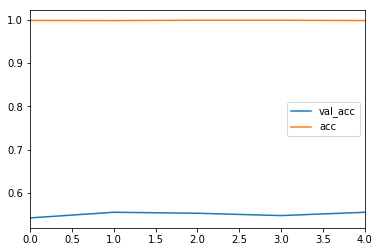

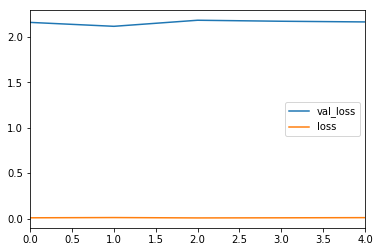

In [140]:
%matplotlib inline
df = pd.DataFrame(history.history)
df[['val_acc', 'acc']].plot.line();
df[['val_loss', 'loss']].plot.line();

In [141]:
'''
as we can see, the accuracy is even lower than XGBoost, KNN and RF classifiers. The Neural Net performs better than the 
dummy baseline, but it's not able to get a very good accuracy. Probably the fact that we have few data has an influence
on the results.
'''

So best model is **Tuned Logistic Regression**. Let's now try to act a little bit on it. Remember that the accuracy of the starting
one was 0.6164488854727133

### 11) Analysis on best model: Logistic Regression Feature Selection

In [142]:
'''
Here, we want to see what are the most important words inside our model. Problem is that in order to get words, and not char,
we need to move the analyzer from char to word. For this reason, accuracy goes down,  but we manage to understand a little
bit more of our data and of which are the most important words, or list of words, that are important in order to retrieve the 
race of the killed guy.
'''
vectorizer001 = TfidfVectorizer(ngram_range=(2,6), 
                             min_df=0.001, 
                             max_df=0.95, 
                             analyzer='word',
                             sublinear_tf=True
                            )

X_train_Log1 = vectorizer001.fit_transform(train['Desc'])
X_dev_Log1 = vectorizer001.transform(dev['Desc'])
X_test_Log1 = vectorizer001.transform(test['Desc'])

LogClass10 = LogisticRegression()
LogClass10.fit(X_train_Log1,y_train)

pipe = Pipeline([
    ('selector', 'passthrough'),
    ('classifier', LogClass10) 
]

param_grid = [
    {
        'selector': [SelectKBest(chi2)],
        'selector__k': [4500, 4250, 4000, 3750, 3500, 3250, 
                        3000, 2750, 2500, 2250, 2000, 1750,
                        1500, 1250, 1000, 750, 500]
    },
]

grid = GridSearchCV(pipe, 
                    param_grid=param_grid, 
                    cv=5, 
                    scoring='accuracy',
                    n_jobs=-1,
                   )
grid.fit(X_train_Log1, y_train)
print(grid.best_score_, grid.best_params_['selector'])

selector = grid.best_params_['selector'].fit(X_train_Log1, y_train)
X_train_sel = selector.transform(X_train_Log1)
X_dev_sel = selector.transform(X_dev_Log1)
X_test_sel = selector.transform(X_test_Log1)

0.48156111494139664 SelectKBest(k=3000, score_func=<function chi2 at 0x000001A1F77708C8>)


In [143]:
'''
KBest result is 3000, with an accuracy of 0.481 (very similar to the one we got in the normal one with analyzer word).
'''

lgcreg2 = LogisticRegression()

lgcreg2.fit(X_train_sel, y_train)

predictions_sel = lgcreg2.predict(X_dev_sel)

KBEST ON TUNED LR
 
Confusion Matrix
 


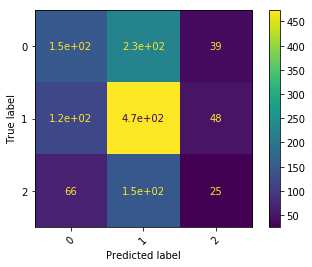

 
Classification Report
 
              precision    recall  f1-score   support

           0       0.44      0.36      0.40       416
           1       0.56      0.73      0.63       645
           2       0.22      0.10      0.14       240

    accuracy                           0.50      1301
   macro avg       0.41      0.40      0.39      1301
weighted avg       0.46      0.50      0.47      1301

 
Accuracy Score
 
0.49961568024596464


In [144]:
print('KBEST ON TUNED LR')
print(' ')
print('Confusion Matrix')
print(' ')
plot_confusion_matrix(lgcreg2, X_dev_sel, y_dev)  
plt.tick_params(axis='x', labelsize=10, rotation = 45)
plt.tick_params(axis='y', labelsize=10)
plt.show()
print(' ')
print('Classification Report')
print(' ')
print(classification_report(y_dev,predictions_sel))
print(' ')
print('Accuracy Score')
print(' ')
print(accuracy_score(y_dev, predictions_sel))

In [145]:
'''
Now that we built our dataframe, let's get the names of the feature and understand which are the most important ones for 
our prediction.
'''
features = vectorizer001.get_feature_names()
num_feats = len(features)

top_scores = selector.scores_.argsort()[-num_feats:]

best_indicator_terms = [features[i] for i in sorted(top_scores)] 

top_class = [LogClass10.classes_[c] for c in LogClass10.coef_.argmax(axis=0)]
v1 = list(map(lambda x: x if x != 0 else 'African-American/Black', top_class))
v2 = list(map(lambda x: x if x != 1 else 'European-American/White', v1))
top_class_new = list(map(lambda x: x if x != 2 else 'Hispanic/Latino', v2))

top_indicator_scores = pd.DataFrame(data={'feature': best_indicator_terms, 
                                          'class': top_class_new,
                                          'coefficient': LogClass10.coef_.max(axis=0)})

top_indicator_scores.sort_values('coefficient', ascending=False, inplace=True)
top_indicator_scores.head(10)

,class,coefficient,feature
3303,European-American/White,1.625825,state trooper
318,Hispanic/Latino,1.542595,border patrol
3821,Hispanic/Latino,1.450505,year_old latino
3630,Hispanic/Latino,1.341935,undocumented immigrant
2165,Hispanic/Latino,1.301386,officer report
2631,African-American/Black,1.235940,put knife
2123,Hispanic/Latino,1.206804,officer matthew
3571,Hispanic/Latino,1.191868,try flee
3827,European-American/White,1.162679,year_old white
3039,African-American/Black,1.141972,shoot back


In [146]:
'''
Result is very interesting. From this dataframe we can infer that when the algorithm is meeting the words
'undocumented immigrant', most of the times this means that the killed guy is an Hispanic, and if we think about it, in the
last 20 years police malice against immigrants has been a massive problem in U.S.
Another interesting thing is, for example, the fact that 'shoot back' is very important for African-American. This means that
probably most of the times, in the fatalities were an African American was involved, a random police officer was induced to kill
the guy because of the fact that the guy started shooting against him. 
'''

### 12) Analysis on best model: Tuned Logistic Regression Dimensionality Reduction

In [147]:
'''
Here we take our best model (Tuned Logistic Regression), and we try to apply Dimensionality Reduction to it, in order to 
understand if the model has a similar accuracy even with a reduction of the complexity.
'''
pipe = Pipeline([
    ('reduction', 'passthrough'),
    ('classifier', lgcreg1)
])

param_grid = [
    {
        'reduction': [TruncatedSVD()],
        'reduction__n_components': [400, 350, 300, 250, 
                                    200, 150, 100, 50]
    },
]

grid = GridSearchCV(pipe, 
                    param_grid=param_grid, 
                    cv=5, 
                    scoring='accuracy',
                    n_jobs=-1,
                   )
grid.fit(X_train_Log, y_train)
print(grid.best_score_, grid.best_params_['reduction'])

reductor = grid.best_params_['reduction'].fit(X_train_Log, y_train)
X_train_sel1 = reductor.transform(X_train_Log)
X_dev_sel1 = reductor.transform(X_dev_Log)
X_test_sel1 = reductor.transform(X_test_Log)

0.5978420171377918 TruncatedSVD(n_components=400)


In [148]:
lgcreg3 = LogisticRegression(C = 5, penalty = 'l1', solver = 'saga')

lgcreg3.fit(X_train_sel1, y_train)

predictions_sel2 = lgcreg3.predict(X_dev_sel1)

KBEST ON TUNED LR
 
Confusion Matrix
 


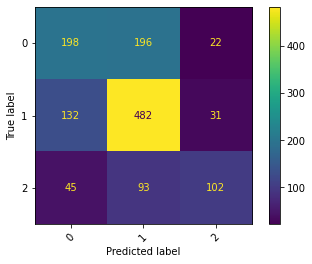

 
Classification Report
 
              precision    recall  f1-score   support

           0       0.53      0.48      0.50       416
           1       0.63      0.75      0.68       645
           2       0.66      0.42      0.52       240

    accuracy                           0.60      1301
   macro avg       0.60      0.55      0.57      1301
weighted avg       0.60      0.60      0.59      1301

 
Accuracy Score
 
0.601076095311299


In [149]:
print('KBEST ON TUNED LR')
print(' ')
print('Confusion Matrix')
print(' ')
plot_confusion_matrix(lgcreg3, X_dev_sel1, y_dev)  
plt.tick_params(axis='x', labelsize=10, rotation = 45)
plt.tick_params(axis='y', labelsize=10)
plt.show()
print(' ')
print('Classification Report')
print(' ')
print(classification_report(y_dev,predictions_sel2))
print(' ')
print('Accuracy Score')
print(' ')
print(accuracy_score(y_dev, predictions_sel2))

In [150]:
'''
From what we can see, accuracy dropped of just 1%, but with a great reduction in complexity.
'''

### 13) Bootstrap

In [151]:
'''
Now we apply BOOTSTRAP to understand if the difference between our BEST MODEL and the TWO BASELINES is statistically significant
or not.
'''

def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    N = len(gold)
    
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)
    print("Base difference: {} vs. {}".format(base_score1, base_score2))
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
    
        sample = np.random.choice(N, size=N, replace=True)
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

Base difference: 0.6225980015372791 vs. 0.4957724827056111
0.0 True


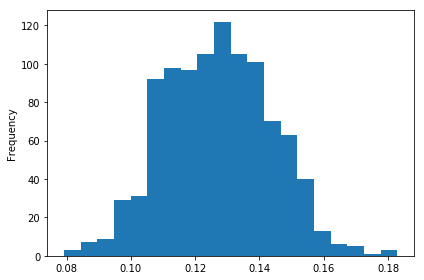

In [152]:
'''
Comparison between our best model and dummy baseline. For the best model, we chose the TUNED LOGISTIC REGRESSION where we
changed the threshold for the hispanic people
'''
pred_for_log_proba = lgcreg1.predict_proba(X_dev_Log)
yy_predd_log_thresh = np.zeros((len(y_dev),1))

for i in range(len(pred_for_log_proba)):
    if pred_for_log_proba[i][2] >= 0.45:
        yy_predd_log_thresh[i] = 2
    else:
        if np.argmax(np.hstack([pred_for_log_proba[i][0],pred_for_log_proba[i][1]])) == 0:
            yy_predd_log_thresh[i] = 0
        elif np.argmax(np.hstack([pred_for_log_proba[i][0],pred_for_log_proba[i][1]])) == 1:
            yy_predd_log_thresh[i] = 1

p_value, deltas = bootstrap_sample(yy_predd_log_thresh, dumb_predictions, y_dev)
print(p_value, p_value < 0.01)

%matplotlib inline
import pandas as pd
pd.Series(deltas).plot.hist(bins=20)
plt.tight_layout()

In [153]:
'''
As it is evident, the difference between the two accuracy is significant.
'''

Base difference: 0.6225980015372791 vs. 0.606456571867794
0.072 False


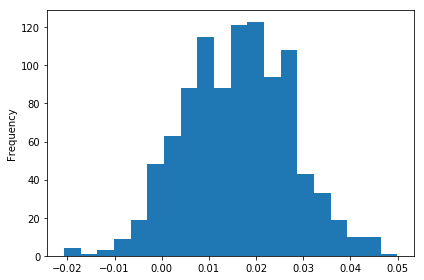

In [154]:
'''
Comparison between our best model and logistic baseline. For the best model, we chose the TUNED LOGISTIC REGRESSION where we
changed the threshold for the hispanic people
'''

p_value, deltas = bootstrap_sample(yy_predd_log_thresh, predictions, y_dev)
print(p_value, p_value < 0.01)

%matplotlib inline
import pandas as pd
pd.Series(deltas).plot.hist(bins=20)
plt.tight_layout()

In [155]:
'''
Here, difference in accuracy is NOT STATISTICALLY SIGNIFICANT, so we couldn't come up with any better model than the LOGISTIC
BASELINE with ANALYZER = 'char'. This is a very interesting result.
'''

### 14) Cross Validation and comparison between performances

What we're going to do now is to make a big comparison between all algorithms tried. What we want to do is to have a **10 folds cross validation approach**, in order to see firstly variability of prediction basing on data, and moreover to see if there is any algorithm that is more consistent and precise than others. Now, to compare the results of our algorithms, we will move from the DEVELOPMENT SET to the TEST SET

In [156]:
'''
What I'm doing now is to compute CROSS-VALIDATION on LSTM, preceding what follow.
'''

results3 = []
names3 = ['Long/Short-Term Memory']*10

def LSTMFUNCTION(train_data, dev_data, test_data, input_column, target):
    train_instances = train_data[input_column].apply(str).apply(str.split)
    train_labels = train_data[target]

    wordset, labelset = set(), set()
 
    labelset.update(set(criminali_refined[target]))

    for words in train_instances:
        wordset.update(set(words))
    
    PAD = '-PAD-'
    UNK = '-UNK-'
    word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
    word2int[PAD] = 0 
    word2int[UNK] = 1 
     
    label2int = {label: i for i, label in enumerate(sorted(labelset))}

    int2label = {i:label for label, i in label2int.items()}
    
    def convert2ints(instances):
        result = []
        for words in instances:
            word_ints = [word2int.get(word, 1) for word in words]
            result.append(word_ints)
        return result
        
    train_instances_int = convert2ints(train_instances)
    train_labels_int = [label2int[label] for label in train_labels]
    
    test_instances = test_data[input_column].apply(str).apply(str.split)
    test_labels = test_data[target]
    
    test_instances_int = convert2ints(test_instances)
    test_labels_int = [label2int[label] for label in test_labels]
    
    dev_instances = dev_data[input_column].apply(str).apply(str.split)
    dev_labels = dev_data[target]
    
    dev_instances_int = convert2ints(dev_instances)
    dev_labels_int = [label2int[label] for label in dev_labels]
    
    train_labels_1hot = to_categorical(train_labels_int, len(label2int))
    test_labels_1hot = to_categorical(test_labels_int, len(label2int))
    dev_labels_1hot = to_categorical(dev_labels_int, len(label2int))
    
    L = sorted(map(len, train_instances))
    MAX_LENGTH = L[int(len(L)*0.95)]

    train_instances_int = pad_sequences(train_instances_int, padding='post', maxlen=MAX_LENGTH)
    test_instances_int = pad_sequences(test_instances_int, padding='post', maxlen=MAX_LENGTH)
    dev_instances_int = pad_sequences(dev_instances_int, padding='post', maxlen=MAX_LENGTH)
    
    np.random.seed(42)
    
    embedding_dim = 64
    nb_filter = 64
    filter_length = 3
    hidden_dims = 32
    stride_length = 1
    
    inputs = Input((MAX_LENGTH, ), 
                   name='word_IDs')
    embeddings = Embedding(len(word2int), 
                           embedding_dim, 
                           input_length=MAX_LENGTH)(inputs)
    convolution = Conv1D(filters=nb_filter, 
                        kernel_size=filter_length,
                        padding='same', 
                        activation='relu',
                        strides=stride_length)(embeddings)
    convolution2 = Activation(activation='tanh')(convolution)
    pooling = GlobalMaxPooling1D()(convolution2)
    dropout1 = Dropout(0.2)(pooling)
    dense = Dense(hidden_dims, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense)
    output = Dense(len(label2int), activation='softmax')(dropout2)
    
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    batch_size = 64
    epochs = 5
    
    history = model.fit(train_instances_int, train_labels_1hot,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(dev_instances_int, dev_labels_1hot)
                       )
    
    loss, accuracy = model.evaluate(test_instances_int, test_labels_1hot,
                                    batch_size=batch_size,
                                    verbose=False)
    
    return accuracy

data = pd.read_csv('new_dataset_finale2.csv')

'''
What we do here is to manually build a cross-validation. Each time we're making train_data, dev_data and test_data round,
in order to train the model each time on a different fold of data.
'''

for i in range(0, len(data) - 650, 650):
    x = 650
    test_data = data[i:i+x]
    new = pd.concat([data[0:i],data[i+x:]])
    train_data = new[:int((len(new)/9)*8)]
    dev_data = new[int((len(new)/9)*8):]
    results3.append(LSTMFUNCTION(train_data,dev_data,test_data, 'Desc', 'Race'))

Train on 5207 samples, validate on 651 samples
Epoch 1/5
5207/5207 [==============================] - 4s 732us/step - loss: 1.0627 - acc: 0.4527 - val_loss: 1.0030 - val_acc: 0.5346
Epoch 2/5
5207/5207 [==============================] - 3s 652us/step - loss: 1.0106 - acc: 0.4688 - val_loss: 0.9740 - val_acc: 0.5407
Epoch 3/5
5207/5207 [==============================] - 3s 628us/step - loss: 0.8646 - acc: 0.6295 - val_loss: 0.9323 - val_acc: 0.5837
Epoch 4/5
5207/5207 [==============================] - 3s 640us/step - loss: 0.5477 - acc: 0.8151 - val_loss: 0.9343 - val_acc: 0.6037
Epoch 5/5
5207/5207 [==============================] - 3s 616us/step - loss: 0.2665 - acc: 0.9245 - val_loss: 1.0646 - val_acc: 0.5929
Train on 5207 samples, validate on 651 samples
Epoch 1/5
5207/5207 [==============================] - 4s 812us/step - loss: 1.0609 - acc: 0.4530 - val_loss: 0.9959 - val_acc: 0.5346
Epoch 2/5
5207/5207 [==============================] - 4s 806us/step - loss: 0.9936 - acc: 0.493

In [157]:
'''
Here we do the same thing that we did with the LSTM, but applied to perceptron.
'''

results4 = []
names4 = ['Perceptron']*10

def funzperc(train_data, dev_data, test_data):
    tfidf = TfidfVectorizer(ngram_range=(1,2), 
                        min_df=0.01, 
                        max_df=0.95, 
                        sublinear_tf=True, 
                        stop_words='english')

    selector = SelectKBest(k=400, score_func=chi2)
    
    train = pd.concat([train_data, dev_data.iloc[0:int(len(dev_data)/2),:]])
    test = pd.concat([dev_data.iloc[int(len(dev_data)/2):,:],test_data])

    z = test.Race.map({'African-American/Black':1 , 'Hispanic/Latino':2, 'European-American/White':3}).values
    i = 0.5
    lista_funz = sigmoid
    # BLACK VS ALL

    X = tfidf.fit_transform(train['Desc'])
    y = train.Race.map({'African-American/Black':-1, 'European-American/White':1, 'Hispanic/Latino':1}).values
    X = selector.fit_transform(X, y).todense().A
    
    Z = selector.transform(tfidf.transform(test['Desc'])).todense().A
    
    p = Perceptron(num_inputs=400,param=i, funzione = lista_funz)
    p.fit(X, y)
    predictions_BvsR = p.predict(Z)
    predictions_BvsR_proba = p.predict_proba(Z)
    
    # WHITE VS ALL

    X = tfidf.fit_transform(train['Desc'])
    y = train.Race.map({'African-American/Black':1, 'European-American/White':-1, 'Hispanic/Latino':1}).values
    X = selector.fit_transform(X, y).todense().A
    
    p = Perceptron(num_inputs=400,param=i, funzione = lista_funz)
    p.fit(X, y)
    predictions_WvsR = p.predict(Z)
    predictions_WvsR_proba = p.predict_proba(Z)
    
    # HISPANIC VS ALL

    X = tfidf.fit_transform(train['Desc'])
    y = train.Race.map({'African-American/Black':1, 'European-American/White':1, 'Hispanic/Latino':-1}).values
    X = selector.fit_transform(X, y).todense().A
    
    p = Perceptron(num_inputs=400,param=i, funzione = lista_funz)
    p.fit(X, y)
    predictions_ISPvsR = p.predict(Z)
    predictions_ISPvsR_proba = p.predict_proba(Z)
    
    ISP_PR = [predictions_ISPvsR_proba[i][1] for i in range(len(predictions_ISPvsR_proba))]
    B_PR = [predictions_BvsR_proba[i][1] for i in range(len(predictions_BvsR_proba))]
    W_PR = [predictions_WvsR_proba[i][1] for i in range(len(predictions_WvsR_proba))]
    
    propro = np.array([B_PR, ISP_PR, W_PR]).T 
    
    a = np.array([predictions_BvsR, predictions_ISPvsR, predictions_WvsR]).T

    b = np.zeros((len(a),1),dtype=int)
    
    for k in range(len(a)):
        if a[k][0] == -1 and a[k][1] == 1 and a[k][2] == 1:
            b[k] = 1
        elif a[k][0] == 1 and a[k][1] == -1 and a[k][2] == 1:
            b[k] = 2
        elif a[k][0] == 1 and a[k][1] == 1 and a[k][2] == -1:
            b[k] = 3
        else:
            b[k] = np.argmax(propro[k])+1
        
    return accuracy_score(z, b)

data = pd.read_csv('new_dataset_finale2.csv')

for i in range(0, len(data) - 650, 650):
    print('Starting with {}'.format(i))
    x = 650
    test_data = data[i:i+x]
    new = pd.concat([data[0:i],data[i+x:]])
    train_data = new[:int((len(new)/9)*8)]
    dev_data = new[int((len(new)/9)*8):]
    results4.append(funzperc(train_data,dev_data,test_data))

Starting with 0
Starting with 650
Starting with 1300
Starting with 1950
Starting with 2600
Starting with 3250
Starting with 3900
Starting with 4550
Starting with 5200


In [158]:
'''
Now that we did this for the two neural networks, we start doing it for the other algorithms, but with the pre-build
function of Scikit-Learn
'''

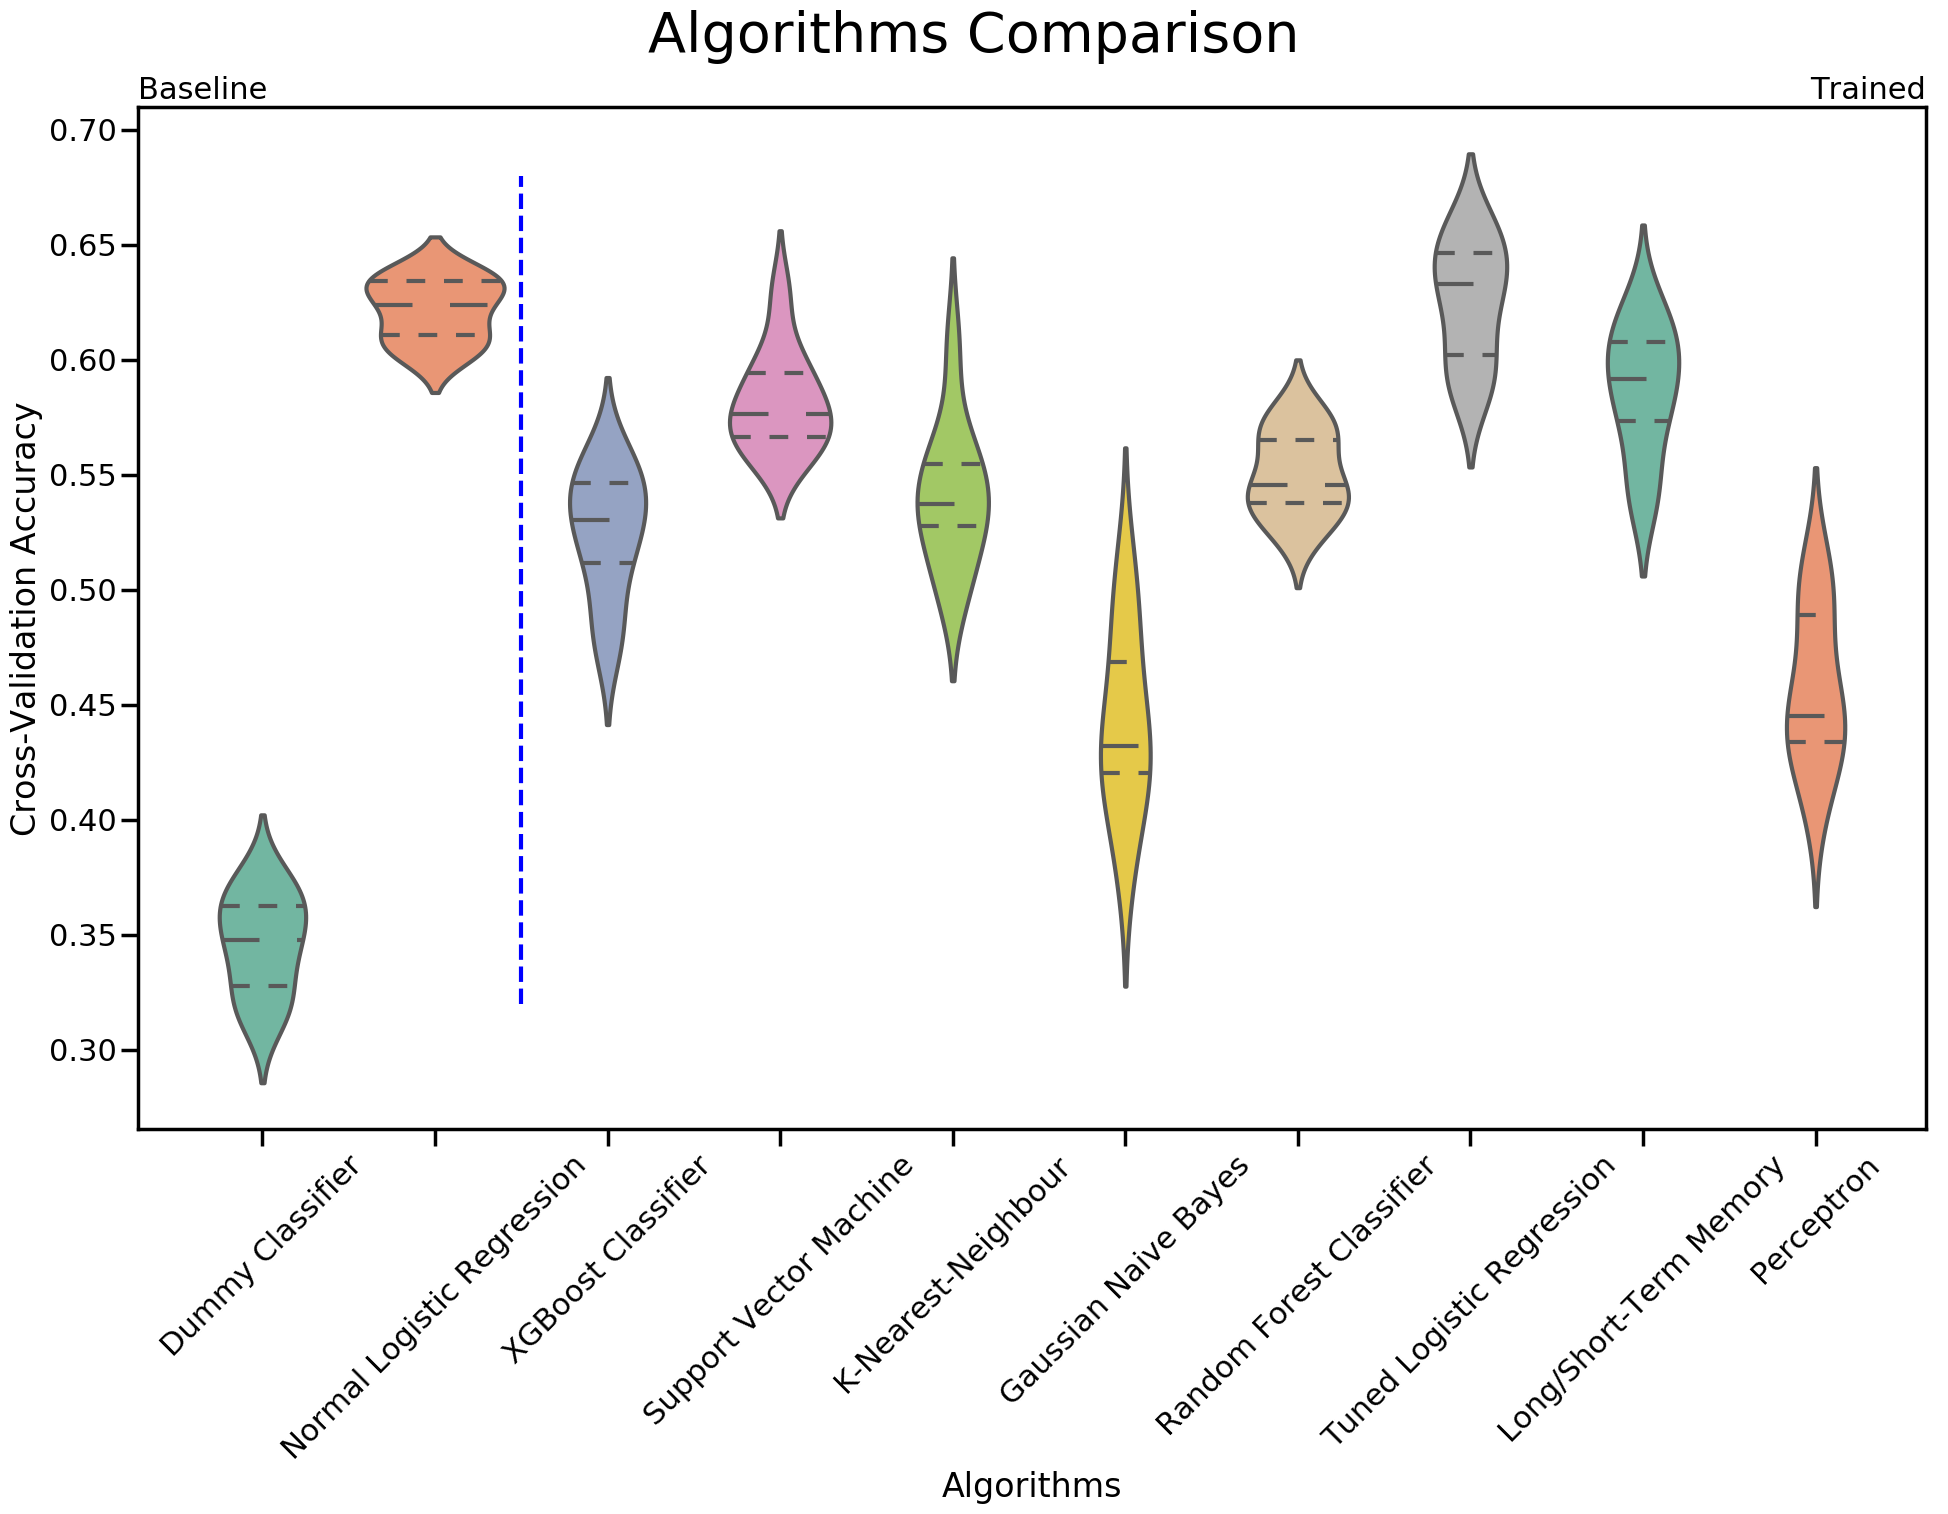

In [159]:
VECTO = TfidfVectorizer(ngram_range=(1,2), 
                        min_df=0.001, 
                        max_df=0.95, 
                        analyzer='word',
                        sublinear_tf=True
                        )

new = pd.concat([train['Desc'], dev['Desc'], test['Desc']])

X = VECTO.fit_transform(new)
y = pd.concat([train[target],dev[target], test[target]])

models = []
models.append(('Dummy Classifier', DummyClassifier()))
models.append(('Random Forest Classifier', RandomForestClassifier(bootstrap = False,
                                                                  criterion = 'entropy',
                                                                  max_features = 'sqrt',
                                                                  n_estimators = 300,
                                                                  n_jobs = -1,
                                                                  oob_score = False)))
models.append(('XGBoost Classifier', XGBClassifier(objective = 'multi:softprob',
                                                   eval_metric = 'mlogloss',
                                                   colsample_bytree = 0.8,
                                                   gamma = 0.1,
                                                   learning_rate = 0.1,
                                                   max_delta_step = 0,
                                                   min_child_weight = 0.5,
                                                   n_estimators = 150)))
models.append(('Support Vector Machine', SVC(kernel = 'sigmoid',
                                             shrinking = True, 
                                             gamma = 'scale', 
                                             degree = 2, 
                                             C = 1, 
                                             decision_function_shape = 'ovo')))
models.append(('K-Nearest-Neighbour', KNeighborsClassifier(weights = 'distance',
                                                           algorithm = 'auto',
                                                           n_neighbors=19)))

results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

models1a = []
results1a = []
names1a = []

models1a.append(('Gaussian Naive Bayes', GaussianNB()))
X1a = X.toarray()

scoring = 'accuracy'
for name, model in models1a:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X1a, y, cv=kfold, scoring=scoring)
    results1a.append(cv_results)
    names1a.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
vectorizerlogistic = TfidfVectorizer(ngram_range=(2,6), 
                                     min_df=0.001, 
                                     max_df=0.95, 
                                     analyzer='char',
                                     sublinear_tf=True
                                    )

models2 = []
results2 = []
names2 = []
X2 = vectorizerlogistic.fit_transform(new)
models2.append(('Normal Logistic Regression', LogisticRegression()))
models2.append(('Tuned Logistic Regression', LogisticRegression(C = 5, 
                                                                penalty = 'l1',
                                                                solver = 'saga')))

scoring = 'accuracy'
for name, model in models2:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X2, y, cv=kfold, scoring=scoring)
    results2.append(cv_results)
    names2.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

'''
Now we have all the data. Let's build our dataframe.
'''

DAT = pd.concat([pd.DataFrame({'results': [i for i in results[j]],'names': names[j]}) for j in range(len(names))])
DA = pd.concat([pd.DataFrame({'results': [i for i in results1a[j]],'names': names1a[j]}) for j in range(len(names1a))])
DATA2 = pd.concat([pd.DataFrame({'results': [i for i in results2[j]],'names': names2[j]}) for j in range(len(names2))])
DATA3 = pd.DataFrame({'results': [i for i in results3],'names': [i for i in names3]})
DATA3 = DATA3[['results','names']]
DATA4 = pd.DataFrame({'results': [i for i in results4],'names': [i for i in names4]})
DATA4 = DATA4[['results','names']]
DATA = pd.concat([DAT,DA,DATA2,DATA3, DATA4])
lista = [[0]*10,[6]*10,[2]*10,[3]*10,[4]*10,[5]*10,[1]*10, [7]*10, [8]*10, [9]*10]
a = [item for sublist in lista for item in sublist]
DATA = DATA.reset_index()
DATA = DATA.drop(['index'],axis=1)
DATA['Order'] = pd.Series(a)
DATA.columns = ['Algorithms', 'Cross-Validation Accuracy', 'Order']
DATA = DATA.sort_values(by='Order', ascending = True)

sb.set_context('poster')
fig = plt.figure(figsize = (20,15))
fig.suptitle('Algorithms Comparison', fontsize=40,  y=1.02)
plt.title('Baseline', fontsize=22, loc = 'left')
plt.title('Trained', fontsize=22, loc = 'right')
ax = fig.add_subplot(111)
sb.violinplot(x="Algorithms", y="Cross-Validation Accuracy", data=DATA, palette="Set2", inner="quartile")
ax.vlines(1.5, 0.32, 0.68,colors="b", linestyles= 'dashed')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
fig.tight_layout()
sb.reset_orig()

In [160]:
'''
From this plot we can understand many things. The baseline logistic regression is very consistent, so the accuracy over
folds doesn't vary that much. If we compare its results with the Gaussian Naive Bayes or with the Perceptron the difference
is evident: we can immediately see that there is a lot of variability between the results for each fold in these two algorithms.
Moreover, this plot confirms what we said before: Tuned Logistic Regression, for our data, is the best algorithm between
all the ones that we saw.
'''

## 4.2 Structured Prediction

In [161]:
'''
Now we start with the Structured Prediction. Our goal will be to apply Named Entity Recognition to our dataset, in order to
understand which of the Neural Networks perform better.
To do this, we had to manually label 2010 of our reports, in order to teach the context to the algorithm.
The labels that we decided to put are:
1)B-KL : Begin - Killer
2)I-KL : Inside - Killer
3)B-VC : Begin - Victim
4)I-VC : Inside - Victim
5)B-WT : Begin - Witness
6)I-WT : Inside - Witness
7)B-WP : Begin - Weapon
8)I-WP : Inside - Weapon
9)B-LOC : Begin - Location
10)I-LOC : Inside - Location
11)B-ORG : Begin - Organization
12)I-ORG : Inside - Organization
13)B-DT : Begin - Datetime
15)I-DT : Inside - Datetime

Our goal is to understand if, from a new report, the algorithm is able to understand what happened: who killed who,
the weapon used, if there was any witness, the datetime, the location and so on.
Our algorithm could ease a lot the work done in police stations: instead of manually inserting data inside a dataframe, the 
algorithm could understand it and automatically put data in the police dataset.
'''

np.set_printoptions(precision=2)

users = re.compile('@[^ ]+')
numbers = re.compile('[0-9]')
urls = re.compile("(https?:\/\/)?(?:www\.|(?!www))?[^\s\.]+\.[^\s]{2,}|(www)?\.[^\s]+\.[^\s]{2,}")

In [162]:
'''
This is to show our 'performance' in the label, in order to see if there was coherence between labelers.
'''
from quica.quica import Quica
import pandas as pd

check_dataset_final = pd.read_excel('check_final.xlsx').drop(['Unnamed: 0'],axis=1)

check_dataset_final['report'] = check_dataset_final['report'].apply(lambda x: ' '.join(eval(x)))
check_dataset_final['labels'] = check_dataset_final['labels'].apply(lambda x: ' '.join(eval(x)))
lista_names = [['Alberto']*101, ['Anna']*101, ['Aliya']*101,['Samuele']*101,['Andrea']*101,['Silvia']*101]
sublista_names = [item for sublist in lista_names for item in sublist]
check_dataset_final['names'] = sublista_names

def checkfunzione(data):
    dataframe = data
    lista1 = []
    for i in dataframe['labels']:
        lista1.append(i.split())
    return [item for sublist in lista1 for item in sublist]

ALBERTO = checkfunzione(check_dataset_final[check_dataset_final['names'] == 'Alberto'])

ANNA = checkfunzione(check_dataset_final[check_dataset_final['names'] == 'Anna'])

ALIYA = checkfunzione(check_dataset_final[check_dataset_final['names'] == 'Aliya'])

SAMUELE = checkfunzione(check_dataset_final[check_dataset_final['names'] == 'Samuele'])

ANDREA = checkfunzione(check_dataset_final[check_dataset_final['names'] == 'Andrea'])

SILVIA = checkfunzione(check_dataset_final[check_dataset_final['names'] == 'Silvia'])

dataconsistency = pd.DataFrame({'alberto':ALBERTO,
                                'anna':ANNA,
                                'aliya':ALIYA,
                                'samuele':SAMUELE,
                                'andrea':ANDREA,
                                'silvia':SILVIA})

labels = list(set(dataconsistency['alberto']))
numbers = list(range(1,16))

for i in range(len(labels)):
    dataconsistency = dataconsistency.apply(lambda x: x.replace(labels[i],numbers[i]))
    
from quica.quica import Quica

quica = Quica(dataframe=dataconsistency)
print(quica.get_results())

                         score
measure                       
Krippendorff's Alpha  0.774866
Scotts' Kappa         0.774858
Raw Agreement         0.906704
MACE                  0.868527
Fleiss'K              0.774940


In [163]:
'''
MACE coefficient is 0.868527, so it is a labeling on which we can trust on.
'''

In [164]:
'''
Head of what the dataframes we built.
'''
print('Length of the training dataframe is {}'.format(len(pd.read_csv('train_finale_NER.csv').drop(['Unnamed: 0'],axis=1))))
print(' ')
pd.read_csv('train_finale_NER.csv').drop(['Unnamed: 0'],axis=1).head()

Length of the training dataframe is 1608
 


,report,labels
0,John Edward Pittman was shot and killed by off...,B-VC I-VC I-VC O O O O O B-KL I-KL I-KL O O O O
1,An Army veteran and West Chester University st...,O O O O B-VC I-VC I-VC I-VC I-VC O O O O B-DT ...
2,Wanted for murder and described as a member of...,O O O O O O O O O O B-VC I-VC I-VC O O O B-ORG...
3,Officers killed 41-year-old Miguel Peralta Tor...,B-KL O O B-VC I-VC I-VC O O O O B-LOC I-LOC
4,CHP officers shot Jose Daniel Gonzalez when he...,B-KL B-KL O B-VC I-VC I-VC O O O O O O O O O B...


In [165]:
print('Length of the test dataframe is {}'.format(len(pd.read_csv('test_finale_NER.csv').drop(['Unnamed: 0'],axis=1))))
print(' ')
pd.read_csv('test_finale_NER.csv').drop(['Unnamed: 0'],axis=1).head()

Length of the test dataframe is 398
 


,report,labels
0,Mitchell held at least two people at gunpoint ...,B-VC O O O B-WT I-WT O O O O O B-LOC O O O O O...
1,A police sergeant spotted Imes pulling a suitc...,O O O O B-VC O O O O O O O O B-LOC I-LOC O O O...
2,Blake had been wanted in New York for the stab...,B-VC O O O O O O O O O O O O O B-WT O O O O O ...
3,Metropolitan Police responded quickly to repor...,B-KL I-KL O O O O O O O O O O O O O O B-LOC O ...
4,Montgomery was shot after firing on police who...,B-VC O O O O O B-KL O O O O O O O O O O O


In [166]:
'''
Here, we implement a Structured Perceptron that will basically understand from the context we give it as input, how to perform
NER on police reports.
'''

class StructuredPerceptron(object):

    def __init__(self):
        
        self.tags = set()
        self.feature_weights = defaultdict(lambda: defaultdict(float))
        self.weight_totals = defaultdict(lambda: defaultdict(float)) 
        self.timestamps = defaultdict(lambda: defaultdict(float)) 

        self.tag_dict = defaultdict(set)

        self.START = "__START__"
        self.END = "__END__"
        
        
    def normalize(self, word):
        
        return re.sub(urls, 'URL', re.sub(users, '@USER', re.sub(numbers, '0', word.strip().lower())))

    
    def evaluate(self, data_instances, method='greedy'):
        correct = 0
        total = 0
        for (words, tags) in data_instances:
            preds = self.predict(words, method=method)
            matches = sum(map(lambda x: int(x[0]==x[1]), zip(preds, tags)))
            correct += matches
            total += len(tags)
        return correct/total
    
    def fit(self, file_name, dev_file=None, iterations=10, learning_rate=0.25, inference='greedy', verbose=False):
        
        lista_acc = []
        
        instances = [(words, tags) for (words, tags) in self.read_conll_file(file_name)]
        for (words, tags) in instances:
            self.tags.update(set(tags))

            for word, tag in zip(words, tags):
                self.tag_dict[self.normalize(word)].add(tag)
        
        if dev_file:
            dev_instances = [(words, tags) for (words, tags) in self.read_conll_file(dev_file)]
            
        for iteration in range(1, iterations+1):
            correct = 0
            total = 0
            if verbose:
                print('Iteration {}'.format(iteration+1), file=sys.stderr, flush=True)
                print("*" * 15, file=sys.stderr, flush=True)

            random.shuffle(instances)
            for i, (words, tags) in enumerate(instances):
                if i > 0:
                    if i%1000==0:
                        print('%s'%i, file=sys.stderr, flush=True)
                    elif i%20==0:
                        print('.', file=sys.stderr, flush=True, end='')

                prediction = self.predict(words, method=inference)

                global_gold_features, global_prediction_features = self.get_global_features(words, prediction, tags)

                for tag, fids in global_gold_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] += learning_rate * count

                for tag, fids in global_prediction_features.items():
                    for fid, count in fids.items():
                        nr_iters_at_this_weight = iteration - self.timestamps[fid][tag]
                        self.weight_totals[fid][tag] += nr_iters_at_this_weight * self.feature_weights[fid][tag]
                        self.timestamps[fid][tag] = iteration
                        self.feature_weights[fid][tag] -= learning_rate * count

                correct += sum([int(predicted_tag == true_tag) for predicted_tag, true_tag in zip(prediction, tags)])
                total += len(tags)

                if verbose and i%1000==0:
                    print("current word accuracy:{:.2f}".format(correct/total))
                    print(list(zip(words, 
                                   [self.normalize(word) for word in words], 
                                   tags, 
                                   prediction)), file=sys.stderr, flush=True)
            
            print('\t{} features'.format(len(self.feature_weights)), file=sys.stderr, flush=True)
            print('\tTraining accuracy: {:.2f}\n'.format(correct/total), file=sys.stderr, flush=True)
            if dev_file:
                print('\tDevelopment accuracy: {:.2f}\n'.format(self.evaluate(dev_instances, method=inference)), file=sys.stderr, flush=True)
                lista_acc.append(self.evaluate(dev_instances, method=inference))

        for feature, tags in self.feature_weights.items():
            for tag in tags:
                total = self.weight_totals[feature][tag]
                total += (iterations - self.timestamps[feature][tag]) * self.feature_weights[feature][tag]
                averaged = round(total / float(iterations), 3)
                self.feature_weights[feature][tag] = averaged
        
        return lista_acc


    def get_features(self, word, previous_tag2, previous_tag, words, i):

        prefix = word[:3]
        suffix = word[-3:]

        features = {
                    'PREFIX={}'.format(prefix),
                    'SUFFIX={}'.format(suffix),
                    'LEN<=3={}'.format(len(word)<=3),
                    'FIRST_LETTER={}'.format(word[0]),
                    'WORD={}'.format(word),
                    'NORM_WORD={}'.format(words[i]),
                    'PREV_WORD={}'.format(words[i-1]),
                    'PREV_WORD_PREFIX={}'.format(words[i-1][:3]),
                    'PREV_WORD_SUFFIX={}'.format(words[i-1][-3:]),
                    'PREV_WORD+WORD={}+{}'.format(words[i-1], words[i]),
                    'NEXT_WORD={}'.format(words[i+1]),
                    'NEXT_WORD_PREFIX={}'.format(words[i+1][:3]),
                    'NEXT_WORD_SUFFIX={}'.format(words[i+1][-3:]),
                    'WORD+NEXT_WORD={}'.format(word, words[i+1]),
                    'NEXT_2WORDS={}+{}'.format(words[i+1], words[i+2]),
                    'PREV_TAG={}'.format(previous_tag),                
                    'PREV_TAG2={}'.format(previous_tag2),              
                    'PREV_TAG_BIGRAM={}+{}'.format(previous_tag2, previous_tag),
                    'PREV_TAG+WORD={}+{}'.format(previous_tag, word),           
                    'PREV_TAG+PREFIX={}_{}'.format(previous_tag, prefix),       
                    'PREV_TAG+SUFFIX={}_{}'.format(previous_tag, suffix),       
                    'WORD+TAG_BIGRAM={}+{}+{}'.format(word, previous_tag2, previous_tag),
                    'SUFFIX+2TAGS={}+{}+{}'.format(suffix, previous_tag2, previous_tag),
                    'PREFIX+2TAGS={}+{}+{}'.format(prefix, previous_tag2, previous_tag),
                    'BIAS'
            }
        return features
    
    
    def get_global_features(self, words, predicted_tags, true_tags):
 
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        global_gold_features = defaultdict(lambda: Counter())
        global_prediction_features = defaultdict(lambda: Counter())

        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START
        
        for j, (word, predicted_tag, true_tag) in enumerate(zip(words, predicted_tags, true_tags)):

            prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)

            global_prediction_features[predicted_tag].update(prediction_features)
            global_gold_features[true_tag].update(prediction_features)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

        return global_gold_features, global_prediction_features
            
    
    def get_scores(self, features):

        scores = defaultdict(float)

        for feature in features:
            if feature not in self.feature_weights:
                continue
            weights = self.feature_weights[feature]
            for tag, weight in weights.items():
                scores[tag] += weight

        if not scores:
            scores[list(self.tags)[0]] = 1
        
        return scores


    def predict(self, words, method='greedy'):

        if method == 'greedy':
            return self.predict_greedy(words)
        elif method == 'viterbi':
            return self.predict_viterbi(words)


    def predict_viterbi(self, words):

        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]

        N = len(words)
        M = len(self.tags)
        tags = sorted(self.tags)

        Q = np.ones((M, N)) * float('-Inf')
        backpointers = np.ones((M, N), dtype=np.int16) * -1 
        
        features = self.get_features(words[0], self.START, self.START, context, 1)
        scores = self.get_scores(features)
        allowed_initial_tags = self.tag_dict[context[1]]

        for j in range(M):
            if not allowed_initial_tags or tags[j] in allowed_initial_tags:
                Q[j,0] = scores[tags[j]]

        for i in range(1, N):
            allowed_tags = self.tag_dict[context[i+1]]

            for j in range(M):
                best_score = 0.0
                prev_tag = tags[j]

                allowed_previous_tags = self.tag_dict[context[i]]
                if allowed_previous_tags and prev_tag not in allowed_previous_tags:
                    continue

                best_before = Q[j,i-1] 
                
                for k in range(M):
                    if i == 1:
                        prev2_tag = self.START
                    else:
                        prev2_tag = tags[k]
    
                        allowed_previous2_tags = self.tag_dict[context[i-1]]
                        if allowed_previous2_tags and prev2_tag not in allowed_previous2_tags:
                            continue

                    features = self.get_features(words[i], prev2_tag, prev_tag, context, i+1)
                    scores = self.get_scores(features)

                    for t in range(M):
                        tag = tags[t]
                       
                        if not allowed_tags or tag in allowed_tags:
                            tag_score = best_before + scores[tag]

                            if tag_score > best_score:
                                Q[t,i] = tag_score
                                best_score = tag_score
                                backpointers[t,i] = j

        best_id = Q[:,-1].argmax()

        predtags = [tags[best_id]]

        for i in range(N-1,0,-1):
            idx = backpointers[best_id, i]
            predtags.append(tags[idx])
            best_id = idx

        return predtags[::-1]         

    
    def predict_greedy(self, words):
        '''
        greedy prediction
        '''
        context = [self.START] + [self.normalize(word) for word in words] + [self.END, self.END]
                
        prev_predicted_tag = self.START
        prev_predicted_tag2 = self.START

        out = []

        for j, word in enumerate(words):

            predicted_tag = list(self.tag_dict[context[j+1]])[0] if len(self.tag_dict[context[j+1]]) == 1 else None

            if not predicted_tag:
            
                prediction_features = self.get_features(word, prev_predicted_tag2, prev_predicted_tag, context, j+1)
                scores = self.get_scores(prediction_features)
                
                predicted_tag = max(scores, key=scores.get)

            prev_predicted_tag2 = prev_predicted_tag
            prev_predicted_tag = predicted_tag

            out.append(predicted_tag)

        return out
    
        
    def read_conll_file(self, file_name):

        a = pd.read_csv(file_name)
   
        A = [i for i in a['report']]
        B = [i for i in a['labels']]
   
        d = []
        for i in range(len(A)):
            d.append(list(zip([A[i].split()],[B[i].split()]))[0])
          
        return d

    def save(self, file_name):
     
        print("saving model...", end=' ', file=sys.stderr)
        with open(file_name, "wb") as model:
      
            save_feature_weights = defaultdict(lambda: defaultdict(float))
            save_feature_weights.update(self.feature_weights)
            save_tag_dict = defaultdict(set)
            save_tag_dict.update(self.tag_dict)

            save_feature_weights.default_factory = None
            save_tag_dict.default_factory = None
            pickle.dump((save_feature_weights, save_tag_dict, self.tags),
                     model, -1)
        print("done", file=sys.stderr)


    def load(self, file_name):

        print("loading model...", end=' ', file=sys.stderr)
        with open(file_name, 'rb') as model:
            try:
                parameters = pickle.load(model)
            except IOError:
                msg = ("No such model file.")
                raise MissingCorpusError(msg)

            feature_weights, tag_dict, tags = parameters
            self.tags = tags

            self.feature_weights = defaultdict(lambda: defaultdict(float))
            self.tag_dict = defaultdict(set)

            self.feature_weights.update(feature_weights)
            self.tag_dict.update(tag_dict)
        print("done", file=sys.stderr)
        return None

In [167]:
'''
This is where we fit our structured perceptron with the dataset we manually labeled, in order to teach it the context.
Method used here is GREEDY. We decided to use 8 iterations, as the epochs we will use in the NEURAL NETWORK part.
'''
sp1 = StructuredPerceptron()
inference_method = 'greedy'
sp1.fit('train_finale_NER.csv', dev_file='dev_finale_NER.csv', iterations=8, inference=inference_method)

sp.save('model_greedy.pickle')

In [168]:
'''
Here we fit the Structured perceptron but with the VITERBI method. Alsways 8 iterations.
'''

sp2 = StructuredPerceptron()
inference_method = 'viterbi'
sp2.fit('train_finale_NER.csv', dev_file='test_finale_NER.csv', iterations=8, inference=inference_method)

sp2.save('model_viterbi.pickle')

In [169]:
'''
this are the accuracy values for the validation set that we got at each iteration both from greedy and from viterbi.
'''

lista_acc_sp_greedy = [0.811884651906642, 0.839572192513369, 0.8563646359138388, 0.8620620720675696, 
                       0.8274776350642211, 0.8600129941526313, 0.8348243290519266, 0.8173322005097706]

lista_acc_sp_viterbi = [0.7664051176970363, 0.7666050277375182, 0.7663551401869159, 0.7666550052476385,
                        0.7666550052476385, 0.7663551401869159, 0.7666550052476385, 0.7666550052476385]

lista_acc_sp = [lista_acc_sp_greedy,lista_acc_sp_viterbi]

In [170]:
'''
Here we load the models we fit once, since the process takes very long.
'''

sp1 = StructuredPerceptron()
sp1.load('model_greedy.pickle')
sp2 = StructuredPerceptron()
sp2.load('model_viterbi.pickle')

loading model... done
loading model... done


### Neural Networks

In [171]:
'''
Here we move to the Neural Network, with the same goal of the structured perceptron. We will compare then performances between
the two structured perceptron, the three neural networks and the best SP vs the best NN
'''

def read_conll_file(file_name):

    a = pd.read_csv(file_name)
        
    A = [i for i in a['report']]
    B = [i for i in a['labels']]
       
    d = []
    for i in range(len(A)):
        d.append(list(zip([A[i].split()],[B[i].split()]))[0])
            
    return d

In [172]:
wordset, tagset = set(), set()
train_instances = [(words, tags) for (words, tags) in read_conll_file('train_finale_NER.csv')] 
for (words, tags) in train_instances:
    tagset.update(set(tags))
    wordset.update(set(words))

PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0 
word2int[UNK] = 1 
 
tag2int = {tag: i + 1 for i, tag in enumerate(sorted(tagset))}
tag2int[PAD] = 0

int2tag = {i:tag for tag, i in tag2int.items()}


def convert2ints(instances):
    result = []
    for (words, tags) in instances:
      
        word_ints = [word2int.get(word, 1) for word in words]
      
        tag_ints = [tag2int[tag] for tag in tags]
        result.append((word_ints, tag_ints))
    return result        

In [173]:
'''
Here we transform our data in order to have the input for the neural network.
'''
test_instances = [(words, tags) for (words, tags) in read_conll_file('test_finale_NER.csv')] 

train_instances_int = convert2ints(train_instances)
test_instances_int = convert2ints(test_instances)

train_sentences, train_tags = zip(*train_instances_int) 
test_sentences, test_tags = zip(*test_instances_int) 

print(train_instances[0][0])
print(train_sentences[0])
print(train_instances[0][1])
print(train_tags[0])

['John', 'Edward', 'Pittman', 'was', 'shot', 'and', 'killed', 'by', 'officer', 'David', 'Driskell', 'following', 'a', 'car', 'chase.']
[2514, 1802, 3371, 9168, 8293, 4616, 6822, 5086, 7362, 1614, 1758, 6202, 4454, 5118, 5189]
['B-VC', 'I-VC', 'I-VC', 'O', 'O', 'O', 'O', 'O', 'B-KL', 'I-KL', 'I-KL', 'O', 'O', 'O', 'O']
[5, 12, 12, 15, 15, 15, 15, 15, 2, 9, 9, 15, 15, 15, 15]


In [174]:
MAX_LENGTH = len(max(train_sentences, key=len)) + 5
print(MAX_LENGTH)

245


In [175]:
train_sentences = pad_sequences(train_sentences, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_sentences, maxlen=MAX_LENGTH, padding='post')
train_tags = pad_sequences(train_tags, maxlen=MAX_LENGTH, padding='post')
test_tags = pad_sequences(test_tags, maxlen=MAX_LENGTH, padding='post')
 
print(train_sentences[0])
print(train_tags[0])

[2514 1802 3371 9168 8293 4616 6822 5086 7362 1614 1758 6202 4454 5118
 5189    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [176]:
train_tags_1hot = to_categorical(train_tags, len(tag2int))
test_tags_1hot = to_categorical(test_tags, len(tag2int))

In [177]:
'''
Function to translate the numbers into tags when we'll want to test the neural network performances on real sentences.
'''

def inverse_transform(sentences, predictions):
    output = []
    for sentence, prediction in zip(sentences, predictions):
        token_sequence = [int2tag[np.argmax(prediction[i])] for i in range(len(sentence))]
        output.append(token_sequence)
    return output

##### Unidirectional

In [178]:
'''
Let's start from a UNIDIRECTIONAL LSTM Neural Network.
'''

np.random.seed(42)

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=128, 
                       mask_zero=True, 
                       name='embeddings')(inputs)
lstm = LSTM(units=256,
              return_sequences=True,
              name="LSTM")(embeddings)
dropout = Dropout(0.3, name='dropout')(lstm)
lstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(lstm_out)

model = Model(inputs=[inputs], outputs=[output])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        (None, 245)               0         
_________________________________________________________________
embeddings (Embedding)       (None, 245, 128)          1197440   
_________________________________________________________________
LSTM (LSTM)                  (None, 245, 256)          394240    
_________________________________________________________________
dropout (Dropout)            (None, 245, 256)          0         
_________________________________________________________________
output (Dense)               (None, 245, 16)           4112      
_________________________________________________________________
softmax (Activation)         (None, 245, 16)           0         
Total params: 1,595,792
Trainable params: 1,595,792
Non-trainable params: 0
_________________________________________________________________


In [179]:
'''
Again, we choose 8 epochs and 16 as batch size
'''

batch_size = 16
epochs = 8

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

history = model.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 1284 samples, validate on 321 samples
Epoch 1/8
1284/1284 [==============================] - 100s 78ms/step - loss: 1.3294 - acc: 0.7442 - val_loss: 0.9126 - val_acc: 0.7891
Epoch 2/8
1284/1284 [==============================] - 107s 84ms/step - loss: 0.8841 - acc: 0.7625 - val_loss: 0.7336 - val_acc: 0.8018
Epoch 3/8
1284/1284 [==============================] - 113s 88ms/step - loss: 0.7005 - acc: 0.8087 - val_loss: 0.6352 - val_acc: 0.8236
Epoch 4/8
1284/1284 [==============================] - 125s 98ms/step - loss: 0.5651 - acc: 0.8465 - val_loss: 0.5829 - val_acc: 0.8399
Epoch 5/8
1284/1284 [==============================] - 162s 126ms/step - loss: 0.4674 - acc: 0.8705 - val_loss: 0.5669 - val_acc: 0.8467
Epoch 6/8
1284/1284 [==============================] - 140s 109ms/step - loss: 0.4084 - acc: 0.8856 - val_loss: 0.5504 - val_acc: 0.8486
Epoch 7/8
1284/1284 [==============================] - 150s 117ms/step - loss: 0.3594 - acc: 0.8958 - val_loss: 0.5483 - val_acc: 0.852

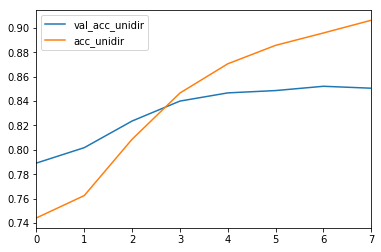

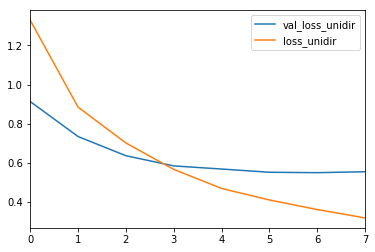

In [180]:
df_unidirect = pd.DataFrame(history.history)
df_unidirect.columns = ['acc_unidir','loss_unidir','val_acc_unidir','val_loss_unidir']
df_unidirect[['val_acc_unidir', 'acc_unidir']].plot.line();
df_unidirect[['val_loss_unidir', 'loss_unidir']].plot.line();

In [181]:
loss, accuracy = model.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

401/401 [==============================] - 12s 30ms/step
Test loss: 0.5096349467214504
Test accuracy: 0.8613291306983206


In [182]:
'''
Test Accuracy is pretty high (86%), so this means that, even with a few data, the algorithm is able to understand the context
from the input.
'''

##### Bidirectional

In [183]:
'''
Here, we move to a BIDIRECTIONAL LSTM Neural Network, in order to understand if even what comes after is important to understand
the tag of a single word.
'''
np.random.seed(42)

inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(input_dim=len(word2int), 
                       output_dim=128, 
                       mask_zero=True, 
                       name='embeddings')(inputs)

bilstm = Bidirectional(LSTM(units=256, 
                            return_sequences=True), 
                       name="Bi-LSTM")(embeddings)
dropout = Dropout(0.3, name='dropout')(bilstm)
bilstm_out = Dense(len(tag2int), name='output')(dropout)
output = Activation('softmax', name='softmax')(bilstm_out)

model_bilstm = Model(inputs=[inputs], outputs=[output])
model_bilstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        (None, 245)               0         
_________________________________________________________________
embeddings (Embedding)       (None, 245, 128)          1197440   
_________________________________________________________________
Bi-LSTM (Bidirectional)      (None, 245, 512)          788480    
_________________________________________________________________
dropout (Dropout)            (None, 245, 512)          0         
_________________________________________________________________
output (Dense)               (None, 245, 16)           8208      
_________________________________________________________________
softmax (Activation)         (None, 245, 16)           0         
Total params: 1,994,128
Trainable params: 1,994,128
Non-trainable params: 0
_________________________________________________________________


In [184]:
'''
Again, we choose 8 epochs and 16 as batch size.
'''

batch_size = 16
epochs = 8

model_bilstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

history_bilstm = model_bilstm.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 1284 samples, validate on 321 samples
Epoch 1/8
1284/1284 [==============================] - 280s 218ms/step - loss: 1.2754 - acc: 0.7464 - val_loss: 0.8864 - val_acc: 0.7889
Epoch 2/8
1284/1284 [==============================] - 282s 220ms/step - loss: 0.8167 - acc: 0.7779 - val_loss: 0.6921 - val_acc: 0.8134
Epoch 3/8
1284/1284 [==============================] - 272s 212ms/step - loss: 0.6175 - acc: 0.8308 - val_loss: 0.6164 - val_acc: 0.8312
Epoch 4/8
1284/1284 [==============================] - 271s 211ms/step - loss: 0.4866 - acc: 0.8650 - val_loss: 0.5533 - val_acc: 0.8483
Epoch 5/8
1284/1284 [==============================] - 269s 210ms/step - loss: 0.3852 - acc: 0.8879 - val_loss: 0.5340 - val_acc: 0.8535
Epoch 6/8
1284/1284 [==============================] - 237s 185ms/step - loss: 0.3158 - acc: 0.9041 - val_loss: 0.5274 - val_acc: 0.8549
Epoch 7/8
1284/1284 [==============================] - 240s 187ms/step - loss: 0.2631 - acc: 0.9179 - val_loss: 0.5457 - val_acc: 0

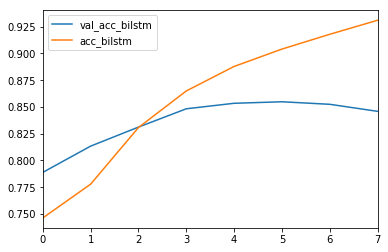

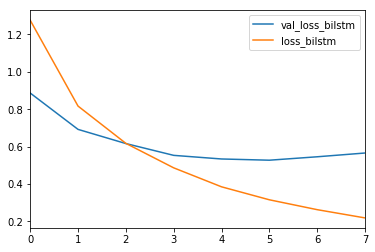

In [185]:
df_bilstm = pd.DataFrame(history_bilstm.history)
df_bilstm.columns = ['acc_bilstm','loss_bilstm', 'val_acc_bilstm', 'val_loss_bilstm']
df_bilstm[['val_acc_bilstm', 'acc_bilstm']].plot.line();
df_bilstm[['val_loss_bilstm', 'loss_bilstm']].plot.line();

In [186]:
loss, accuracy = model_bilstm.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

401/401 [==============================] - 15s 37ms/step
Test loss: 0.5083232884692432
Test accuracy: 0.8574544399456491


In [187]:
'''
From what we can see, accuracy on the TEST DATA is even lower than the UNIDIRECTIONAL, but this probably is due to the fact
that test data are a few, so we probably have to compare the Neural Nets in another way.
'''

##### Sequential

In [188]:
'''
Here, we move to a BIDIRECTIONAL LSTM Neural Network, in order to understand if even what comes after is important to understand
the tag of a single word.
'''

np.random.seed(42)

model_seq = Sequential()
model_seq.add(InputLayer(input_shape=(MAX_LENGTH, ), name="word_IDs"))
model_seq.add(Embedding(len(word2int), 128, mask_zero=True, name='embeddings'))
model_seq.add(Bidirectional(LSTM(256, return_sequences=True), name='bi-LSTM'))
model_seq.add(Dropout(0.3, name='dropout'))
model_seq.add(Dense(len(tag2int), name='output'))
model_seq.add(Activation('softmax', name='softmax'))
model_seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 245, 128)          1197440   
_________________________________________________________________
bi-LSTM (Bidirectional)      (None, 245, 512)          788480    
_________________________________________________________________
dropout (Dropout)            (None, 245, 512)          0         
_________________________________________________________________
output (Dense)               (None, 245, 16)           8208      
_________________________________________________________________
softmax (Activation)         (None, 245, 16)           0         
Total params: 1,994,128
Trainable params: 1,994,128
Non-trainable params: 0
_________________________________________________________________


In [189]:
'''
Again, we choose 8 epochs and 32 as batch size.
'''

batch_size = 32
epochs = 8

model_seq.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_seq = model_seq.fit(train_sentences, train_tags_1hot,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 1284 samples, validate on 321 samples
Epoch 1/8
1284/1284 [==============================] - 164s 128ms/step - loss: 1.4691 - acc: 0.7389 - val_loss: 1.0050 - val_acc: 0.7891
Epoch 2/8
1284/1284 [==============================] - 149s 116ms/step - loss: 1.0450 - acc: 0.7542 - val_loss: 0.8499 - val_acc: 0.7894
Epoch 3/8
1284/1284 [==============================] - 165s 129ms/step - loss: 0.8179 - acc: 0.7707 - val_loss: 0.7273 - val_acc: 0.7981
Epoch 4/8
1284/1284 [==============================] - 165s 129ms/step - loss: 0.6746 - acc: 0.8104 - val_loss: 0.6752 - val_acc: 0.8188
Epoch 5/8
1284/1284 [==============================] - 178s 138ms/step - loss: 0.5833 - acc: 0.8419 - val_loss: 0.6444 - val_acc: 0.8304
Epoch 6/8
1284/1284 [==============================] - 176s 137ms/step - loss: 0.5017 - acc: 0.8633 - val_loss: 0.6082 - val_acc: 0.8360
Epoch 7/8
1284/1284 [==============================] - 182s 142ms/step - loss: 0.4200 - acc: 0.8821 - val_loss: 0.5579 - val_acc: 0

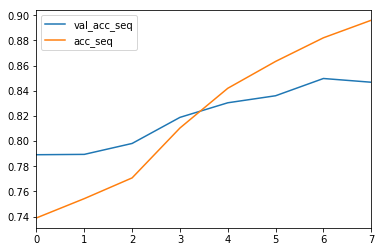

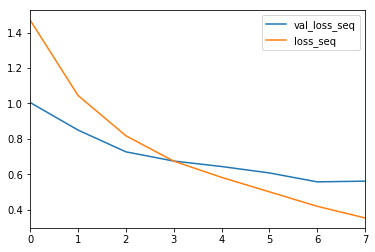

In [190]:
df_seq = pd.DataFrame(history_seq.history)
df_seq.columns = ['acc_seq','loss_seq', 'val_acc_seq', 'val_loss_seq']
df_seq[['val_acc_seq', 'acc_seq']].plot.line();
df_seq[['val_loss_seq', 'loss_seq']].plot.line();

In [191]:
loss, accuracy = model_seq.evaluate(test_sentences, test_tags_1hot,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

401/401 [==============================] - 14s 34ms/step
Test loss: 0.5100992177787267
Test accuracy: 0.8518464105979463


In [192]:
'''
From what we can see, accuracy on the TEST DATA is lower than both the UNIDIRECTIONAL and the BIDIRECTIONAL, but this again 
probably is due to the fact that test data are a few, so we have to compare the Neural Nets in another way.
'''

### Comparison between the 3 and baseline of structured perceptron

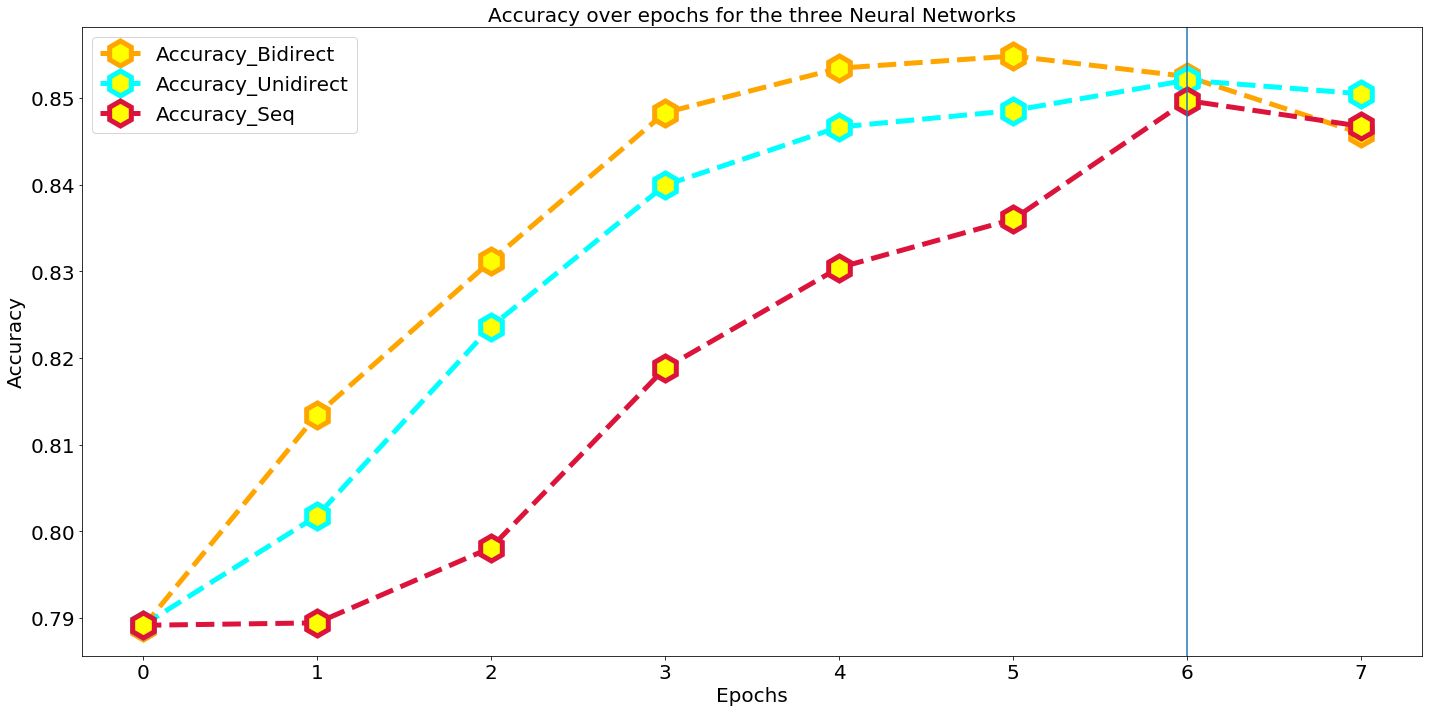

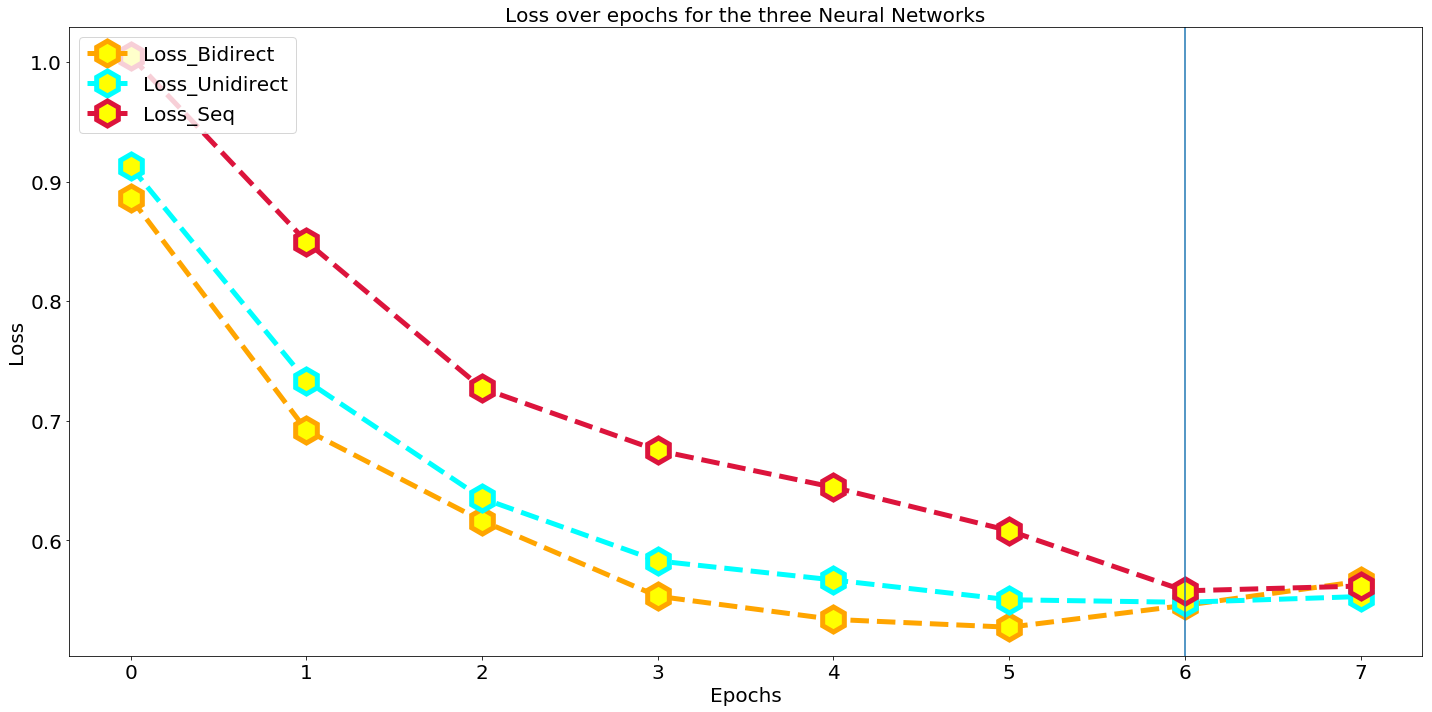

In [193]:
'''
We start from a comparison between the three neural networks.
'''

tot_df = pd.concat([df_seq,df_bilstm,df_unidirect],axis=1)
accuracy_tot = [[i for i in tot_df['val_acc_bilstm']], [i for i in tot_df['val_acc_unidir']], [i for i in tot_df['val_acc_seq']]]
loss_tot = [[i for i in tot_df['val_loss_bilstm']], [i for i in tot_df['val_loss_unidir']], [i for i in tot_df['val_loss_seq']]]

def funzlist(testo, t, title1, x, title2, title3 = 0, title4 = 0):
    colors = ['orange','cyan','crimson']
    plt.figure(figsize=(20,10))
    if t == 0:
        labels = ["{}_Bidirect".format(title1), "{}_Unidirect".format(title1), "{}_Seq".format(title1)]
    elif t == 1:
        labels = ["{}_Greedy".format(title1), "{}_Viterbi".format(title1)]
    elif t == 2:
        labels = ["{}_{}".format(title1, title3), "{}_{}".format(title1, title4)]
    for i in range(len(testo)):
        plt.plot(testo[i], label = labels[i], linestyle = '--', c = colors[i], linewidth=5,\
                 marker='h', markerfacecolor='yellow', markeredgewidth=5, markersize=25)

    plt.title('{0} over epochs for the {1}'.format(title1, title2), fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.axvline(x, 0, 10)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('{}'.format(title1), fontsize=20)
    plt.legend(loc="upper left", prop={'size': 20})
    plt.tight_layout()
    
funzlist(accuracy_tot, 0, 'Accuracy', 6, 'three Neural Networks')
funzlist(loss_tot, 0, 'Loss', 6, 'three Neural Networks')

In [194]:
'''
From what we can infer from the plot, it is clear to see that Bidirectional neural network is the one that performs better:
it always has the highest accuracy over epochs until convergency, and it minimize the loss over epochs way better than the
other neural networks.We predicted a result like this because Bidirectional is learning also from what follows the 
inspected word, so it is able to learn the context in a much faster and better way compared to the others.
'''

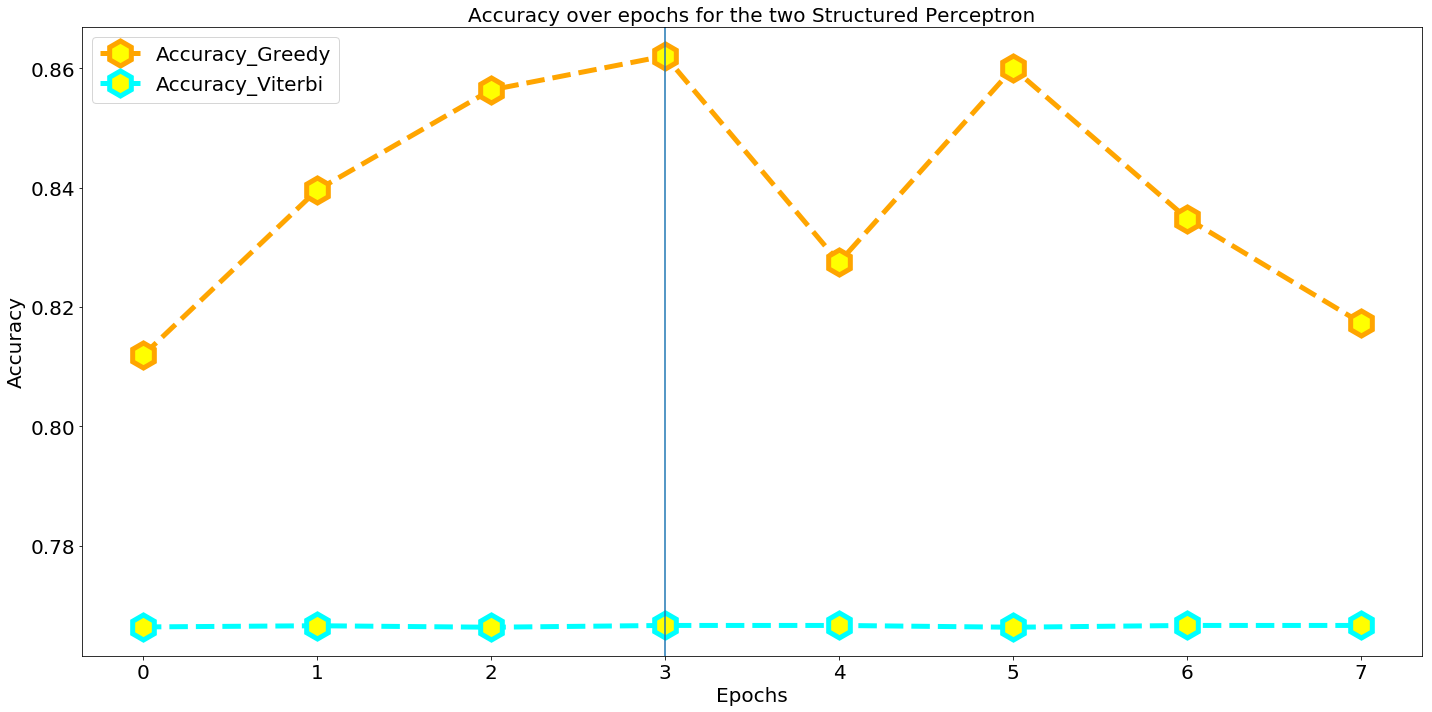

In [195]:
'''
Now we compare the two structured Perceptron, basing on accuracy over iterations.
'''

funzlist(lista_acc_sp, 1, 'Accuracy', 3, 'two Structured Perceptron')

In [196]:
'''
We can immediately see that Greedy method performs way better than Viterbi method. Basically, Viterbi keeps always the
same accuracy, even with an increase of the features.
'''

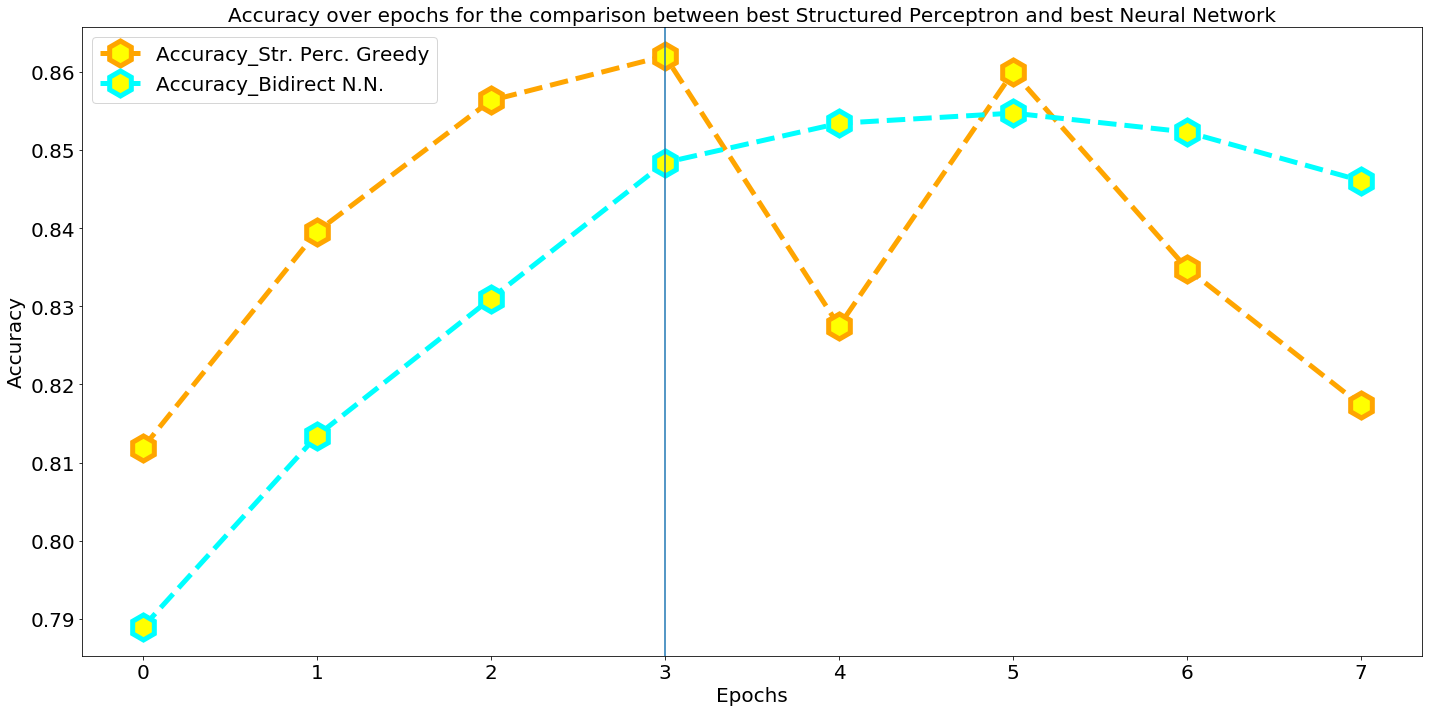

In [197]:
'''
Now we will compare the best neural network (Bidirectional) and the best Structured Perceptron (Greedy)
'''
listone_finale = [lista_acc_sp[0], accuracy_tot[0]]

funzlist(listone_finale, 2, 'Accuracy', 3, 'comparison between best Structured Perceptron and best Neural Network',
         'Str. Perc. Greedy', 'Bidirect N.N.')

In [198]:
'''
From what we can understand from the plot, Structured Perceptron with Greedy method performs even better than the Bidirectional
Neural Network. Probably, seeing the improving of the accuracy for both the algorithms, it should have been better to stop
at the fourth epoch: we can see that Structured Perceptron is able to reach its top within those epochs, while Bidirectional
Neural Net doesn't improve very much in following epochs. So we can say that, with this amount of data, Structured Perceptron
is able to perform better. It would be very interesting to see if, with more data, Bidirectional Neural Network is able to 
overcome performances of Structured Perceptron.
'''

In [199]:
'''
Now we basically build a classification report for the two, in order to understand not only which of the algorithms performs
better in the general accuracy, but we'd like to take a look at accuracy related to single labels.
'''

vv = pd.read_csv('test_finale_NER.csv').drop(['Unnamed: 0'], axis=1)
testo = vv.iloc[:,0]
y_pred = vv.iloc[:,1]

yy_pred = []

for i in y_pred:
    yy_pred.append(i.split())
    
yy_pred = pd.concat([pd.Series(yy_pred[i]) for i in range(len(yy_pred))])
yy_pred = yy_pred.reset_index()
yy_pred = yy_pred.drop(['index'],axis=1)
yy_pred.columns = ['vero']

str_perc = [sp.predict(testo[i].split(), method='greedy') for i in range(len(testo))]
str_perc = pd.concat([pd.Series(str_perc[i]) for i in range(len(str_perc))])
str_perc = str_perc.reset_index()
str_perc = str_perc.drop(['index'],axis=1)
str_perc.columns = ['percettrone']

strange_sentences = [testo[i].split() for i in range(len(testo))]
strange_sentences_int = [[word2int.get(word, 1) for word in sentence] for sentence in strange_sentences]
strange_sentences_int = pad_sequences(strange_sentences_int, maxlen=MAX_LENGTH, padding='post')
predictions_seq = model_bilstm.predict(strange_sentences_int)
y_predetta = inverse_transform(strange_sentences, predictions_seq)

bilat = pd.concat([pd.Series(y_predetta[i]) for i in range(len(y_predetta))])
bilat = bilat.reset_index()
bilat = bilat.drop(['index'],axis=1)
bilat.columns = ['neuralnet']

In [200]:
print('BEST STRUCTURED PERCEPTRON (GREEDY)')
print(' ')
print(classification_report(yy_pred['vero'], str_perc['percettrone']))
print(' ')
print('BEST NEURAL NETWORK (BIDIRECTIONAL)')
print(' ')
print(classification_report(yy_pred['vero'], bilat['neuralnet']))

BEST STRUCTURED PERCEPTRON (GREEDY)
 
              precision    recall  f1-score   support

        B-DT       0.60      0.51      0.55        76
        B-KL       0.59      0.72      0.65       703
       B-LOC       0.45      0.43      0.44       284
       B-ORG       0.40      0.51      0.45       154
        B-VC       0.68      0.74      0.71       802
        B-WP       0.76      0.87      0.81       353
        B-WT       0.57      0.26      0.36       427
        I-DT       0.39      0.59      0.47        64
        I-KL       0.51      0.60      0.55       324
       I-LOC       0.55      0.57      0.56       350
       I-ORG       0.54      0.35      0.43       122
        I-VC       0.42      0.66      0.51       173
        I-WP       0.60      0.65      0.63        84
        I-WT       0.55      0.15      0.23       249
           O       0.96      0.96      0.96     15844

    accuracy                           0.88     20009
   macro avg       0.57      0.57      0.5

In [201]:
'''
As we can see, general accuracy is higher for the Structured Perceptron is higher than the one of the Bidir. Neural Network
(0.88 vs 0.86). As we can see, in our Test data, 'O' label (that is the label for general words that we are not interested
in), appears in the 79.2% of the total labels. We can see that the Structured Perceptron has an higher accuracy on them (0.96)
compared to the one of the Bidirectional Neural Network (0.92). This probably is the reason why the Structured Perceptron
results in an higher general accuracy.
On the other labels, S.P. has a mean accuracy of 0.544 with a standard deviation of 0.102, while Bidirectional Neural Net
has a mean accuracy of 0.521, so a little bit less, but with a standard deviation of 0.182, so a little bit more variation
in the prediction.
'''

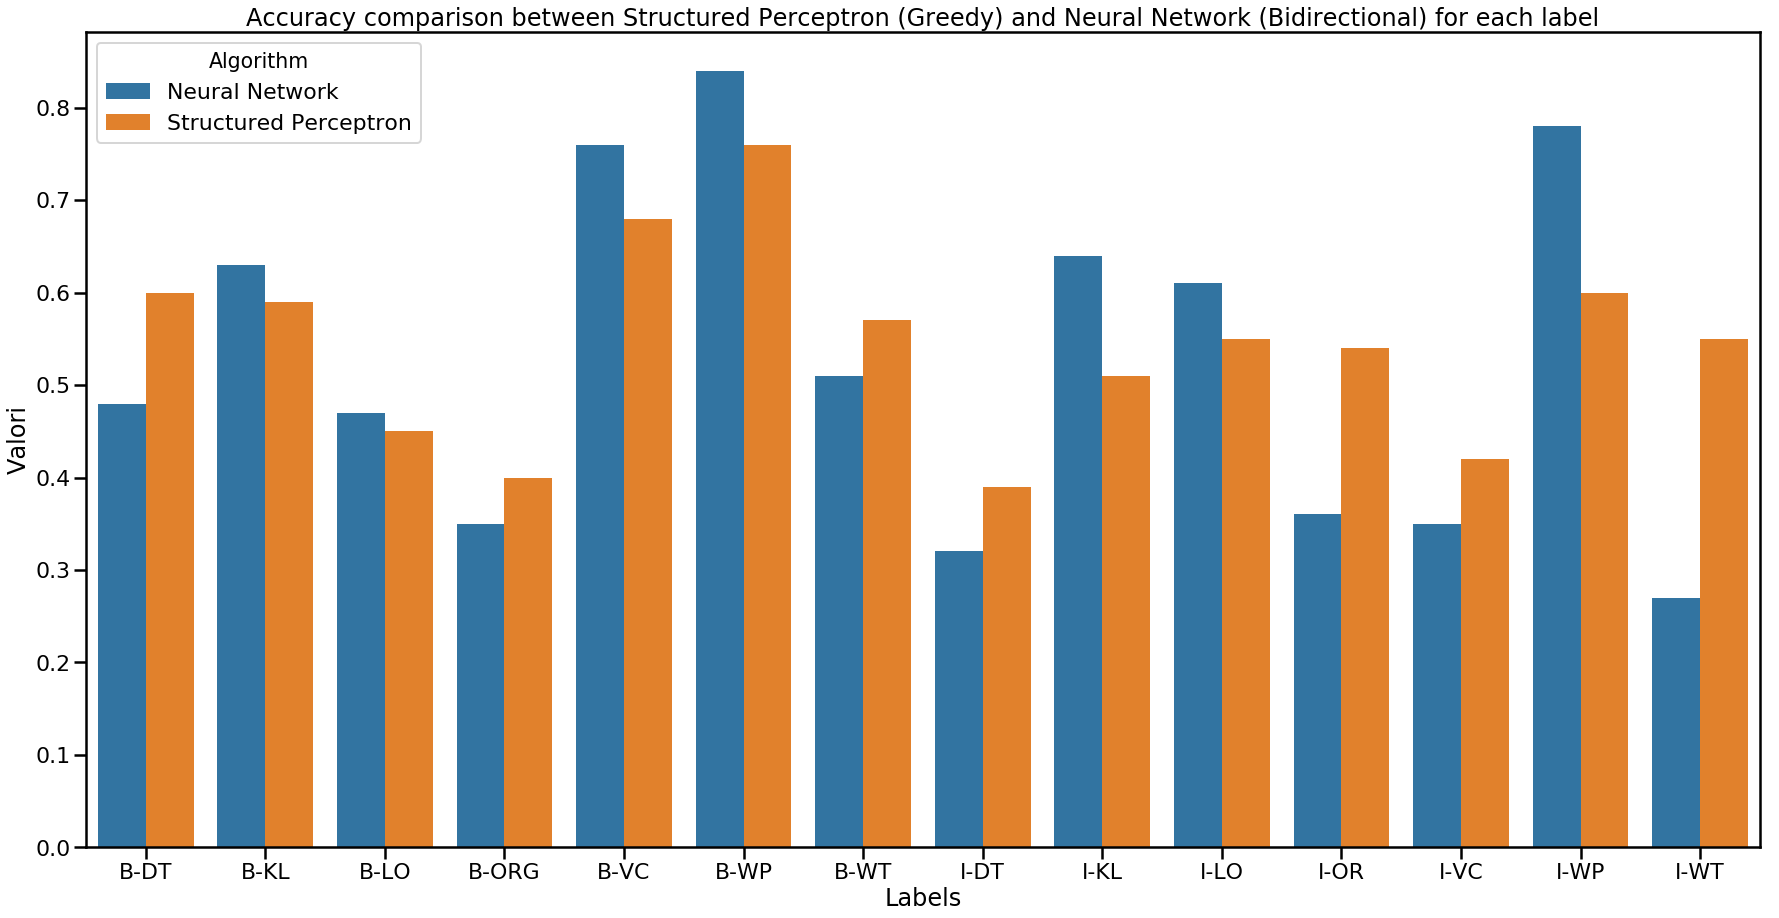

In [202]:
'''
Here we have a barplot where we show side-by-side the difference between the two algorithms for each of the labels.
'''

labels = ['B-DT','B-DT', 'B-KL','B-KL', 'B-LO','B-LO','B-ORG','B-ORG','B-VC',
          'B-VC','B-WP','B-WP','B-WT','B-WT','I-DT','I-DT','I-KL','I-KL','I-LO',
          'I-LO','I-OR','I-OR', 'I-VC','I-VC', 'I-WP','I-WP', 'I-WT','I-WT']  

algo = []
for i in range(14):
    algo.append('Neural Network')
    algo.append('Structured Perceptron')

values = [0.48, 0.60, 0.63, 0.59, 0.47, 0.45, 0.35, 0.40, 0.76, 0.68, 0.84, 0.76, 0.51, 0.57,
          0.32, 0.39, 0.64, 0.51, 0.61, 0.55, 0.36, 0.54, 0.35, 0.42, 0.78, 0.60, 0.27, 0.55]

data_acc = pd.DataFrame({'Labels':labels, 'Algorithm':algo, 'Valori': values})

sb.set_context("poster")

plt.figure(figsize = (30,15))

plt.title('Accuracy comparison between Structured Perceptron (Greedy) and Neural Network (Bidirectional) for each label')

g = sb.barplot(x="Labels", y="Valori", hue="Algorithm", data=data_acc)

sb.reset_orig()

In [203]:
'''
From this side-by-side comparison, we can see that main differences between the two are related to the INSIDE labels (e.g.
for the I-WP the neural networks perform way better, but for the I-WT the Structured Perc. has double the accuracy). 
However, the main three labels (that are Killer [B-KL], Victim [B-VC] and Weapon [B-WP]) are better predicted from the 
Neural Network. Again, it would be very interesting to compare the results with way more data, in order to understand if the
resulting accuracy would change, and if the Best Neural Network would overcome the Best Structured Perceptron.
'''

In [204]:
'''
Here we build a language model, where we try to understand if the generation of a tweet basing on the location (so building
the algorithm every time with the tweets of each single region) gives different results.
'''

def prediction(database):
    smoothing = 0.00001
    START = '_***_'
    STOP = '_STOP_'
    
    counts = defaultdict(lambda: defaultdict(lambda: smoothing))
    
    corpus = [report.strip().split() for report in database]
    
    for sentence in corpus:
        
        tokens = [START, START, START] + sentence + [STOP]
        
        for u, v, w, k in nltk.ngrams(tokens, 4):
            counts[(u, v, w)][k] += 1
            
    def generate():
        """
        generate a new sentence
        """ 
        result = [START, START, START]
        
        next_word = sample_next_word(result[-3], result[-2], result[-1])
        result.append(next_word)
        
        while next_word != STOP:
            next_word = sample_next_word(result[-3], result[-2], result[-1])
            result.append(next_word)
        
        return ' '.join(result[3:-1])
            
    def sample_next_word(u, v, w):
        """
        sample a word w based on the history (u, v)
        """
        
        keys, values = zip(*counts[(u, v, w)].items())
        
        values = np.array(values)
        values /= values.sum() 
        
        sample = np.random.multinomial(1, values) 
        
        return keys[np.argmax(sample)]
    
    return generate()

'''
Now that we built the algorithm, we can print a 'predicted tweet' for every region.
'''

for i in list(set(criminali_refined['Race'])):
    print('Prediction for {}:'.format(i))
    print(' ')
    print(prediction(criminali_refined[criminali_refined['Race'] == i]['Description_orig']))
    print(' ')
    print('---------')

Prediction for African-American/Black:
 
Kernell Harrell reportedly died after officers Steve Carlson, Jeff Barton, Tim Young, Mike Jeffrey and James Hussey tasered, pepper sprayed and tasered. Shortly after he was shot.
 
---------
Prediction for Hispanic/Latino:
 
Police said they were attempting to book Gomez into custody when he started sweating and speaking incoherently. Moreno was pronounced dead at San Jacinto Methodist Hospital. Officer James, who wore a bullet-resistant vest, survived his injuries.
 
---------
Prediction for European-American/White:
 
Smith was shot by Officer Zach Petrick and Officer Chad Frodyma.
 
---------


In [205]:
'''
Let's try to give as input of the algorithms one of these sentences, for example the one for European-American/White
'''

a = 'Smith was shot by Officer Zach Petrick and Officer Chad Frodyma.'

b = sp1.predict(a.split(), method = 'greedy')
print(a)
print(' ')
print('Algorithm : STRUCTURED PERCEPTRON')
print(' ')
for i in range(len(b)):
    if b[i] != 'O':
        print((a.split()[i],b[i]))
    else:
        continue  

print(' ')
print('Algorithm : BEST NEURAL NETWORK')
print(' ')

strange_sentences = [a.split()]
strange_sentences_int = [[word2int.get(word, 1) for word in sentence] for sentence in strange_sentences]
strange_sentences_int = pad_sequences(strange_sentences_int, maxlen=MAX_LENGTH, padding='post')
predictions_seq = model_bilstm.predict(strange_sentences_int)
y_predetta = inverse_transform(strange_sentences, predictions_seq)

for i in range(len(y_predetta[0])):
    if y_predetta[0][i] != 'O':
        print((a.split()[i],y_predetta[0][i]))
    else:
        continue

Smith was shot by Officer Zach Petrick and Officer Chad Frodyma.
 
Algorithm : STRUCTURED PERCEPTRON
 
('Smith', 'B-VC')
('Officer', 'B-KL')
('Zach', 'I-KL')
('Petrick', 'I-KL')
('Officer', 'B-KL')
('Chad', 'I-KL')
('Frodyma.', 'I-KL')
 
Algorithm : BEST NEURAL NETWORK
 
('Smith', 'B-VC')
('Officer', 'B-KL')
('Zach', 'I-KL')
('Officer', 'B-KL')
('Chad', 'I-KL')
('Frodyma.', 'I-KL')


In [206]:
'''
We can see that results are pretty good for both of the algorithms. Best result is the one of the Structured Perceptron, that
is able to detect also Petrick as 'I - KL'.
'''

### Conclusion

During this project, we tried to understand if there was a way to understand, from a police report, the race of the person involved in the fatality. It was interesting to see that, during the classification part, we managed to get a good 60% of accuracy, understanding that there are more common 'situation' within some races rather than other: from the 'undocumented immigrant' related to Hispanic people to the 'shoot back' of the African-American people. During the second part of the project, we tried to understand if it is possible, by teaching the algorithm the right 'context', to automatically retrieve important informations like killer, victim, datetime, location, weapons... with a Neural Network: we managed to get a very good result, and this could have some serious consequences: automation of the data storage could save a lot of time in police stations, leaving more time to police officers in focusing on more important things. 